# TransactionSentinel: Proteção inteligente contra fraudes em transações de cartão de crédito.


* Este notebook apresenta a construção de um estudo e um modelo de ML para detecção de fraudes em dados financeiros fictícios, seguindo a metodologia CRISP-DM.

* A abordagem será estruturada em cinco das seis etapas da metodologia. A etapa de Deploy (Implantação) não será totalmente executada; no entanto, o modelo será salvo como se estivesse pronto para produção.
    * Etapas: 

        * **Compreensão do Negócio** – Definição do problema e dos objetivos do projeto. ✅

        * **Compreensão dos Dados** – Exploração inicial para entender a estrutura e qualidade dos dados.✅

        * **Preparação dos Dados** – Tratamento, limpeza e transformação dos dados para a modelagem.✅

        * **Modelagem** – Aplicação de algoritmos de machine learning para detectar padrões de fraude.✅

        * **Avaliação** – Medição do desempenho do modelo para garantir sua eficácia.✅

        * **Deploy** (Implantação) – Integração do modelo em um ambiente operacional para uso real.❌

# 1.Compreensão do Negócio

* A detecção de fraudes em transações financeiras é um desafio para instituições bancárias, financeiras e operadoras de cartões de crédito. A identificação eficiente de fraudes reduz perdas financeiras e protege clientes contra atividades fraudulentas que geram desconforto e até mesmo danos financeiros. 

* Objetivo do Projeto:

    * 1- Desenvolver uma análise exploratória que forneça informações sobre o comportamento dos eventos fraudulentos e não fraudulentos. ✅

    * 2-Desenvolver um modelo de Machine Learning capaz de identificar transações fraudulentas com alto desempenho e eficácia, garantindo um equilíbrio entre segurança e experiência do usuário.✅




        * O modelo será avaliado com as seguintes métricas:

        * **Recall ≥ 70%** – Para minimizar a quantidade de fraudes não detectadas.✅

        * **AUC-ROC ≥ 85%** – Para garantir uma boa distinção entre transações legítimas e fraudulentas.✅

        * **F1-score ≥ 74%** – Para garantir um bom equilíbrio entre precisão e recall, considerando a importância de minimizar tanto os falsos positivos quanto os falsos negativos.  ✅

           
        

* Restrições de Negócio

    Para atender a requisitos e garantir um modelo confiável:

    * Imparcialidade e Prevenção de Discriminação: 
    
        O modelo não deve apresentar tendências discriminatórias baseadas em atributos como gênero, idade, localização ou outros fatores socioeconômicos. Se esse tipo de varivel for interessante ao evento em estudo, deve se aplicar transformacoes nessas variaveis para que seja mitigada chance de vies descriminativo, 
        ex: idade, localizacao, genero. ✅

 
    * Explicabilidade e Transparência

        O modelo deve ser interpretável tanto globalmente quanto localmente, garantindo que especialistas possam entender seus critérios de decisão. 
        ex: aplicar Técnicas como SHAP (SHapley Additive Explanations) e LIME (Local Interpretable Model-agnostic Explanations).✅

* Escopo da Implantação
    * O modelo final será salvo para futuras implementações, mas a fase de Deploy não será completamente executada neste estudo.✅



# 2.Compreensão dos Dados

In [ ]:
#Bibliotecas
import joblib
import os
import shutil
import time
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

import pingouin
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind

import numpy as np
import pandas as pd
import torch

from category_encoders import TargetEncoder, WOEEncoder
from custom_transformers import (
    WoeTransformer,
    YeoJohnsonTransformer,
    OutlierPercentilFlagTransformer,
    OrdinalEncoderTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.feature_selection import mutual_info_classif

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.pipeline import FeatureUnion, Pipeline

#from imblearn.combine import SMOTEENN
#from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    accuracy_score, average_precision_score, balanced_accuracy_score,
    classification_report, confusion_matrix,
    f1_score, matthews_corrcoef, precision_score,
    recall_score, roc_auc_score
)

from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference
)

import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split



# # Técnicas de oversampling (foram testadas mas descartadas)
# from imblearn.over_sampling import (
#     SMOTE,               # SMOTE padrão
#     ADASYN,              # SMOTE adaptativo
#     BorderlineSMOTE,     # SMOTE focado na fronteira
#     KMeansSMOTE          # SMOTE com KMeans
# )

# # Técnicas combinadas com undersampling
# from imblearn.combine import (
#     SMOTEENN,            # SMOTE + Edited Nearest Neighbors
#     SMOTETomek           # SMOTE + Tomek Links
# )


# from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE, BorderlineSMOTE, RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
# from imblearn.combine import SMOTETomek, SMOTEENN

#aqui so pra nao poluir do warning de imcompatibilidade do torch com numpy 
warnings.filterwarnings("ignore", message="A module that was compiled using NumPy 1.x cannot be run in NumPy 2.1.3")
 

* Importando e conhecendo os dados inicialmente

In [3]:
############para Kaggle

# Load the training dataset
#train_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv') 

# Load the testing dataset
#test_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

# Display the first few rows of both datasets
#print("First 5 rows of the training dataset:")
#print(train_data.head())

#print("\nFirst 5 rows of the testing dataset:")
#print(test_data.head())


# Carregando arquivos em parquet
df_orig_train = pd.read_parquet('C:/Users/jgeov/OneDrive/Documentos/GitHub/Ciencia_de_dados-1/Fraud_detection/fraudTrain.parquet')
df_orig_test = pd.read_parquet('C:/Users/jgeov/OneDrive/Documentos/GitHub/Ciencia_de_dados-1/Fraud_detection/fraudTest.parquet')



In [4]:
print('df_treino dimensões:', f"{df_orig_train.shape[0]:,}".replace(',', '.') + ' linhas, ' + f"{df_orig_train.shape[1]:,}".replace(',', '.') + ' colunas')
print('')
print('df_teste dimensões:', f"{df_orig_test.shape[0]:,}".replace(',', '.') + ' linhas, ' + f"{df_orig_test.shape[1]:,}".replace(',', '.') + ' colunas')
print('')
print('Total de observações:', f"{df_orig_train.shape[0] + df_orig_test.shape[0]:,}".replace(',', '.'))


df_treino dimensões: 1.296.675 linhas, 23 colunas

df_teste dimensões: 555.719 linhas, 23 colunas

Total de observações: 1.852.394


In [5]:
# Se você quiser combiná-los (por exemplo, por concatenação)
df_total = pd.concat([df_orig_train, df_orig_test], ignore_index=True)

# Exibindo as primeiras linhas do DataFrame combinado

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)


df_total.head(3)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [6]:
#A coluna "Unnamed: 0" representa apenas a contagem dos datasets de treino e teste. Ao concatená-los para a compreensão dos dados, essa coluna foi duplicada.
#Como se trata apenas de um índice sem valor informativo para a análise, e não será utilizada em nenhuma etapa do estudo, ela será removida já nesta fase.
df_total.sort_values(by="Unnamed: 0", ascending=True).head(5)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296675,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1296676,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [7]:
#removendo 
df_total = df_total.drop(columns=["Unnamed: 0"])

#resetando indice (morrer de certeza, depois da concatenacao pode ter duplicado tambem em algum ponto)
df_total = df_total.reset_index(drop=True)

#ordenando os dados pelo indice
df_total = df_total.sort_index(ascending=True)


df_total.head(5)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [8]:
print('df_total dimesoes:',df_total.shape) #comparacao com soma dos dfs de treino e teste (soma bate) ok

df_total dimesoes: (1852394, 22)


In [9]:
#cnhecendo as colunas e tipos de dados
print(df_total.columns)
print("")
print(df_total.dtypes)

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud              

In [10]:
#checando os valores null em cada variavel 

#checando se há valores nulos 
df_total.isnull().sum()  
#valores nulos nao encontrados 

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [11]:
#contando a quantidade de zeros em cada coluna para verificar se elas tem 
# informacao suficiente para entrar no modelo futuramente

for col in df_total.columns:
    zero_count = (df_total[col] == 0).sum()
    print("")
    print(f" '{col}': {zero_count} valores zero")

    #nenhuma variavel contem valores zerados, a nao ser a variavel alvo,
    #  e aqui ja podemos ver que se trata de um estudo de enventos raros realmente. 




 'trans_date_trans_time': 0 valores zero

 'cc_num': 0 valores zero

 'merchant': 0 valores zero

 'category': 0 valores zero

 'amt': 0 valores zero

 'first': 0 valores zero

 'last': 0 valores zero

 'gender': 0 valores zero

 'street': 0 valores zero

 'city': 0 valores zero

 'state': 0 valores zero

 'zip': 0 valores zero

 'lat': 0 valores zero

 'long': 0 valores zero

 'city_pop': 0 valores zero

 'job': 0 valores zero

 'dob': 0 valores zero

 'trans_num': 0 valores zero

 'unix_time': 0 valores zero

 'merch_lat': 0 valores zero

 'merch_long': 0 valores zero

 'is_fraud': 1842743 valores zero


# 2.1 Analisando e Descrevendo: Análise Exploratória (EDA)


* Dicionario de dados e acoes previamente ja determinadas de acordo com a natureza da varivel. 
* O oficial nao foi divulgado, entao com base no nome das variaveis foi determinado: 



| **Nome da Variável**        | **Descrição**                                                                 | **Transformação Necessária** |
|-----------------------------|-------------------------------------------------------------------------------|-----------------------------|
| **trans_date_trans_time**    | Data e hora da transação (`yyyy-mm-dd hh:mm:ss`).                            | Extrair hora, dia da semana, mês, periodo da transacao etc.|
| **cc_num** | Número do cartão de crédito utilizado na transação.<br> Pode ser útil para identificar padrões de uso suspeitos e anomalias.<br> Contudo, é um dado sensível e deve ser tratado para garantir conformidade com normas de privacidade. |  Extrair padrões relevantes, como:<br>  - Extrair primeiros dígitos (BIN) que identificam o banco das transações <br>  - Contagem de transações por cartão em um período de tempo. <br> - Contagem de vezes que o cartao foi usado|
| **merchant**                 | Nome do comerciante.                                                          | Transformar com WOE (Weight of Evidence) |
| **category**                 | Categoria da transação (`misc_net`, `grocery_pos`, etc.).                     | Transformar com WOE (Weight of Evidence)|
| **amt**                      | Valor da transação.                                                           | Transformar Yeo-Johnson|
| **first**                    | Primeiro nome do titular.                                                     | Remover (Irrelevante). |
| **last**                     | Sobrenome do titular.                                                         | Remover (Irrelevante). |
| **gender**                   | Gênero do titular (`F` ou `M`).                                               | One Hot Encoder (Possível viés discriminatório, é monitorada).|
| **street**                   | Endereço do titular.                                                          | Target Encoder |
| **city**                     | Cidade do titular.                                                            | Transformar com WOE (Weight of Evidence) |
| **state**                    | Estado do titular.                                                            | Target Encoder |
| **zip**                      | Código postal (CEP).                                                          | Target Encoder |
| **lat**                      | Latitude da localização do titular.                                           | Usada para cálculo de distância |
| **long**                     | Longitude da localização do titular.                                          | Usada para cálculo de distância |
| **city_pop**                 | População da cidade do titular.                                               | Removida - teste estatístico (p-val > 0.05) |
| **job**                      | Profissão do titular.                                                         | Transformar com WOE (Weight of Evidence) |
| **dob**                      | Data de nascimento (`yyyy-mm-dd`).                                            | Converter para idade. |
| **trans_num**                | Identificador único da transação.                                             | Remover (Irrelevante). |
| **unix_time**                | Timestamp Unix (segundos desde 1970).                                         | Remover - reduntande ja temos trans_date_trans_time  |
| **merch_lat**                | Latitude da localização do comerciante.                                       | Remover - não teve utilidade |
| **merch_long**               | Longitude da localização do comerciante.                                      | Remover - não teve utilidade |
| **is_fraud**                 | Indicador de fraude (`1` = fraudulenta, `0` = legítima).                      | **Variável alvo** |



In [12]:
print(df_total.dtypes)

df_anl_num = df_total.select_dtypes(include=[np.number])

pd.options.display.float_format = '{:.2f}'.format  # config 2 casas decimais para configurar o describe
df_anl_num.describe()

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00
mean,417386038393710400.00,70.06,48813.26,38.54,-90.23,88643.67,1358674218.83,38.54,-90.23,0.01
std,1309115265318734848.00,159.25,26881.85,5.07,13.75,301487.62,18195081.39,5.11,13.76,0.07
min,60416207185.00,1.00,1257.00,20.03,-165.67,23.00,1325376018.00,19.03,-166.67,0.00
25%,180042946491150.00,9.64,26237.00,34.67,-96.80,741.00,1343016823.75,34.74,-96.90,0.00
50%,3521417320836166.00,47.45,48174.00,39.35,-87.48,2443.00,1357089331.00,39.37,-87.44,0.00
75%,4642255475285942.00,83.10,72042.00,41.94,-80.16,20328.00,1374581485.25,41.96,-80.25,0.00
max,4992346398065154048.00,28948.90,99921.00,66.69,-67.95,2906700.00,1388534374.00,67.51,-66.95,1.00


* Verificando relacao entre a variavel alvo e as variaveis explicativas numericas
    * sem muita correlacao inicialmente 

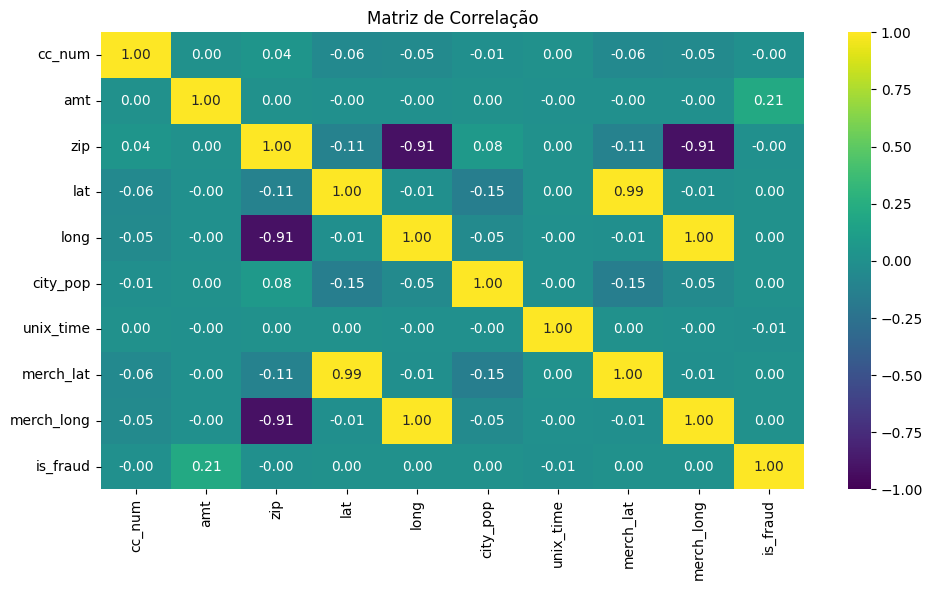

In [ ]:
# Suprimir todos os warnings
warnings.filterwarnings("ignore")

# Criar a fig com 1 subgráfico
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

#gráfico de Correlação (Matriz de Correlação)
sns.heatmap(df_anl_num.corr(), annot=True, cmap="viridis", fmt=".2f", ax=axes, vmin=-1, vmax=1)
axes.set_title('Matriz de Correlação')
plt.tight_layout()
plt.show()




* Verificando relacao entre a variavel alvo e as variaveis explicativas categoricas ("frequencias")
    * Aqui ja podemos ver como se trata de um evento raro; 
    * as cateogrias de compras (variavel category) com "_net" sao de transacoes de compra online, as "_pos" sao trasacoes de compra presenciais. Elas detem a maioria das fraudes dentre as categorias, o que é naturalmente compreensivel. 

In [14]:
df_anl_cat = df_total.select_dtypes(include=['object']) #df so de categoricas elegiveis para analise (APENAS ANALISE)
df_anl_cat.head(5)


,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46


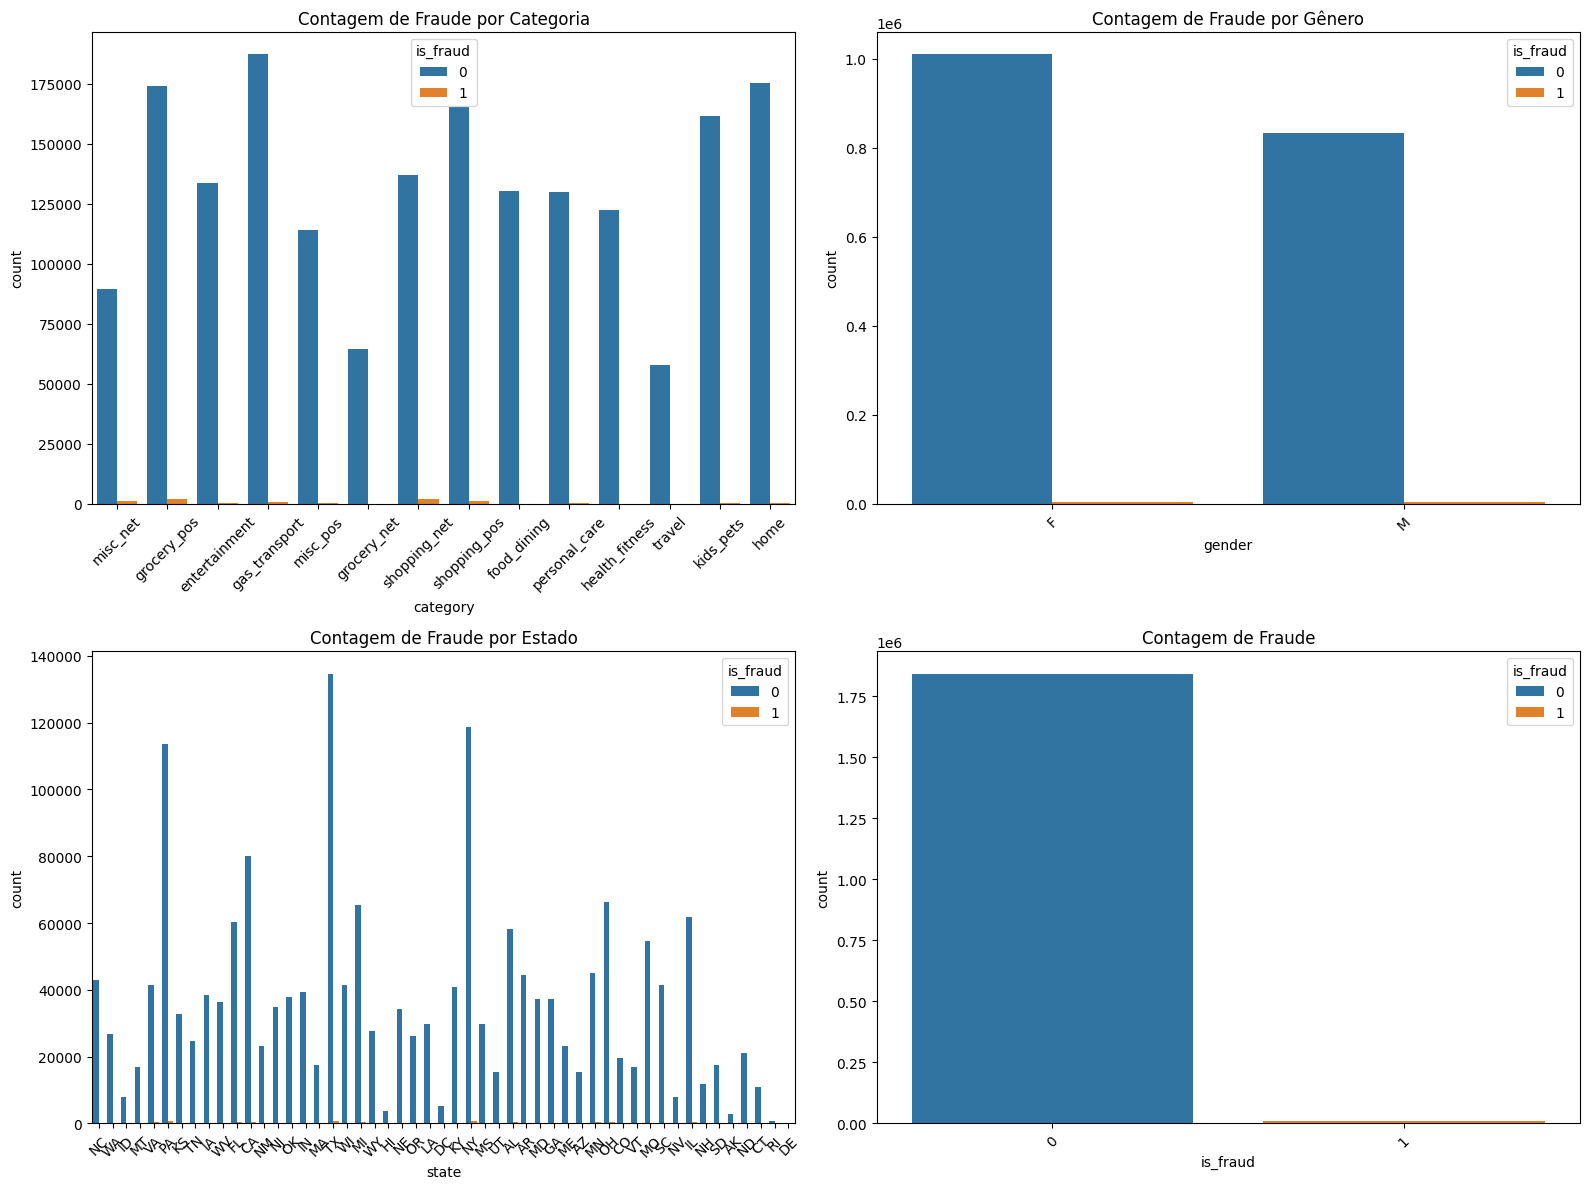

In [ ]:
df_anl_cat = df_total[['category','gender','state','is_fraud']] #df so de categoricas elegiveis para analise (APENAS ANALISE)


# Criar a fig com subgraficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gráfico de contagem para a variável 'category'
sns.countplot(data=df_anl_cat, x='category', hue='is_fraud', ax=axes[0, 0])
axes[0, 0].set_title('Contagem de Fraude por Categoria')

# 2. Gráfico de contagem para a variável 'gender'
sns.countplot(data=df_anl_cat, x='gender', hue='is_fraud', ax=axes[0, 1])
axes[0, 1].set_title('Contagem de Fraude por Gênero')

# 3. Gráfico de contagem para a variável 'state'
sns.countplot(data=df_anl_cat, x='state', hue='is_fraud', ax=axes[1, 0])
axes[1, 0].set_title('Contagem de Fraude por Estado')

# 3. Gráfico de contagem para a variável 'state'
sns.countplot(data=df_anl_cat, x='is_fraud', hue='is_fraud', ax=axes[1, 1])
axes[1, 1].set_title('Contagem de Fraude')

# Aplicar rotação de 45 graus nos eixos x
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo x para 45 graus

# Ajustar layout e exibir
plt.tight_layout()
plt.show()



* Verificando a relacao entre as variaveis numericas explicativas (sem variavel alvo)
    * Vemos um agrupamento em valores pequenos para ambas variaveis;
    * embora a variavel alvo esteja na legenda, é meramente para vermos onde se encontrar as observacoes de fraude entre as variaveis, nao e muito conclusivo mas da uma ideia de onde se "agrupam" em termos de valores

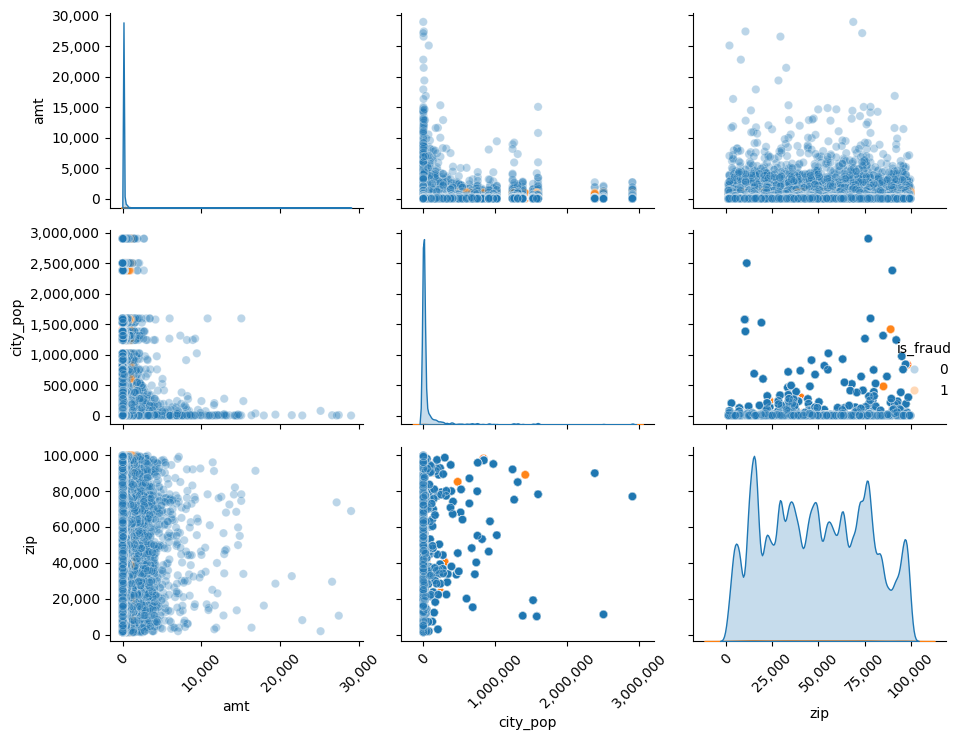

In [ ]:
# pairplot
g = sns.pairplot(
    df_anl_num[['amt','city_pop','is_fraud','zip']], 
    hue='is_fraud',
    diag_kind='kde',
    height=2.5,
    aspect=1.2,
    plot_kws={'alpha': 0.3}
)

# Formata os eixos 
for ax in g.axes.flatten():
    # Formatação(sem notação científica automatica)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.tick_params(axis='x', rotation=45) # eixo x em 45 graus

    plt.tight_layout()

plt.show()

* Verificando a relacao entre as variaveis explicativas categoricas (sem variavel alvo)
    * Aqui verificamos se ha associacao estatistica entre as variveis cetegoricas (sem a alvo) pelo teste de Qui2
    * Verificamos e classificamos em baixa media e alta a forca das associaicoes entre as variaveis categoricas, e plotamos os resultados pelo heatmap de V de Cramer tambem. 

Teste Qui-Quadrado entre category e gender:
Qui²=5407.24, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.05 (Baixa Força de associação)

Teste Qui-Quadrado entre category e state:
Qui²=9421.63, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.02 (Baixa Força de associação)

Teste Qui-Quadrado entre gender e category:
Qui²=5407.24, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.05 (Baixa Força de associação)

Teste Qui-Quadrado entre gender e state:
Qui²=121239.38, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.26 (Média Força de associação)

Teste Qui-Quadrado entre state e category:
Qui²=9421.63, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.02 (Baixa Força de associação)

Teste Qui-Quadrado entre state e gender:
Qui²=121239.38, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.26 (Média Força de associação)



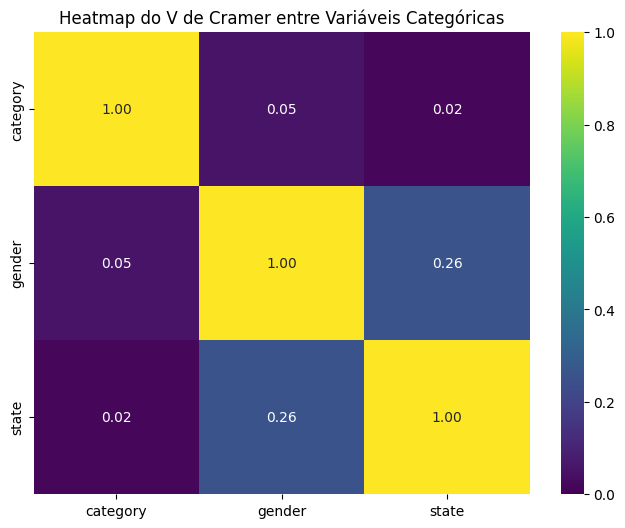

In [17]:
# df_ de categoricas sem a variavel alvo
df_cat = df_anl_cat[['category', 'gender', 'state']]

def cramers_v(x, y):
    """Calcula o V de Cramer entre duas variáveis categóricas."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Função para categorizar a força do V de Cramer
def categorize_cramers_v(value):
    if value < 0.10:
        return "Baixa Força de"
    elif value < 0.30:
        return "Média Força de"
    else:
        return "Alta Força de"

# Inicializa um DataFrame para armazenar os resultados
results = pd.DataFrame(index=df_cat.columns, columns=df_cat.columns)

for col1 in df_cat.columns:
    for col2 in df_cat.columns:
        if col1 == col2:
            results.loc[col1, col2] = 1.0  # Correlação perfeita com ela mesma
        else:
            table = pd.crosstab(df_cat[col1], df_cat[col2])
            chi2, p, _, _ = chi2_contingency(table)
            v_cramer = cramers_v(df_cat[col1], df_cat[col2])

            # Interpretação do p-valor
            significance = "há evidência de associação" if p < 0.05 else "não há evidência de associação"
            
            # Classificação da força do V de Cramer
            strength = categorize_cramers_v(v_cramer)

            print(f'Teste Qui-Quadrado entre {col1} e {col2}:')
            print(f'Qui²={chi2:.2f}, p-valor={p:.4f} ({"menor" if p < 0.05 else "maior"} que 0.05, {significance}).')
            print(f'V de Cramer={v_cramer:.2f} ({strength} associação)\n')

            results.loc[col1, col2] = v_cramer


# Converte os valores para float
results = results.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, cmap='viridis', fmt='.2f', vmin=0, vmax=1)
plt.title('Heatmap do V de Cramer entre Variáveis Categóricas')
plt.show()




* Aqui evidencia-se o desbalance das classes da variavel alvo, trata-se de um evento raro, conforme ja haviam indicios. 

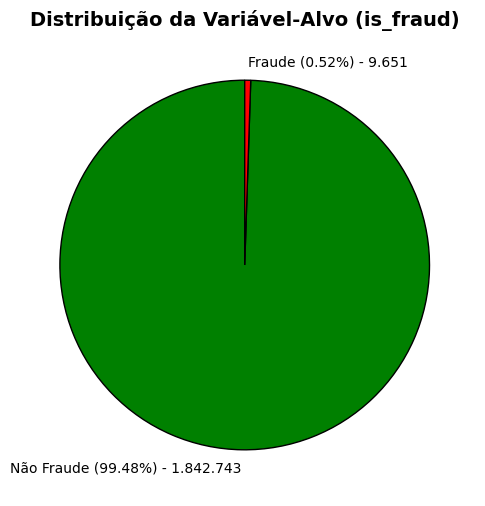

In [ ]:
# Contar a quantidade de cada classe
fraud_counts = df_total["is_fraud"].value_counts()

# Criar o gráfico de pizza
plt.figure(figsize=(6, 6))
wedges, texts = plt.pie(
    fraud_counts, labels=["Não Fraude", "Fraude"], 
    colors=["green", "red"], startangle=90, wedgeprops={"edgecolor": "black"}
)

# Adicionar os percentuais e contagens formatadas
for i, (text, pct) in enumerate(zip(texts, fraud_counts / fraud_counts.sum() * 100)):
    count_formatted = f"{fraud_counts.iloc[i]:,}".replace(",", ".")
    text.set_text(f"{text.get_text()} ({pct:.2f}%) - {count_formatted}")

# Adicionar título
plt.title("Distribuição da Variável-Alvo (is_fraud)", fontsize=14, fontweight="bold")

plt.show()


* Verificando localizacao das transacoes e dos titulares dos cartoes 
    * Aqui foi dado foco nos maiores ofensores de fraudes: as variaveis de compra presencial "_pos" e online "_net" pois apresentaram grande parte das fraudes 
    * Ha maior concentracao de transacoes do lado da Costa Leste 
    * Existem transacoes no Havai, Canadá e no Alasca, mas sao em pequenos volumes, ainda assim sao estranhas(principalemnte Alasca). 

In [ ]:
# Filtrar apenas transações fraudulentas E que sejam online (_net)
df_fraude_net = df_total[(df_total["is_fraud"] == 1) & (df_total["category"].str.contains("_net", na=False))]

# Criar um DataFrame com as coordenadas SOMENTE de fraudes online
df_mapa = pd.DataFrame({
    "Latitude": list(df_fraude_net["lat"]) + list(df_fraude_net["merch_lat"]),
    "Longitude": list(df_fraude_net["long"]) + list(df_fraude_net["merch_long"]),
    "Tipo": ["Titular"] * len(df_fraude_net) + ["Estabelecimento"] * len(df_fraude_net)
})

# Amostrar 50% dos dados  para evitar sobrecarga 
df_mapa_sample = df_mapa.sample(frac=0.5, random_state=42) if len(df_mapa) > 1000 else df_mapa

# mapa com os pontos das fraudes online
fig = px.scatter_mapbox(df_mapa_sample, lat="Latitude", lon="Longitude",
                        color="Tipo",  
                        mapbox_style="carto-positron",
                        zoom=3, 
                        color_discrete_map={"Titular": "orange", "Estabelecimento": "blue"}  # Define cores personalizadas
                        )

# Ajustar layout com margem superior maior para exibir o título
fig.update_layout(
    width=1700,  
    height=700,  
    margin={"r":0, "t":50, "b":0, "l":0},
    title={
        "text": "AMOSTRA de Distribuição das Transações Fraudulentas ONLINE por Localização do Titular e Estabelecimento",
        "x": 0.5,  # Centraliza o título
        "xanchor": "center",  # Garante alinhamento centralizado
        "yanchor": "top",
        "font": {"size": 20, "family": "Arial Black"}  # Aumenta o tamanho e deixa em negrito
    }
)


fig.show()


In [ ]:
# Filtrar apenas transações fraudulentas E que sejam presenciais (_pos)
df_fraude_net = df_total[(df_total["is_fraud"] == 1) & (df_total["category"].str.contains("_pos", na=False))]

# Criar um DataFrame com as coordenadas SOMENTE de fraudes presenciais
df_mapa = pd.DataFrame({
    "Latitude": list(df_fraude_net["lat"]) + list(df_fraude_net["merch_lat"]),
    "Longitude": list(df_fraude_net["long"]) + list(df_fraude_net["merch_long"]),
    "Tipo": ["Titular"] * len(df_fraude_net) + ["Estabelecimento"] * len(df_fraude_net)
})

# Amostrar 50% dos dados  para evitar sobrecarga 
df_mapa_sample = df_mapa.sample(frac=0.5, random_state=42) if len(df_mapa) > 1000 else df_mapa

#mapa com os pontos das fraudes presenciais, definindo cores específicas
fig = px.scatter_mapbox(df_mapa_sample, lat="Latitude", lon="Longitude",
                        color="Tipo",  
                        mapbox_style="carto-positron",
                        zoom=3,
                        color_discrete_map={"Titular": "orange", "Estabelecimento": "blue"}  # Define cores personalizadas
)

# Ajustar layout
fig.update_layout(
    width=1700,  
    height=700,  
    margin={"r":0, "t":50, "b":0, "l":0},
    title={
        "text": "AMOSTRA de Distribuição das Transações Fraudulentas PRESENCIAIS por Localização do Titular e Estabelecimento",
        "x": 0.5,  
        "xanchor": "center",  
        "yanchor": "top",
        "font": {"size": 20, "family": "Arial Black"}  
    }
)

fig.show()


# 3 Preparação dos Dados: Feature Engineering

* estudar a criacao de variaveis que melhor descrevam o evento de fraude 

# 3.1 Distancia em Km entre estabeleciemnto e titular do cartao para compras presencias. 
* Foi criada uma feature usando a distância entre os pontos pela fórmula de Haversine, pois ela considera a curvatura da Terra e retorna a distância real em km, diferentemente da Euclidiana, que assume um espaço plano (2D) e não converte diretamente em quilômetros.

In [ ]:
# Função para remover variáveis desnecessarias (def de apoio nada especifico desse trecho)
def Limpa_df(df, colunas_para_excluir):
    df = df.drop(columns=colunas_para_excluir, errors='ignore')  # ignora colunas que não existe
    return df


#Organiza o df apenas (def de apoio nada especifico desse trecho)
def mover_target_para_final(df, target): 
    """
    Move a variavel alvo para o final do df

    Isso nao interfere em resultados, e para manter o padrao de legibilidade e facilitar a visualizacao da target
    """
    colunas = [col for col in df.columns if col != target] + [target]
    return df[colunas]



In [ ]:
# criando variavel de distancia em Km entre estabeleciemnto e titular do cartao para compras presencias (nao faz sentido para compras online que podem e (muito provavlemente serao), bem distantes)
#essa variavel permitira entender se a compra presencial foi muito distante do local do titular do cartao, podendo indicar possivel fraude


# Definindo as categorias presenciais
categorias_presenciais = [
    "misc_pos", "grocery_pos", "gas_transport", 
    "shopping_pos", "personal_care", "health_fitness"
]


# Função para calcular distância Haversine em KM
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Raio médio da Terra em km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Aplicar linha a linha
# eliminando caso ja tenha (importante so na hora de construir ou ajustar apenas na cracao dessa feature, para nao ter que ficar reiniciando o kernel)
#if 'distancia_km' in df_total.columns:
#    df_total = df_total.drop(columns='distancia_km')

df_total["distancia_km"] = df_total.apply(
    lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"])
    if row["category"] in categorias_presenciais else np.nan,
    axis=1
)

#trata NAN 
df_total["distancia_km"] = df_total["distancia_km"].fillna(0)


df_total.head(10)





,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distancia_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0,0.00
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0,30.21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0,0.00
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,0,95.67
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,0,77.56
5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,Dublin,PA,18917,40.38,-75.20,2158,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,1325376248,40.65,-76.15,0,85.92
6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,Holcomb,KS,67851,37.99,-100.99,2691,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.16,-100.15,0,0.00
7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,Edinburg,VA,22824,38.84,-78.60,6018,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.95,-78.54,0,12.77
8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,Manor,PA,15665,40.34,-79.66,1472,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1325376318,40.35,-79.96,0,25.27
9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,Clarksville,TN,37040,36.52,-87.35,151785,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,1325376361,37.18,-87.49,0,74.08


* Testando a distancia entre as variaveis em um mapa 
    * sugiro conferir em https://www.movable-type.co.uk/scripts/latlong.html tambem, para ter cereteza da logica de Haversine implantada (comparar os resultados da variavel de distancia pegando as coord e jogando la)

In [23]:
n_observacao=3 #deve ser observacao presencial as demais nao teram valor para essa variavel
# Selecionar a primeira observação do df_total
obs = df_total[df_total["cc_num"] == df_total["cc_num"].iloc[n_observacao]].iloc[0]

# Extrair coordenadas
lat1, lon1 = obs['lat'], obs['long']
lat2, lon2 = obs['merch_lat'], obs['merch_long']
distancia_km = obs['distancia_km']

# Criar DataFrame com os dois pontos
df_pontos = pd.DataFrame({
    'Nome': ['Titular', 'Estabelecimento'],
    'Latitude': [lat1, lat2],
    'Longitude': [lon1, lon2]
})

# Criar figura
fig = go.Figure()

# Adicionar os dois pontos
fig.add_trace(go.Scattermapbox(
    lat=df_pontos['Latitude'],
    lon=df_pontos['Longitude'],
    mode='markers+text',
    text=df_pontos['Nome'],
    marker=dict(size=12, color=['purple', 'blue']),
    textposition="top center",
    name='Pontos'
))

# Linha entre os pontos
fig.add_trace(go.Scattermapbox(
    lat=[lat1, lat2],
    lon=[lon1, lon2],
    mode='lines',
    line=dict(width=2, color='gray'),
    name='Distância reta'
))

# Ponto médio com rótulo da distância
if pd.notna(distancia_km):
    lat_meio = (lat1 + lat2) / 2
    lon_meio = (lon1 + lon2) / 2
    fig.add_trace(go.Scattermapbox(
        lat=[lat_meio],
        lon=[lon_meio],
        mode='markers+text',
        text=[f'{round(distancia_km, 2)} km'],
        marker=dict(size=1, color='white'),  # marcador minúsculo e invisível
        textfont=dict(size=14, color='black'),
        textposition="top center",
        showlegend=False
    ))

# Layout do mapa
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=3,
    mapbox_center={"lat": (lat1 + lat2) / 2, "lon": (lon1 + lon2) / 2},
    margin={"r":0,"t":0,"l":0,"b":0},
    height=500,
    title=f"Mapa: {obs['cc_num']} | Categoria: {obs['category']}"
)

fig.show()


* Verificando as quantidades por "categoria" (criada so pra analise, nao e uma feature) de distancias, para identificar concentracoes em distancias maiores para transacoes presenciais. 
    * Distancias muito grandes para compras presenciais e um estabelecimento "pode" pontar um padrao de fraudes;
    * Ha maior concentracao em fraudes presenciais de 50 a 100 km de distancia entre endereco do titular e o estabelecimento, e uma distancia aceitavel, pode significar viagens, trabalho ... Nada muito discrepante. 
    * Ha poucas variaveis com km acima de 120, nao parecem ser padrao de fraude. 

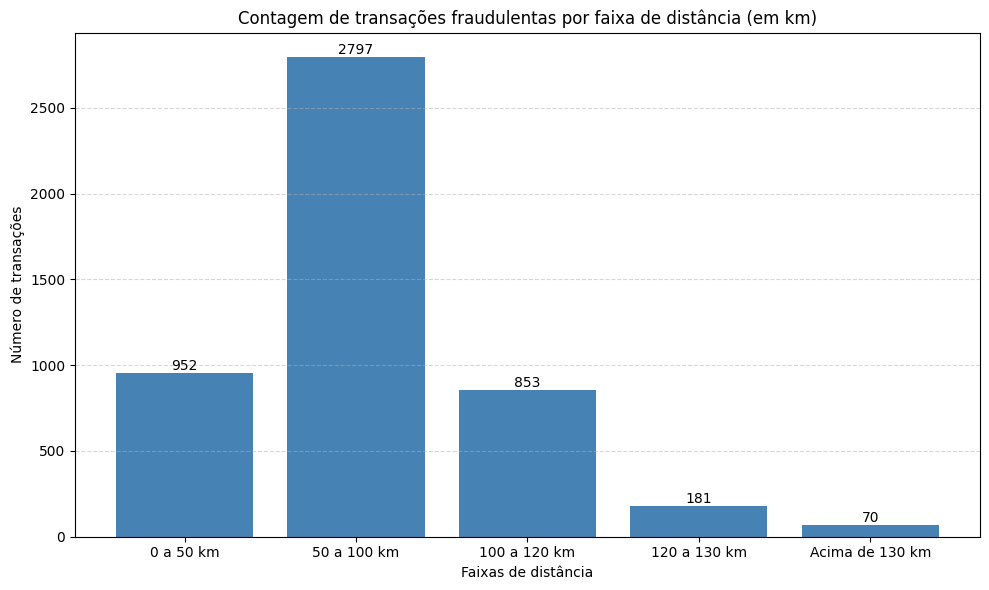

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0,0.00,Sem distância
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0,30.21,0 a 50 km
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0,0.00,Sem distância
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,0,95.67,50 a 100 km
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,0,77.56,50 a 100 km


In [24]:
# Criação da variável categórica com base nas faixas de distância
bins = [0, 50, 100, 120, 130, float('inf')]
labels = ['0 a 50 km', '50 a 100 km', '100 a 120 km', '120 a 130 km', 'Acima de 130 km']

df_total['faixa_distancia'] = pd.cut(df_total['distancia_km'], bins=bins, labels=labels, right=True)

# Agora podemos fazer o agrupamento diretamente com essa nova variável
contagens = df_total[df_total['is_fraud'] == 1]['faixa_distancia'].value_counts().reindex(labels)

# Gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(contagens.index, contagens.values, color='steelblue')

# Adicionando rótulos
for bar, count in zip(bars, contagens.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

plt.title('Contagem de transações fraudulentas por faixa de distância (em km)')
plt.ylabel('Número de transações')
plt.xlabel('Faixas de distância')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Preencher NaN com categoria explícita, sao os valores cuja regra nao se aplicou, pois nao tem distancia a ser calculada, pois sao compras nao presenciais 
df_total['faixa_distancia'] = df_total['faixa_distancia'].cat.add_categories('Sem distância')
df_total['faixa_distancia'].fillna('Sem distância', inplace=True)

df_total.head(5)


In [ ]:

'''organizando o df (nada especifico dessa secao)'''

# Copia a coluna de trans_num para preserva-la comom coluna de dados no df 
df_total["trans_num_copy"] = df_total["trans_num"]

# Define o índice como trans_num 
df_total.set_index("trans_num_copy", inplace=True)


In [26]:
df_total.index.name = None #tira o cabecalho da variavel trans_num da primeira linha do df

* testando a diferenca estatistica entre city_pop e o evento fraud (nada especifico dessa secao tambem)

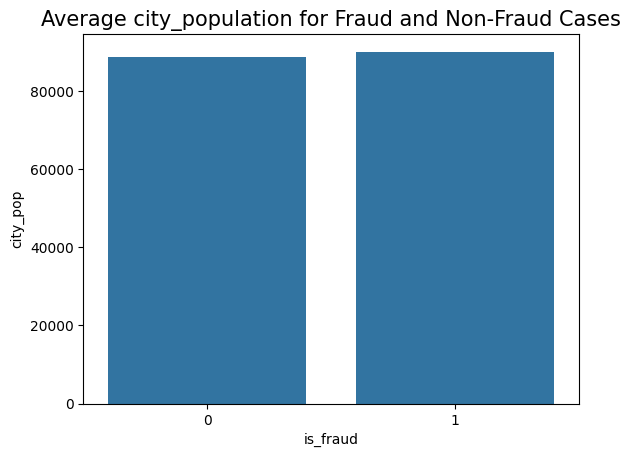

T-test: t-statistic = 0.443, p-value = 0.658, p-value<0.05? False


In [27]:
sns.barplot(data=df_total,x='is_fraud', y='city_pop', ci=None)
plt.title('Average city_population for Fraud and Non-Fraud Cases',fontsize=15)
plt.show()

fraud_population = df_total[df_total['is_fraud'] == 1]['city_pop']
non_fraud_population = df_total[df_total['is_fraud'] == 0]['city_pop']
t_stat, p_value = ttest_ind(fraud_population, non_fraud_population)
print(f'T-test: t-statistic = {round(t_stat,3)}, p-value = {round(p_value,3)}, p-value<0.05? {p_value<0.05}')



In [ ]:
#Como aceitamos a hipótese nula(p-val > 0.05), concluímos que não há diferença significativa entre as médias.
#Concluímos também que city_pop não nos ajuda no alvo (is_fraud), então o descartaremos.

In [29]:
# Dropando colunas desnecessarias
colunas_excluir = ['unix_time','city_pop','first','last']
df_total = Limpa_df(df_total, colunas_excluir)

df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,dob,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.01,-82.05,0,0.00,Sem distância
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.16,-118.19,0,30.21,0 a 50 km
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.15,-112.15,0,0.00,Sem distância
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.03,-112.56,0,95.67,50 a 100 km
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.67,-78.63,0,77.56,50 a 100 km


In [30]:
#clean merchant column
df_total['merchant'] = df_total['merchant'].apply(lambda x : x.replace('fraud_',''))
df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,dob,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.01,-82.05,0,0.00,Sem distância
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.16,-118.19,0,30.21,0 a 50 km
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.15,-112.15,0,0.00,Sem distância
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.03,-112.56,0,95.67,50 a 100 km
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.67,-78.63,0,77.56,50 a 100 km


# 3.2 Tempo entre transações 

* A variável horas_entre_transacoes representa o intervalo de tempo, em horas, entre transações consecutivas de um mesmo cartão de crédito. Ela foi criada para analisar o comportamento temporal das transações, para identificar padrões que possam indicar transações fraudulentas. 


* O teste t indica uma diferença estatisticamente significativa entre o tempo médio entre transações de clientes fraudulentos e não fraudulentos. Com um valor T de 27.27 e um p-valor de 0.00, as transações fraudulentas parecem ter um padrão distinto de tempo em comparação com as não fraudulentas, o que sugere que o tempo entre transações pode ser um fator importante na identificação de comportamentos suspeitos.

* A diferença de média observada sugere que as transações fraudulentas podem ocorrer em intervalos de tempo consideravelmente diferentes — mais curtos, neste caso — em relação às transações não fraudulentas.

* Como o p-valor é menor que 0,05, rejeitamos a hipótese nula. Isso confirma que a média do intervalo em horas entre transações é significativamente diferente entre transações fraudulentas e não fraudulentas.

           T  p-val
T-test 27.27   0.00


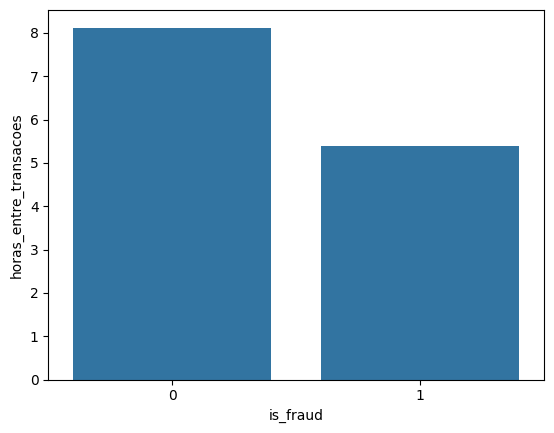

In [ ]:
# Converter 'dob' e 'trans_date...' para datetime
df_total["dob"] = pd.to_datetime(df_total["dob"])
df_total["trans_date_trans_time"] = pd.to_datetime(df_total["trans_date_trans_time"])

#We will get the time between transactions for each card
#Time=0 for every first transaction and time will be represented in hours.
df_total.sort_values(['cc_num', 'trans_date_trans_time'],inplace=True)
df_total['horas_entre_transacoes']=((df_total.groupby('cc_num')[['trans_date_trans_time']].diff())/np.timedelta64(1,'h'))


df_total.loc[df_total['horas_entre_transacoes'].isna(),'horas_entre_transacoes'] = 0
df_total['horas_entre_transacoes'] = df_total['horas_entre_transacoes'].astype(int)


# x_0=df.groupby('is_fraud')['horas_entre_transacoes'].mean().values[0]
# x_1=df.groupby('is_fraud')['horas_entre_transacoes'].mean().values[1]
# std_0=df.groupby('is_fraud')['horas_entre_transacoes'].std().values[0]
# std_1=df.groupby('is_fraud')['horas_entre_transacoes'].std().values[1]
# n_0=df.groupby('is_fraud')['horas_entre_transacoes'].count().values[0]
# n_1=df.groupby('is_fraud')['horas_entre_transacoes'].count().values[1]
# numerator = x_0 - x_1
# domin = np.sqrt(std_0**2/n_0 + std_1**2/n_1)
# t_stat=numerator/domin
# p_val = 2*(1-t.cdf(abs(t_stat),df=n_0+n_1-2))
# print(t_stat,p_val)
#----------------------
#The power of pingouin library!
print(pingouin.ttest(df_total[df_total['is_fraud'] == 0]['horas_entre_transacoes'],
              df_total[df_total['is_fraud'] == 1]['horas_entre_transacoes'],
              alternative='two-sided')[['T','p-val']])
sns.barplot(data=df_total,x='is_fraud',y='horas_entre_transacoes',ci=None)
plt.show()

In [32]:

df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,dob,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,horas_entre_transacoes
98e3dcf98101146a577f85a34e58feec,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,1986-02-17,98e3dcf98101146a577f85a34e58feec,43.97,-109.74,0,0.00,Sem distância,0
498120fc45d277f7c88e3dba79c33865,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,1986-02-17,498120fc45d277f7c88e3dba79c33865,42.02,-109.04,0,110.31,100 a 120 km,19
95f514bb993151347c7acdf8505c3d62,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,1986-02-17,95f514bb993151347c7acdf8505c3d62,42.96,-109.16,0,21.79,0 a 50 km,0
4f0c1a14e0aa7eb56a490780ef9268c5,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,1986-02-17,4f0c1a14e0aa7eb56a490780ef9268c5,42.23,-108.75,0,0.00,Sem distância,3
3b2ebd3af508afba959640893e1e82bc,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,1986-02-17,3b2ebd3af508afba959640893e1e82bc,43.32,-108.09,0,0.00,Sem distância,0


# 3.3 Idade 

* A variável age foi criada para representar a idade do titular do cartão no momento de cada transação. Ela é calculada a partir da diferença entre o ano da transação e o ano de nascimento, evitando distorções que poderiam ocorrer ao usar a data atual. Após a criação da variável age, a coluna de data de nascimento (dob) foi removida, pois já não era mais necessária para a análise.

In [33]:
#transformar variaveis com transformacao relevante (inicialmente) no dicionario de dados CONTINUAR

#calculando a idade
#usando a diferenca entre o nascimento e o momento da transacao para evitar distorcoes (usar a data atual criaria uma idade flutuante ao longo do tempo)
df_total["age"] = df_total.apply(lambda linha: linha["trans_date_trans_time"].year - linha["dob"].year, axis=1) #funcao lambda "linha" que aplica a subtracao de datas linha a linha no df_total atraves do apply()

#remove data de nascimento, nao e mais util
df_total.drop(columns=["dob"], inplace=True)

df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,horas_entre_transacoes,age
98e3dcf98101146a577f85a34e58feec,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,98e3dcf98101146a577f85a34e58feec,43.97,-109.74,0,0.00,Sem distância,0,33
498120fc45d277f7c88e3dba79c33865,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,498120fc45d277f7c88e3dba79c33865,42.02,-109.04,0,110.31,100 a 120 km,19,33
95f514bb993151347c7acdf8505c3d62,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,95f514bb993151347c7acdf8505c3d62,42.96,-109.16,0,21.79,0 a 50 km,0,33
4f0c1a14e0aa7eb56a490780ef9268c5,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,4f0c1a14e0aa7eb56a490780ef9268c5,42.23,-108.75,0,0.00,Sem distância,3,33
3b2ebd3af508afba959640893e1e82bc,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,3b2ebd3af508afba959640893e1e82bc,43.32,-108.09,0,0.00,Sem distância,0,33


# 3.4 Codigo do Banco (BIN)

* A variável bin foi criada para representar o código do banco da transação, extraído dos primeiros 6 dígitos do número do cartão (cc_num). Essa informação é importante para identificar a instituição financeira associada à transação.

In [34]:
df_total["bin"] = df_total["cc_num"].astype(str).str[:6]
df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,horas_entre_transacoes,age,bin
98e3dcf98101146a577f85a34e58feec,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,98e3dcf98101146a577f85a34e58feec,43.97,-109.74,0,0.00,Sem distância,0,33,604162
498120fc45d277f7c88e3dba79c33865,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,498120fc45d277f7c88e3dba79c33865,42.02,-109.04,0,110.31,100 a 120 km,19,33,604162
95f514bb993151347c7acdf8505c3d62,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,95f514bb993151347c7acdf8505c3d62,42.96,-109.16,0,21.79,0 a 50 km,0,33,604162
4f0c1a14e0aa7eb56a490780ef9268c5,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,4f0c1a14e0aa7eb56a490780ef9268c5,42.23,-108.75,0,0.00,Sem distância,3,33,604162
3b2ebd3af508afba959640893e1e82bc,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,3b2ebd3af508afba959640893e1e82bc,43.32,-108.09,0,0.00,Sem distância,0,33,604162


# 3.5 features período e horário

* As variáveis relacionadas ao horário da transação foram extraídas para fornecer uma análise mais detalhada do momento da transação. A coluna day_of_week indica o dia da semana em que a transação ocorreu (0 para segunda-feira, 6 para domingo), e a coluna month representa o mês da transação. A coluna time contém o horário completo (hora:minuto:segundo) da transação.

* Além disso, a variável period classifica o horário da transação em períodos do dia, como "Madrugada Início", "Manhã Final", "Tarde Início", entre outros, com base na hora extraída da transação. Essas informações podem ser úteis para analisar padrões de comportamento de transações ao longo do tempo.

In [35]:
# extraindo variaveis do horario da transacao

# Certificando que a coluna 'trans_date_trans_time' está no formato datetime
df_total['trans_date_trans_time'] = pd.to_datetime(df_total['trans_date_trans_time'])

# Extraindo o dia da semana (0=segunda, 1=terça, ..., 6=domingo)
df_total['day_of_week'] = df_total['trans_date_trans_time'].dt.dayofweek

# Extraindo o mês
df_total['month'] = df_total['trans_date_trans_time'].dt.month

# Extraindo o horário completo (hora:minuto:segundo)
df_total['time'] = df_total['trans_date_trans_time'].dt.strftime('%H:%M:%S')


def classify_period(hour):
    if 0 <= hour < 3:
        return 'Madrugada Início'
    elif 3 <= hour < 6:
        return 'Madrugada Final'
    elif 6 <= hour < 9:
        return 'Manhã Início'
    elif 9 <= hour < 12:
        return 'Manhã Final'
    elif 12 <= hour < 15:
        return 'Tarde Início'
    elif 15 <= hour < 18:
        return 'Tarde Final'
    elif 18 <= hour < 21:
        return 'Noite Início'
    elif 21 <= hour < 24:
        return 'Noite Final'


# Extraindo a hora da transação
df_total['hour'] = df_total['trans_date_trans_time'].dt.hour

# Aplicando a função para classificar o período
df_total['period'] = df_total['hour'].apply(classify_period)

df_total.head(5)


,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,horas_entre_transacoes,age,bin,day_of_week,month,time,hour,period
98e3dcf98101146a577f85a34e58feec,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,98e3dcf98101146a577f85a34e58feec,43.97,-109.74,0,0.00,Sem distância,0,33,604162,1,1,12:47:15,12,Tarde Início
498120fc45d277f7c88e3dba79c33865,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,498120fc45d277f7c88e3dba79c33865,42.02,-109.04,0,110.31,100 a 120 km,19,33,604162,2,1,08:44:57,8,Manhã Início
95f514bb993151347c7acdf8505c3d62,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,95f514bb993151347c7acdf8505c3d62,42.96,-109.16,0,21.79,0 a 50 km,0,33,604162,2,1,08:47:36,8,Manhã Início
4f0c1a14e0aa7eb56a490780ef9268c5,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,4f0c1a14e0aa7eb56a490780ef9268c5,42.23,-108.75,0,0.00,Sem distância,3,33,604162,2,1,12:38:14,12,Tarde Início
3b2ebd3af508afba959640893e1e82bc,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00,-108.90,Information systems manager,3b2ebd3af508afba959640893e1e82bc,43.32,-108.09,0,0.00,Sem distância,0,33,604162,2,1,13:10:46,13,Tarde Início


# 3.6 Feature de quantidade de transações em um periodo de tempo

A variável "count_tran_ult_jan_temp" foi criada para contar o número de transações realizadas nos últimos 15 segundos antes de cada transação, com o objetivo de identificar comportamentos suspeitos e padrões de fraudes, como transações seguidas rapidamente. O cálculo considera cada transação e verifica o número de transações anteriores realizadas, para cada cartao, dentro desse intervalo de 15 segundos. Isso pode ajudar a detectar transações fraudulentas que ocorrem em um curto período de tempo.

Os testes indicam uma diferença estatística significativa no número de transações realizadas nos últimos 15 segundos entre transações fraudulentas e não fraudulentas. Com um valor T de -5.55 e um p-valor de 0.00, observamos que as transações fraudulentas tendem a ocorrer com um número menor de transações consecutivas dentro desse intervalo curto, em comparação com as transações não fraudulentas. Isso sugere que o comportamento de transações em intervalos breves pode ser um indicativo de fraude, sendo uma característica distintiva entre os dois grupos.

Como o p-valor é menor que 0,05, rejeitamos a hipótese nula. Isso confirma que a contagem de transações nos últimos 15 segundos é significativamente diferente entre transações fraudulentas e não fraudulentas.

           T  p-val
T-test -5.55   0.00


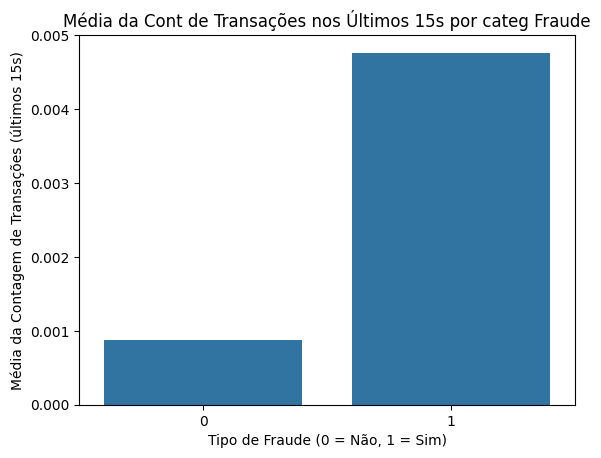

,index,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,horas_entre_transacoes,age,bin,day_of_week,month,time,hour,period,count_tran_ult_jan_temp
trans_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0b242abb623afc578575680df30655b9,0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,"Psychologist, counselling",36.01,-82.05,0,0.00,Sem distância,0,31,270318,1,1,00:00:18,0,Madrugada Início,0
1f76529f8574734946361c461b024d99,1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,Special educational needs teacher,49.16,-118.19,0,30.21,0 a 50 km,0,41,630423,1,1,00:00:44,0,Madrugada Início,0
a1a22d70485983eac12b5b88dad1cf95,a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,Nature conservation officer,43.15,-112.15,0,0.00,Sem distância,0,57,388594,1,1,00:00:51,0,Madrugada Início,0
6b849c168bdad6f867558c3793159a81,6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,Patent attorney,47.03,-112.56,0,95.67,50 a 100 km,0,52,353409,1,1,00:01:16,0,Madrugada Início,0
a41d7549acf90789359a9aa5346dcb46,a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,Dance movement psychotherapist,38.67,-78.63,0,77.56,50 a 100 km,0,33,375534,1,1,00:03:06,0,Madrugada Início,0


In [ ]:
# Converter para datetime e ordenar
df_total['trans_date_trans_time'] = pd.to_datetime(df_total['trans_date_trans_time'])
df_total = df_total.sort_values(by=['trans_date_trans_time', 'cc_num'])

# Resetar o índice temporariamente para permitir o uso com numpy (evita erro com string como índice)
df_total_reset = df_total.reset_index()  # trans_num vira coluna

# Criar array para armazenar a contagem
trans_count_list = np.zeros(len(df_total_reset), dtype=int)

# Aplicar a contagem eficiente usando searchsorted()
for card, group in df_total_reset.groupby('cc_num'):
    timestamps = group['trans_date_trans_time'].values
    idx = np.searchsorted(timestamps, timestamps - np.timedelta64(15, 's'), side='left')
    trans_count_list[group.index] = np.arange(len(group)) - idx

# Atribuir os valores ao DataFrame
df_total_reset['count_tran_ult_jan_temp'] = trans_count_list

# Restaurar o índice original 'trans_num'
df_total = df_total_reset.set_index('trans_num')



#validando logica (comparar as horas entre as transacoes e se a quantidade bate)
#df_filtro = df_total[df_total['cc_num'] == 	4613314721966]
#df_filtro = df_filtro[df_filtro['is_fraud'] == 1	]

#df_filtro = df_filtro.sort_values(by='trans_date_trans_time', ascending=False)  # Ordenar do maior para o menor

#df_filtro.head(1000)



'''
# Considerando que a variável 'count_tran_ult_jan_temp' foi criada para contar as transações nos últimos 15 segundos
# Usando o código estatístico para comparar as médias entre as categorias de is_fraud (0 = Não, 1 = Sim)

# Calculando as médias e desvio padrão para as duas categorias de is_fraud
x_0 = df_total[df_total['is_fraud'] == 0]['count_tran_ult_jan_temp'].mean()  # Média para 'Não Fraude'
x_1 = df_total[df_total['is_fraud'] == 1]['count_tran_ult_jan_temp'].mean()  # Média para 'Fraude'

std_0 = df_total[df_total['is_fraud'] == 0]['count_tran_ult_jan_temp'].std()  # Desvio padrão para 'Não Fraude'
std_1 = df_total[df_total['is_fraud'] == 1]['count_tran_ult_jan_temp'].std()  # Desvio padrão para 'Fraude'

n_0 = df_total[df_total['is_fraud'] == 0]['count_tran_ult_jan_temp'].count()  # Contagem para 'Não Fraude'
n_1 = df_total[df_total['is_fraud'] == 1]['count_tran_ult_jan_temp'].count()  # Contagem para 'Fraude'

# Cálculo do valor t e p-valor
numerator = x_0 - x_1
denominator = np.sqrt(std_0**2 / n_0 + std_1**2 / n_1)
t_stat = numerator / denominator

# Graus de liberdade
df = n_0 + n_1 - 2
p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))

# Exibindo t_stat e p_val
print(f"t-statistic: {t_stat}, p-value: {p_val}")

'''

#-----------------------------
# Usando a biblioteca Pingouin para realizar o teste t
ttest_result = pingouin.ttest(
    df_total[df_total['is_fraud'] == 0]['count_tran_ult_jan_temp'],
    df_total[df_total['is_fraud'] == 1]['count_tran_ult_jan_temp'],
    alternative='two-sided'
)

# Exibindo resultado do teste
print(ttest_result[['T', 'p-val']])

# Gráfico de barras para visualizar a contagem de transações por tipo de fraude
sns.barplot(data=df_total, x='is_fraud', y='count_tran_ult_jan_temp', ci=None)
plt.title('Média da Cont de Transações nos Últimos 15s por categ Fraude')
plt.xlabel('Tipo de Fraude (0 = Não, 1 = Sim)')
plt.ylabel('Média da Contagem de Transações (últimos 15s)')
plt.show()

df_total.head(5)





# 3.7 Feature de uso do cartao 

* Variável de Frequência de Uso do Cartão foi criada com base na quantidade de vezes que cada cartão foi utilizado ao longo de todo o período da amostra. O objetivo dessa variável é medir a frequência de uso do cartão e verificar se cartões com menor frequência de uso (como cartões novos ou pouco utilizados) estão mais associados a transações fraudulentas.

* A análise mostra que as fraudes ocorrem com maior frequência em cartões com baixo número de utilizações, indicando um padrão mais comum em cartões novos ou pouco usados. Já as transações genuínas apresentam uma distribuição mais próxima da normalidade em relação à frequência de uso dos cartões.

* classe_frequencia_cartao e uma categorizacao com base na Frequência de uso. 

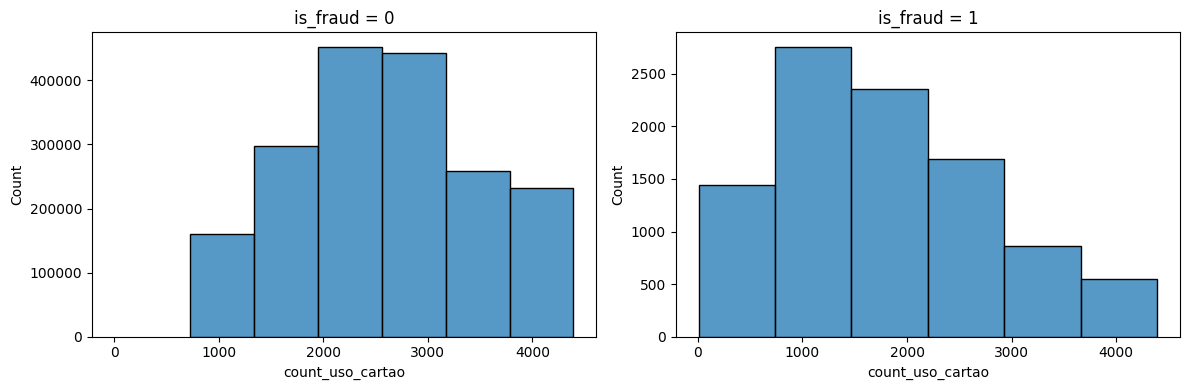

Categorias únicas: [4 6 1 2 3 5]


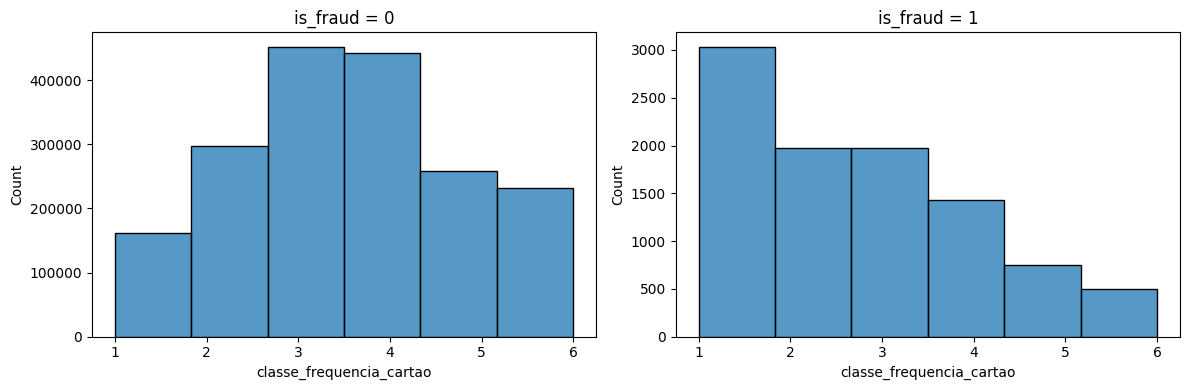

In [ ]:

# Função para exibir histogramas lado a lado
def hist_show(col):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    for i in [0, 1]:
        sns.histplot(df_total[df_total["is_fraud"] == i][col], bins=6, ax=axs[i])
        axs[i].set_title(f'is_fraud = {i}')
    plt.tight_layout()
    plt.show()

# Contar quantas vezes cada cartão aparece na base
df_qtd_uso_cartoes = df_total.groupby('cc_num').size().reset_index(name='count_uso_cartao')

# Juntar essa informação de volta ao DataFrame original
df_total = df_total.merge(df_qtd_uso_cartoes, on='cc_num', how='left')

# Mostrar histograma da contagem original
hist_show('count_uso_cartao')

# Função para classificar o uso do cartão em faixas
def class_det(x):
    for idx, val in enumerate(range(800, 5000, 800)):
        if x < val:
            return idx + 1
    return len(range(800, 5000, 800)) + 1  # Classe extra se acima de 5000

# Criar variável categórica
df_total['classe_frequencia_cartao'] = df_total['count_uso_cartao'].apply(class_det)

#  Verificar as classes únicas
print("Categorias únicas:", df_total['classe_frequencia_cartao'].unique())

#  Exibir histograma da variável categorizada
hist_show('classe_frequencia_cartao')



# Define o índice novamente (foi desconfigurado nos processos anteriores)
df_total.set_index("index", inplace=True)

df_total.index.name = None #tira o cabecalho da variavel da primeira linha do df


#Aplica def de reorganizar colunas 
df_total = mover_target_para_final(df_total, 'is_fraud')

# 3.8 Transformação de Horário em Variáveis Cíclicas (Seno e Cosseno)
 
A variável time, que representa o horário da transação, possui natureza cíclica, ou seja, após 23:59 o ciclo recomeça em 00:00. Modelos de Machine Learning não entendem esse padrão circular por padrão, e tratam 23h e 0h como distantes, quando na verdade são muito próximas.

Para capturar essa ciclicidade corretamente, transformamos a hora em duas novas variáveis usando funções trigonométricas:

time_sin = sin(2π * hora / 24)

time_cos = cos(2π * hora / 24)

Essas variáveis projetam o horário em um círculo unitário, permitindo que o modelo entenda a transição natural entre horários e aprenda padrões temporais com mais precisão.

Essa técnica é especialmente útil em modelos lineares, onde relações cíclicas não são captadas automaticamente.

* tambem e feita para o mes do ano 

In [38]:

# Converter a coluna 'time' de string para datetime.time
df_total['time'] = pd.to_datetime(df_total['time'], format='%H:%M:%S').dt.time

# Extrair a hora, minuto e segundo como número decimal de hora
df_total['hora_decimal'] = df_total['time'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

# Codificação cíclica: seno e cosseno da hora do dia
df_total['time_sin'] = np.sin(2 * np.pi * df_total['hora_decimal'] / 24)
df_total['time_cos'] = np.cos(2 * np.pi * df_total['hora_decimal'] / 24)

# Codificação cíclica: seno e cosseno  mês do ano (1 a 12)
df_total['month_sin'] = np.sin(2 * np.pi * df_total['month'] / 12)
df_total['month_cos'] = np.cos(2 * np.pi * df_total['month'] / 12)


#dropando variavel 'time' apos transformaca, caso ela seja necessaia para calcular o tempo entre trnasacoes (se essa variavel for viabilizada, esta em analise se faz sentido) 
#basta comentar essa parte do codigo que ela se mantem 

# Dropando colunas desnecessarias
colunas_excluir = ['time','hora_decimal']  #hora_decimal foi somente para clcular o sen e cos 
df_total = Limpa_df(df_total, colunas_excluir)


#visualizando nova feature
pd.set_option('display.max_rows', None)
df_total.head(10)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,merch_lat,merch_long,distancia_km,faixa_distancia,horas_entre_transacoes,age,bin,day_of_week,month,hour,period,count_tran_ult_jan_temp,count_uso_cartao,classe_frequencia_cartao,is_fraud,time_sin,time_cos,month_sin,month_cos
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,"Psychologist, counselling",36.01,-82.05,0.00,Sem distância,0,31,270318,1,1,0,Madrugada Início,0,2927,4,0,0.00,1.00,0.50,0.87
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,Special educational needs teacher,49.16,-118.19,30.21,0 a 50 km,0,41,630423,1,1,0,Madrugada Início,0,4362,6,0,0.00,1.00,0.50,0.87
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,Nature conservation officer,43.15,-112.15,0.00,Sem distância,0,57,388594,1,1,0,Madrugada Início,0,735,1,0,0.00,1.00,0.50,0.87
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,Patent attorney,47.03,-112.56,95.67,50 a 100 km,0,52,353409,1,1,0,Madrugada Início,0,743,1,0,0.01,1.00,0.50,0.87
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,Dance movement psychotherapist,38.67,-78.63,77.56,50 a 100 km,0,33,375534,1,1,0,Madrugada Início,0,2922,4,0,0.01,1.00,0.50,0.87
189a841a0a8ba03058526bcfe566aab5,2019-01-01 00:04:08,4767265376804500,"Stroman, Hudson and Erdman",gas_transport,94.63,F,4655 David Island,Dublin,PA,18917,40.38,-75.20,Transport planner,40.65,-76.15,85.92,50 a 100 km,0,58,476726,1,1,0,Madrugada Início,0,736,1,0,0.02,1.00,0.50,0.87
83ec1cc84142af6e2acf10c44949e720,2019-01-01 00:04:42,30074693890476,Rowe-Vandervort,grocery_net,44.54,F,889 Sarah Station Suite 624,Holcomb,KS,67851,37.99,-100.99,Arboriculturist,37.16,-100.15,0.00,Sem distância,0,26,300746,1,1,0,Madrugada Início,0,2933,4,0,0.02,1.00,0.50,0.87
6d294ed2cc447d2c71c7171a3d54967c,2019-01-01 00:05:08,6011360759745864,Corwin-Collins,gas_transport,71.65,M,231 Flores Pass Suite 720,Edinburg,VA,22824,38.84,-78.60,"Designer, multimedia",38.95,-78.54,12.77,0 a 50 km,0,72,601136,1,1,0,Madrugada Início,0,1464,2,0,0.02,1.00,0.50,0.87
fc28024ce480f8ef21a32d64c93a29f5,2019-01-01 00:05:18,4922710831011201,Herzog Ltd,misc_pos,4.27,F,6888 Hicks Stream Suite 954,Manor,PA,15665,40.34,-79.66,Public affairs consultant,40.35,-79.96,25.27,0 a 50 km,0,78,492271,1,1,0,Madrugada Início,0,1470,2,0,0.02,1.00,0.50,0.87
3b9014ea8fb80bd65de0b1463b00b00e,2019-01-01 00:06:01,2720830304681674,"Schoen, Kuphal and Nitzsche",grocery_pos,198.39,F,21326 Taylor Squares Suite 708,Clarksville,TN,37040,36.52,-87.35,Pathologist,37.18,-87.49,74.08,50 a 100 km,0,45,272083,1,1,0,Madrugada Início,0,1467,2,0,0.03,1.00,0.50,0.87


# Analisando alguns pontos antes de modelar 

* verificando os tipos das variaveis e a contagem de categorias das categoricas 
    * das 3 categoricas e possivel notar que a vartaivel bin que corresponde ao codigo do suposto banco de cada transacao, tem muitas categorias (muitos bancos) isso torna inviavel one hot encoder
    * Entao na celula seguinte, foi verificado dos bancos mais ofensores em percentual de fraudes por transacao, para encontrar algum padrao 
    * Dado isso, será aplicada uma transformação de Target Encoding (neste caso, Mean Encoding), que substitui cada categoria de bin pela média do target (proporção média de fraude) dentro daquela categoria. 
        * Para evitar overfitting e vazamento de dados, a codificação será aplicada separadamente dentro de cada fold durante a validação cruzada e, posteriormente, no conjunto de teste de forma independente. 
        * Além disso, será utilizado o parâmetro smoothing, que atua como uma forma de regularização. O smoothing realiza um balanceamento entre a média do target por categoria e a média global do target, dando mais peso à média global em categorias com poucas observações. Isso ajuda a suavizar os valores atribuídos a categorias raras e reduz o risco de superestimar seu efeito, tornando o modelo mais robusto.

In [39]:

# VERIFICANDO OS TIPOS PARA POSSIVEL TRANSFORMACAO 
print(df_total.dtypes)

print('')
# Selecionar colunas do tipo object
object_cols = df_total.select_dtypes(include='object').columns

# Contar categorias únicas em cada uma
for col in object_cols:
    print(f"{col}: {df_total[col].nunique()} categorias únicas")



trans_date_trans_time       datetime64[ns]
cc_num                               int64
merchant                            object
category                            object
amt                                float64
gender                              object
street                              object
city                                object
state                               object
zip                                  int64
lat                                float64
long                               float64
job                                 object
merch_lat                          float64
merch_long                         float64
distancia_km                       float64
faixa_distancia                   category
horas_entre_transacoes               int64
age                                  int64
bin                                 object
day_of_week                          int32
month                                int32
hour                                 int32
period     

In [40]:
# Agrupamento por bin com os indicadores
resumo_bin = (
    df_total
    .groupby('bin')
    .agg(
        proporcao_fraude=('is_fraud', 'mean'),
        contagem_fraude=('is_fraud', 'sum'),
        total_transacoes=('is_fraud', 'count')
    )
    .reset_index()
    .sort_values(by='proporcao_fraude', ascending=False)
)

# Auemntar para uns 100 para ver a quebra dos bancos mais ofensores em percentual
resumo_bin.head(10) 


,bin,proporcao_fraude,contagem_fraude,total_transacoes
27,180098,1.00,12,12
4,180020,1.00,12,12
26,180097,1.00,7,7
7,180038,1.00,10,10
960,676179,1.00,11,11
259,352804,1.00,11,11
603,441767,1.00,11,11
299,354733,1.00,11,11
283,354041,1.00,8,8
922,651777,1.00,11,11


In [41]:
# Dropando colunas desnecessarias
#hour sai porque ja foi criada variaveis ciclicas com  Sen e Cos 
colunas_excluir = ['lat', 'long', 'merch_lat', 'merch_long','cc_num','hour']
df_total = Limpa_df(df_total, colunas_excluir)
df_total.head()

,trans_date_trans_time,merchant,category,amt,gender,street,city,state,zip,job,distancia_km,faixa_distancia,horas_entre_transacoes,age,bin,day_of_week,month,period,count_tran_ult_jan_temp,count_uso_cartao,classe_frequencia_cartao,is_fraud,time_sin,time_cos,month_sin,month_cos
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,"Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,"Psychologist, counselling",0.00,Sem distância,0,31,270318,1,1,Madrugada Início,0,2927,4,0,0.00,1.00,0.50,0.87
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,Special educational needs teacher,30.21,0 a 50 km,0,41,630423,1,1,Madrugada Início,0,4362,6,0,0.00,1.00,0.50,0.87
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,Nature conservation officer,0.00,Sem distância,0,57,388594,1,1,Madrugada Início,0,735,1,0,0.00,1.00,0.50,0.87
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,Patent attorney,95.67,50 a 100 km,0,52,353409,1,1,Madrugada Início,0,743,1,0,0.01,1.00,0.50,0.87
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,Dance movement psychotherapist,77.56,50 a 100 km,0,33,375534,1,1,Madrugada Início,0,2922,4,0,0.01,1.00,0.50,0.87


# 4 Modelagem 

* aqui inicia-se algumas pre-analises e selecao de features e depois a modelagem em si 

# 4.1 Divisao treino e teste

In [ ]:

X = df_total.drop('is_fraud', axis=1)
y = df_total['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Dropa as variáveis indesejadas em treino e teste
cols_to_drop = ['trans_date_trans_time', 'cc_num']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')
X  = X.drop(columns=cols_to_drop, errors='ignore')


print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Total shape:", X.shape, y.shape)

print("Checagem duplicidade entre conjuntos:", set(X_train.index) & set(X_test.index))  

# Junta X_train e y_train para uso no Optuna
df_train = X_train.copy()
df_train['is_fraud'] = y_train

target = 'is_fraud'



print('Distribuicao Geral das classes :', y.value_counts(normalize=True).map('{:.4%}'.format))
print('Distribuicao das classes em Treino:', y_train.value_counts(normalize=True).map('{:.4%}'.format) )
print('Distribuicao das classes em Teste:', y_test.value_counts(normalize=True).map('{:.4%}'.format) )

Train shape: (1296675, 24) (1296675,)
Test shape: (555719, 24) (555719,)
Total shape: (1852394, 24) (1852394,)
Checagem duplicidade entre conjuntos: set()
Distribuicao Geral das classes : is_fraud
0    99.4790%
1     0.5210%
Name: proportion, dtype: object
Distribuicao das classes em Treino: is_fraud
0    99.4790%
1     0.5210%
Name: proportion, dtype: object
Distribuicao das classes em Teste: is_fraud
0    99.4791%
1     0.5209%
Name: proportion, dtype: object


# 4.2 Analisando correlacoes 

* Analisando correlacoes 
    * a funcao aqui aplica as mesmas transformacoes que sao aplicadas no treino e no teste, mas com uma funcao separada para deixar as usadas no modelo somente para o modelo 
    * e feita uam copia do df_treino para preservar o df_treino do modelo. 

* Definindo funcoes transformadoras nas variaveis que serao usadas para feature importance, analise de correlacoes e fornecidas finalmente para o modelo 

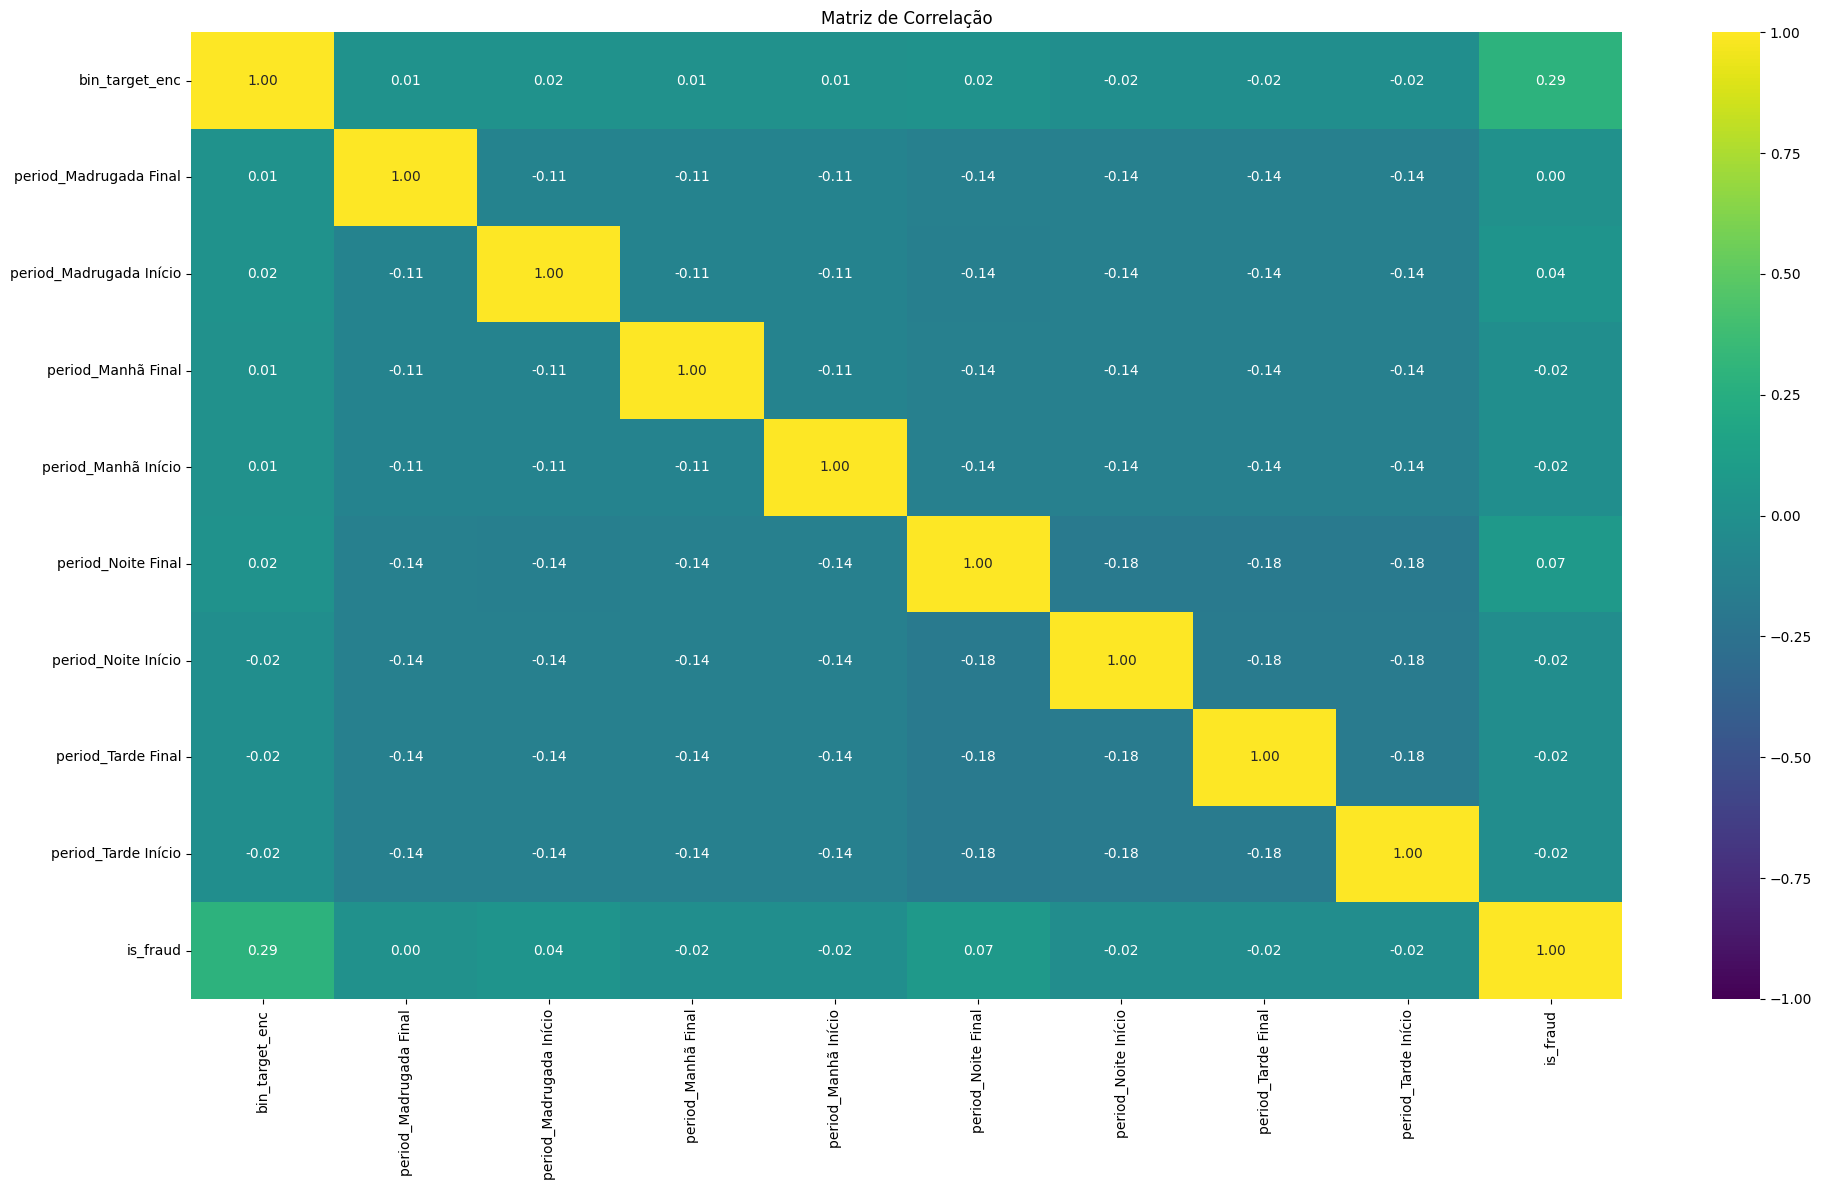

In [ ]:

def prepare_df_train_temp(df_train, target):

    '''funcoes transformadoras aplicadas somente dentro dessa def 
    (os tratamentos oficiais acontecem dentro dos pipelines)'''

    
    #  Target Encoding
    def apply_target_encoding(train, val_or_test, col, target, smoothing=15):
        global_mean = train[target].mean()
        stats = train.groupby(col)[target].agg(['mean', 'count'])
        smooth = (stats['mean'] * stats['count'] + global_mean * smoothing) / (stats['count'] + smoothing)
        encoded_col = val_or_test[col].map(smooth).fillna(global_mean)
        return encoded_col

    
      # One-Hot Encoding para colunas categóricas
    
    def fit_transform_ohe(train_df, val_df, col):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        train_encoded = ohe.fit_transform(train_df[[col]])
        val_encoded = ohe.transform(val_df[[col]])

        train_ohe = pd.DataFrame(train_encoded, columns=[f"{col}_{cat}" for cat in ohe.categories_[0]], index=train_df.index)
        val_ohe = pd.DataFrame(val_encoded, columns=[f"{col}_{cat}" for cat in ohe.categories_[0]], index=val_df.index)

        return train_ohe, val_ohe, ohe

    # Cria uma cópia para preservar o original
    df_train_temp = df_train.copy()
    

    #  Target Encoding 
    df_train_temp['bin_target_enc'] = apply_target_encoding(df_train, df_train_temp, 'bin', target)

    #  OneHot Encoding 
    #_, ohe_cat_df, ohe_cat = fit_transform_ohe(df_train, df_train_temp, 'category')
    _, ohe_period_df, ohe_period = fit_transform_ohe(df_train, df_train_temp, 'period')

    #  Junta todas as features 
    #X_temp = pd.concat([df_train_temp[['bin_target_enc']], ohe_cat_df, ohe_period_df], axis=1)
    X_temp = pd.concat([df_train_temp[['bin_target_enc']], ohe_period_df], axis=1)

    #  Scaling 
    scaler = StandardScaler()
    X_temp_scaled = scaler.fit_transform(X_temp)

    # Retorna como DataFrame para análise de correlação
    X_temp_scaled_df = pd.DataFrame(X_temp_scaled, columns=X_temp.columns, index=df_train_temp.index)
    X_temp_scaled_df[target] = df_train_temp[target]  # anexa target para facilitar análise

    return X_temp_scaled_df




#chamando def 
df_train_temp = prepare_df_train_temp(df_train, target)


# Suprimir todos os warnings
warnings.filterwarnings("ignore")

# Criar a figura com 1 subgráfico (apenas o gráfico de correlação)
fig, axes = plt.subplots(1, 1, figsize=(20, 12))

# Matriz de correlação
sns.heatmap(df_train_temp.corr(), annot=True, cmap="viridis", fmt=".2f", ax=axes, vmin=-1, vmax=1)
axes.set_title('Matriz de Correlação')

# Ajustar o layout
plt.tight_layout()
plt.show()



# 4.3 Importancias das variaveis com Mutual Information

* aqui tem um ranking de variaveis caso queria as x features mais importantes, mas acabei nao aplicando nenhum filtro no modelo final, foram todas e foram tratadas dentro do pipeline

In [45]:
df_train.head(5)

,merchant,category,amt,gender,street,city,state,zip,job,distancia_km,faixa_distancia,horas_entre_transacoes,age,bin,day_of_week,month,period,count_tran_ult_jan_temp,count_uso_cartao,classe_frequencia_cartao,time_sin,time_cos,month_sin,month_cos,is_fraud
9006071a5e8236bb033f9b2ca5e90d87,"Streich, Hansen and Veum",gas_transport,62.29,F,9412 Harris Mews,O Brien,TX,79539,Warden/ranger,70.63,50 a 100 km,7,37,382956,5,10,Madrugada Final,0,2930,4,0.90,0.44,-0.87,0.50,0
ac2d8ed507b62698aa5c344f1c1f9c88,Stiedemann Inc,misc_pos,5.56,M,428 Michael Tunnel Apt. 377,Cleveland,AL,35049,Aid worker,25.47,0 a 50 km,3,42,414963,4,11,Noite Início,0,2917,4,-0.98,0.22,-0.50,0.87,0
cd4a1a4fe9a5de2e49fd1f9ffdd7d956,Botsford Ltd,shopping_pos,9.90,F,03090 Fisher Forges Apt. 200,Wichita,KS,67216,Textile designer,21.08,0 a 50 km,55,90,356024,2,8,Manhã Final,0,735,1,0.49,-0.87,-0.87,-0.50,0
2cb6aeed31669f676c1789e3d44f6553,"Lubowitz, Terry and Stracke",personal_care,6.29,M,841 Cheryl Centers Suite 115,Farmington,NY,14425,Cytogeneticist,104.09,100 a 120 km,3,67,351489,6,3,Tarde Final,0,2190,3,-1.00,-0.01,1.00,0.00,0
12881b494567a8f8eaee4db02b73eedc,"Turcotte, McKenzie and Koss",entertainment,20.71,F,4529 Cannon Alley,Center Point,WV,26339,Chief Executive Officer,0.00,Sem distância,0,49,676298,1,7,Tarde Início,0,2192,3,-0.67,-0.75,-0.50,-0.87,0


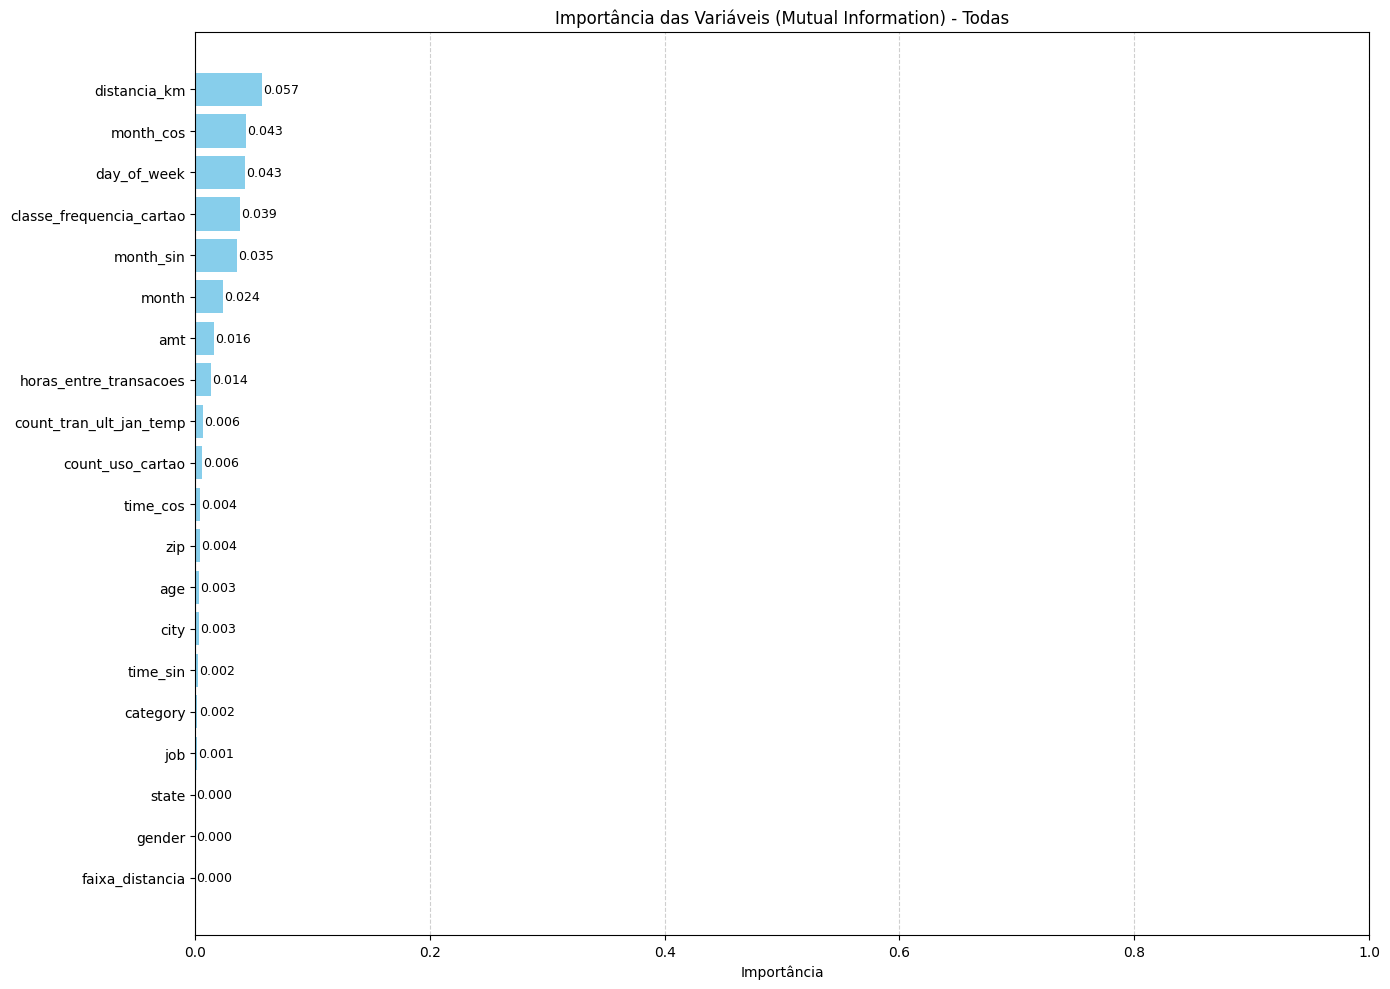

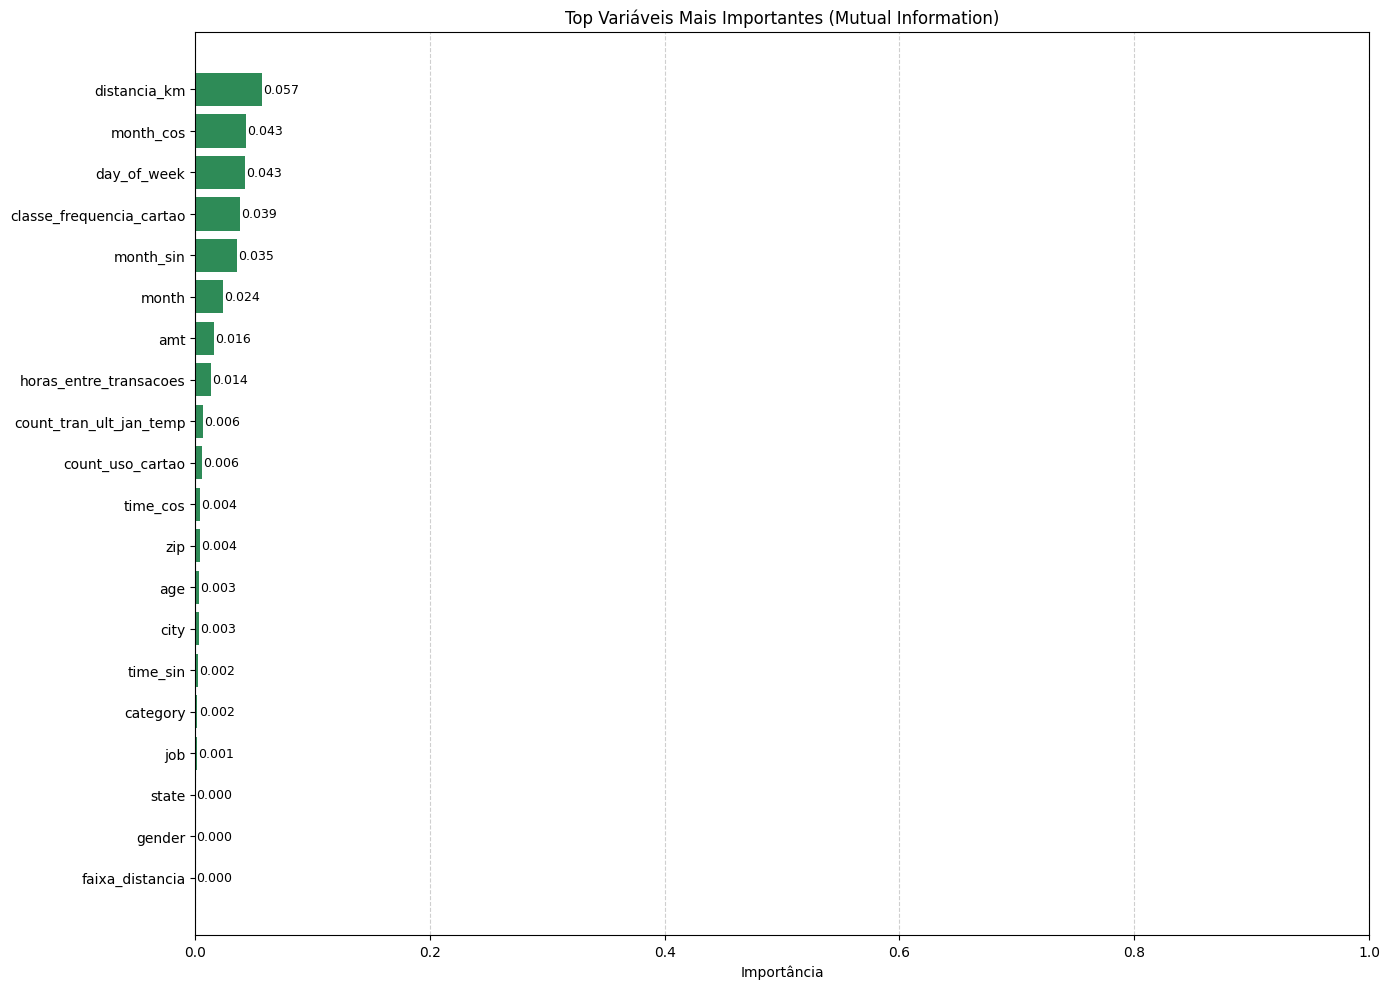

In [ ]:

warnings.filterwarnings("ignore")

# Cópia da base original
df_temp = df_train.copy()

# Define as variáveis obrigatórias que sempre ficam
keep_vars = ['bin', 'period', target, 'merchant', 'street']  # Variáveis obrigatórias

# Define X e y novamente
X = df_temp.drop(columns=keep_vars, errors='ignore')  # Remover as variáveis de keep_vars
y = df_temp[target]

# Separa as variáveis categóricas e numéricas
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
#print(cat_cols)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
#print(num_cols)


# Garante que X já está sem as keep_vars
X_mi = X.copy()
y = df_temp[target]

# Recalcula as colunas categóricas e numéricas (sem keep_vars)
cat_cols_mi = X_mi.select_dtypes(exclude=[np.number]).columns.tolist()
num_cols_mi = X_mi.select_dtypes(include=[np.number]).columns.tolist()

# Codifica variáveis categóricas com OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_mi[cat_cols_mi] = encoder.fit_transform(X_mi[cat_cols_mi])

# Normaliza variáveis numéricas
scaler = StandardScaler()
X_mi[num_cols_mi] = scaler.fit_transform(X_mi[num_cols_mi])

# Calcula Mutual Information
mi = mutual_info_classif(
    X_mi,
    y,
    discrete_features=[col in cat_cols_mi for col in X_mi.columns],
    random_state=42
)

# Organiza os resultados
mi_importances = pd.Series(mi, index=X_mi.columns, name="MutualInformation")

# Seleciona as top 30 variáveis mais importantes
top = mi_importances.sort_values(ascending=False).head(30).index.tolist()

# Atualiza df_train com as top variáveis + variáveis obrigatórias
df_train = df_temp[top + keep_vars]



# 📊 Gráfico com todas as variáveis numéricas
plt.figure(figsize=(14, 10))
mi_sorted = mi_importances.sort_values(ascending=True)
bars = plt.barh(mi_sorted.index, mi_sorted.values, color='skyblue')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
             va='center', fontsize=9)

plt.title("Importância das Variáveis (Mutual Information) - Todas")
plt.xlabel("Importância")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 📊 Gráfico com apenas as top variáveis
plt.figure(figsize=(14, 10))
top_sorted = mi_importances[top].sort_values(ascending=True)
bars_top = plt.barh(top_sorted.index, top_sorted.values, color='seagreen')

for bar in bars_top:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
             va='center', fontsize=9)

plt.title("Top Variáveis Mais Importantes (Mutual Information)")
plt.xlabel("Importância")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [146]:
#df_train.head(5)

# 4.4 Analise de Outliers 

* AQUI SE ANALISOU OS OUTLIERS PARA TRATAMENTOS POSTERIOES, DENTRO DOS FOLDS, NO TREINAMENTO FINAL, E SEMPRE OBSERVANDO O CUIDADO PARA VAZAMENTO DE DADOS ENTRE TREINO E TESTE. 



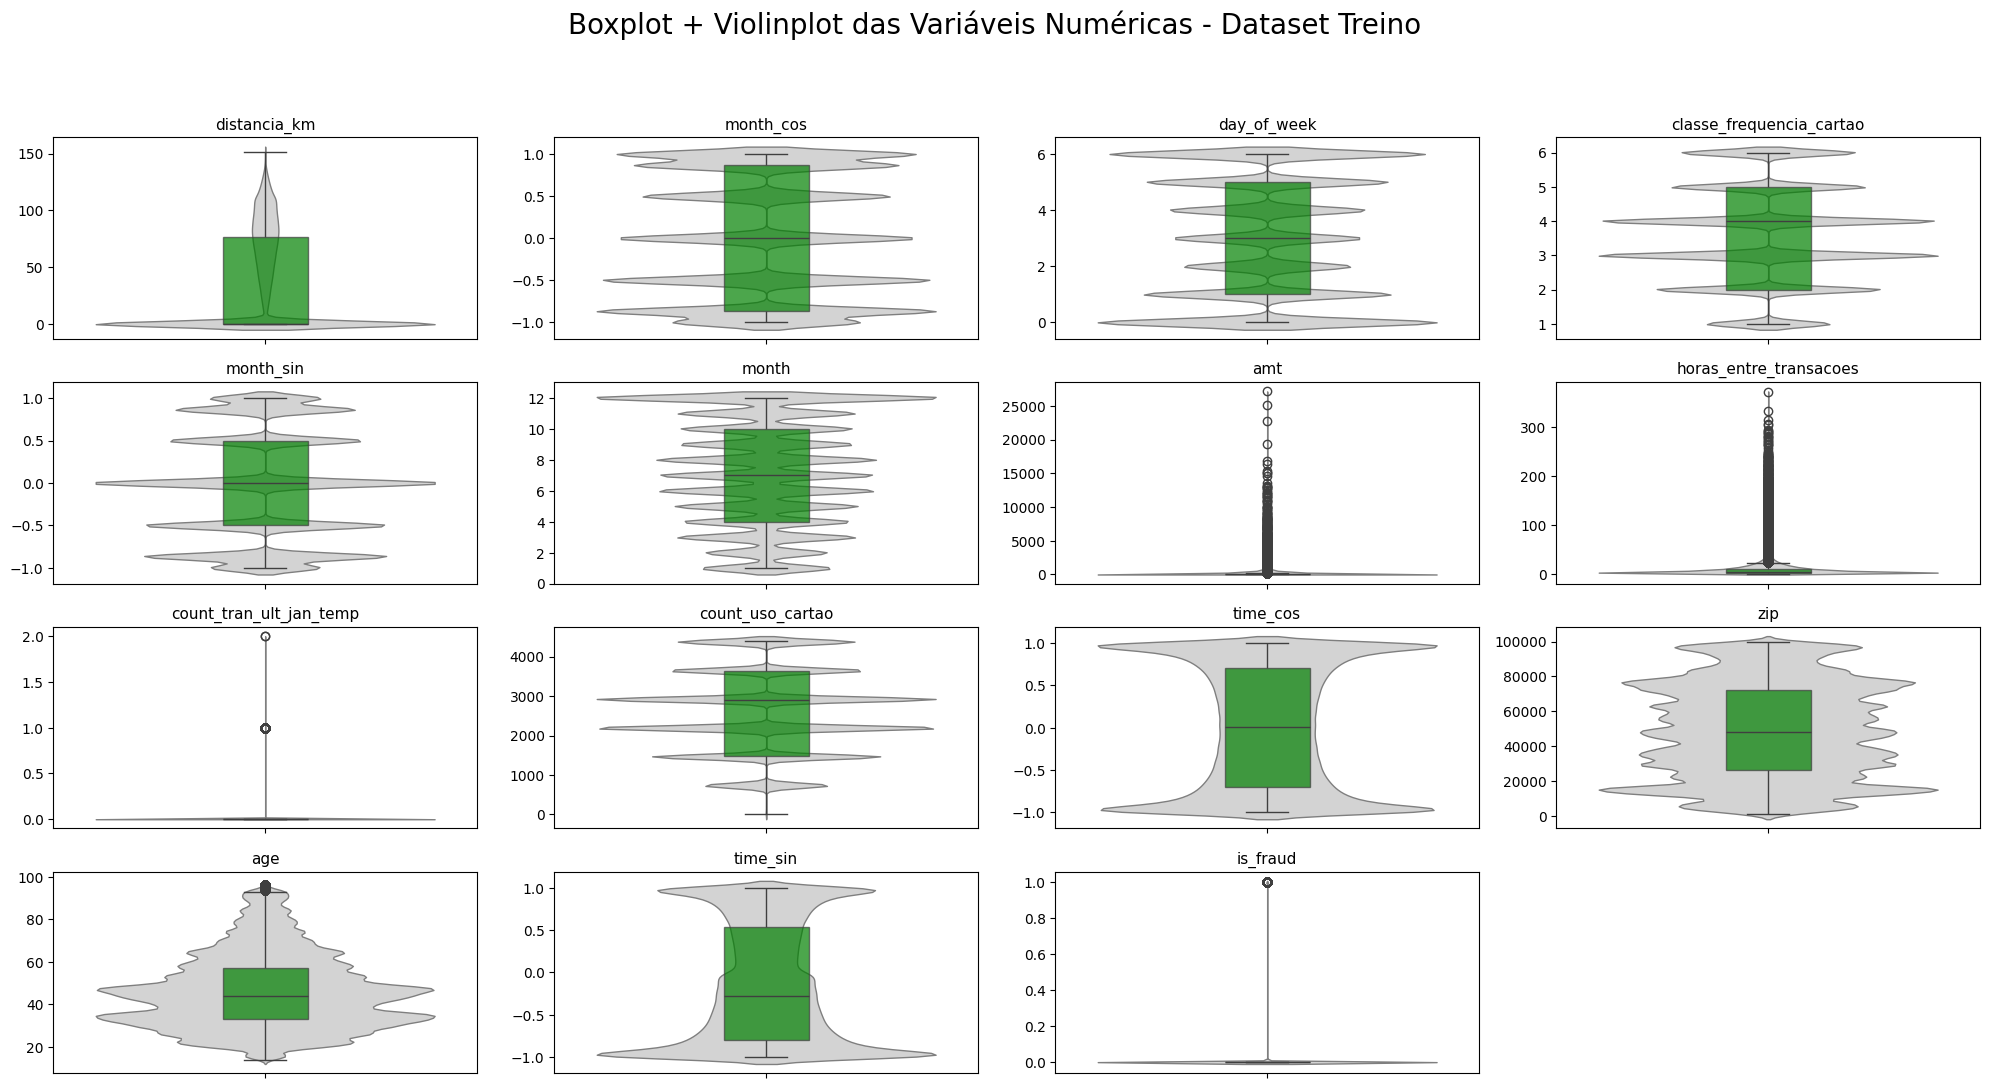

In [ ]:

# lista das variáveis numéricas que você quer visualizar
variaveis = df_train.select_dtypes(include='number').columns.tolist()

# tamanho da figura
plt.figure(figsize=(20, 16))

# loop de criação de subplots com boxplot + violinplot
for i, var in enumerate(variaveis):
    plt.subplot(6, 4, i + 1)  # define a grade de 6 linhas x 4 colunas (ajuste conforme o número de variáveis)
    
    # violinplot com largura menor para não sobrepor tanto
    sns.violinplot(y=df_train[var], inner=None, color='lightgray', linewidth=1)
    
    # boxplot por cima
    sns.boxplot(y=df_train[var],
                boxprops=dict(facecolor='green', alpha=0.7),
                width=0.2)
    
    plt.title(f'{var}', fontsize=11)
    plt.ylabel('')

# título geral
plt.suptitle('Boxplot + Violinplot das Variáveis Numéricas - Dataset Treino', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# 4.5 Testando Normalidade 

In [49]:
print("qtd de variaveis e observacoes usados no treino(aqui tem a target ainda):",df_train.shape)

qtd de variaveis e observacoes usados no treino(aqui tem a target ainda): (1296675, 25)


In [ ]:
'''Mantendo apenas as colunas presentes em df_train
 isso porque as tratativas de mutual importance foram feitos na copia do df_train e isso ocorreu depois da separacao de treino e teste, entao e a unica transformcao que acabou nao pegando no X_trian e X_test
 isso e so um filtro de seguranca, como foram usadas todas variaveis sem selecao de importancia, acabou que nao fez diferenca, mas caso um dia se aplique uma selecao o codigo deve entender 
 '''
colunas_validas = df_train.columns.intersection(X_train.columns)

# Filtrando X_train e X_test
X_train = X_train[colunas_validas]
X_test = X_test[colunas_validas]


In [51]:
X_train.shape

(1296675, 24)


📊 Analisando a variável: distancia_km
--------------------------------------------------
Estatística do teste (D’Agostino): 1032082.0824
p-valor: 0.0000
❌ Pode não seguir uma distribuição normal.
Estatística do teste Anderson-Darling: 120022.0164
Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
Níveis de significância: [15.  10.   5.   2.5  1. ]
❌ A distribuição não é normal.
Assimetria (Skew): 0.6123
Curtose (Kurtosis): -1.1798

📊 Analisando a variável: month_cos
--------------------------------------------------
Estatística do teste (D’Agostino): 6891471.6377
p-valor: 0.0000
❌ Pode não seguir uma distribuição normal.
Estatística do teste Anderson-Darling: 60430.9630
Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
Níveis de significância: [15.  10.   5.   2.5  1. ]
❌ A distribuição não é normal.
Assimetria (Skew): 0.0528
Curtose (Kurtosis): -1.5533

📊 Analisando a variável: day_of_week
--------------------------------------------------
Estatística do teste (D’Agostino): 8845511.25

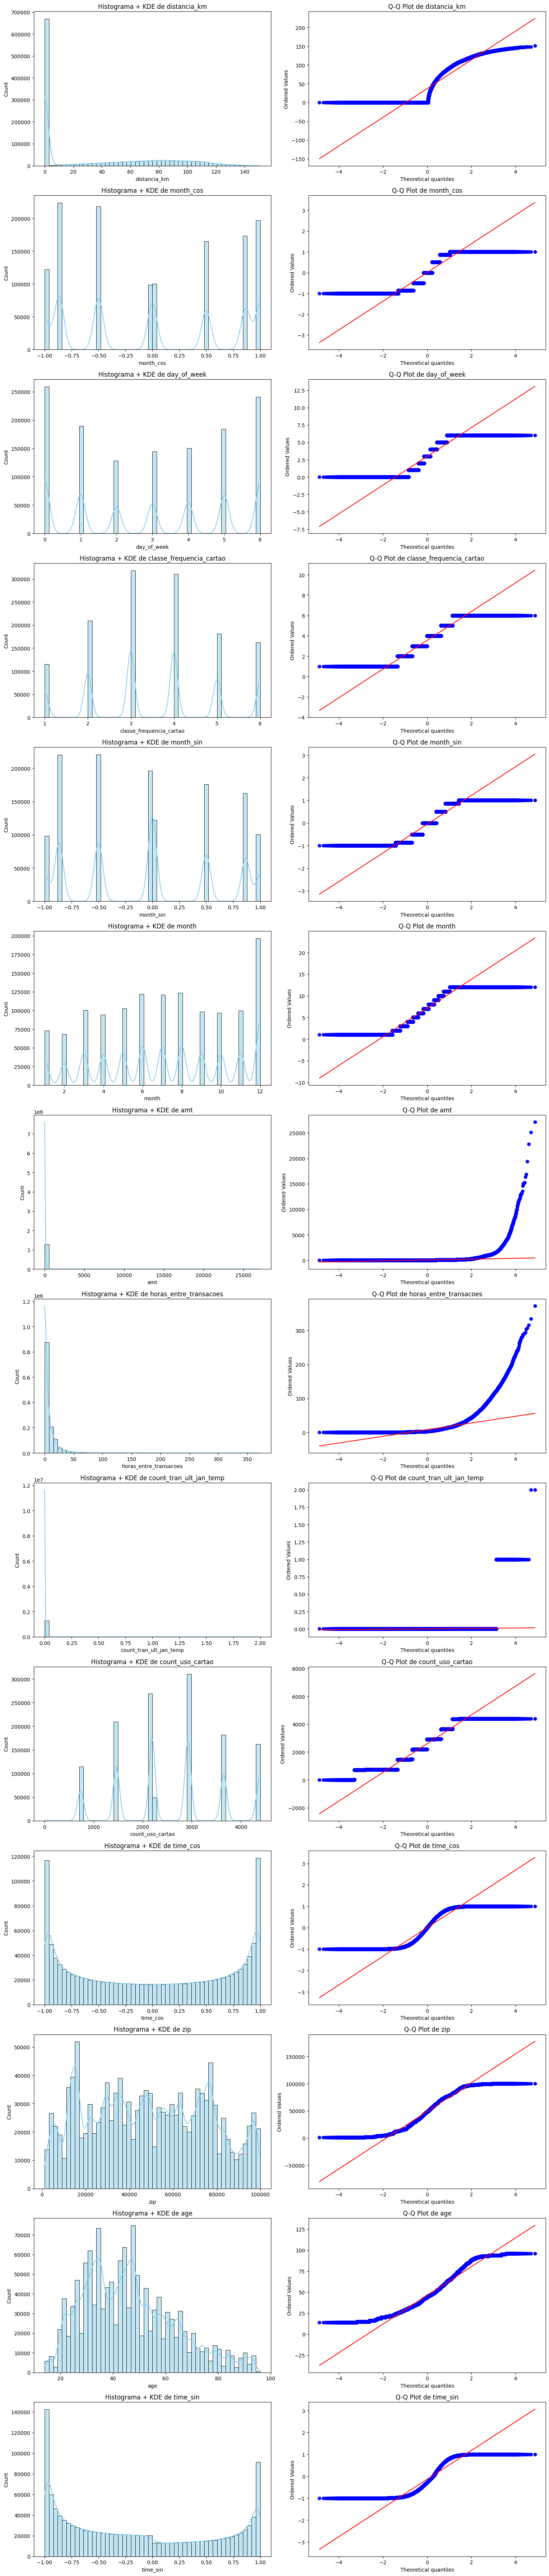

In [ ]:
#testando a normalidade dados colunas numericas, 

numerical_cols = X_train.select_dtypes(include='number').columns.tolist() #lista de variaveis numericas


def analisar_normalidade(df, colunas):

    ''' 
    Funcao que analisa as variaveis numericas antes das trasnformacoes, principalmente para determinar qual tratamento de outlier
    sera necessario no momento das transformacoes do pipeline para essas varaiveis e a determinacao disso na classe de transformacao
    de outlier. Alem de melhorar a compreensao das variaveis.  

    '''
    n_cols = 2  # Número de colunas para os gráficos
    n_rows = (len(colunas) * 2 + 1) // n_cols  # Ajusta o número de linhas para acomodar todos os gráficos

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()  # Flatten para facilitar a indexação dos subgráficos

    for i, col in enumerate(colunas):
        ax_hist = axes[2 * i]  # Posição do histograma + KDE
        ax_qq = axes[2 * i + 1]  # Posição do Q-Q plot

        print(f"\n📊 Analisando a variável: {col}")
        print("-" * 50)
        
        # Teste de D’Agostino e Pearson
        try:
            stat, p_value = stats.normaltest(df[col].dropna())
            print(f"Estatística do teste (D’Agostino): {stat:.4f}")
            print(f"p-valor: {p_value:.4f}")
            if p_value > 0.05:
                print("✅ Parece seguir uma distribuição normal.")
            else:
                print("❌ Pode não seguir uma distribuição normal.")
        except Exception as e:
            print(f"Erro ao executar o teste D’Agostino: {e}")
            continue

        # Teste Anderson-Darling
        try:
            result = stats.anderson(df[col].dropna())
            print(f"Estatística do teste Anderson-Darling: {result.statistic:.4f}")
            print("Valores Críticos:", result.critical_values)
            print("Níveis de significância:", result.significance_level)
            if result.statistic < result.critical_values[2]:
                print("✅ Distribuição normal (nível de significância de 5%).")
            else:
                print("❌ A distribuição não é normal.")
        except Exception as e:
            print(f"Erro ao executar o teste Anderson-Darling: {e}")
            continue

        # Cálculo de skew (assimetria) e kurtosis (curtose)
        skew = df[col].dropna().skew()
        kurtosis = df[col].dropna().kurtosis()
        print(f"Assimetria (Skew): {skew:.4f}")
        print(f"Curtose (Kurtosis): {kurtosis:.4f}")

        # Plot Histograma + KDE
        sns.histplot(df[col].dropna(), kde=True, bins=50, color='skyblue', ax=ax_hist)
        ax_hist.set_title(f"Histograma + KDE de {col}")

        # Q-Q Plot
        stats.probplot(df[col].dropna(), dist="norm", plot=ax_qq)
        ax_qq.set_title(f"Q-Q Plot de {col}")

    # Ajustar layout
    plt.tight_layout()
    plt.show()


#analisando 
analisar_normalidade(X_train, numerical_cols)





# 4.5 Determinando Classes para o Pipeline e separando listas de tratamento

In [ ]:

'''AQUI MUITA ATENCAO, AO ALTERAR QUALQUER CLASSE DEVE-SE COPIAR E COLAR NO custom_transformers.py 
    ELE E USADO PARA A APLICAR O MODELO ATRAVES DO PKL DO MODELO NO FINAL E GERAR AS ANALISES DE VIES DAS DECISOES 
    E INTERPRETABILIDADE DO MODELO

    POR ISSO ATE AS LIBS FORAM DEIXADAS AQUI PARA SIMILARIDADE COM O custom_transformers.py 
'''

# Importando as bibliotecas necessárias
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, OrdinalEncoder
from category_encoders.woe import WOEEncoder
import pandas as pd
import numpy as np


# Classe para transformar com Target Encoder
class TargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapping_ = None

    def fit(self, X, y):
        col = X.columns[0]
        self.mapping_ = X[col].to_frame().join(pd.Series(y, name='target')).groupby(col)['target'].mean()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        col = X.columns[0]
        X_transformed[col] = X_transformed[col].map(self.mapping_)
        X_transformed[col].fillna(0, inplace=True)
        return X_transformed


# Classe para transformação One Hot Encoder
class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self

    def transform(self, X):
        encoded = self.encoder.transform(X)
        col_names = self.encoder.get_feature_names_out(X.columns)
        return pd.DataFrame(encoded, columns=col_names, index=X.index)


# Classe para transformação Yeo-Johnson
class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variaveis=None):
        """
        Classe para aplicar a transformação Yeo-Johnson nas variáveis específicas.

        A transformação Yeo-Johnson é uma técnica estatística utilizada para estabilizar a variância e tornar os dados mais próximos de uma distribuição normal. 
        Diferente da Box-Cox, ela permite valores negativos e zero, ampliando seu uso. 
        É especialmente útil para melhorar o desempenho de modelos que assumem normalidade.

        param variaveis: lista de variáveis para aplicar a transformação. Se None, aplica a todas as variáveis numéricas.
        """
        self.variaveis = variaveis
        self.transformer = PowerTransformer(method='yeo-johnson', standardize=False)  # Yeo-Johnson sem padronização
    
    def fit(self, X, y=None):
        """
        Ajusta o transformer nas variáveis especificadas.
        :param X: DataFrame com os dados de treino.
        :param y: Ignorado (necessário para compatibilidade com pipeline).
        """
        # Se a lista de variáveis for None, aplica a transformação em todas as colunas numéricas
        if self.variaveis is None:
            self.variaveis = X.select_dtypes(include=['number']).columns.tolist()

        # Verifica se todas as variáveis existem no DataFrame
        missing_vars = [var for var in self.variaveis if var not in X.columns]
        if missing_vars:
            raise ValueError(f"As seguintes variáveis não existem no DataFrame: {', '.join(missing_vars)}")

        # Verifica e remove valores ausentes (NaN)
        if X[self.variaveis].isnull().any().any():
            raise ValueError("Existem valores ausentes nas variáveis selecionadas. Por favor, trate-os antes de aplicar a transformação.")
        
        # Ajusta o transformer com os dados das variáveis selecionadas
        self.transformer.fit(X[self.variaveis])
        return self
    
    def transform(self, X):
        """
        Aplica a transformação Yeo-Johnson nas variáveis especificadas.
        :param X: DataFrame com os dados para transformação.
        :return: DataFrame com as variáveis transformadas.
        """
        # Verifica se as variáveis foram previamente definidas
        if not self.variaveis:
            raise ValueError("Nenhuma variável definida para transformação.")
        
        X_transformed = X.copy()

        # Aplica a transformação nas variáveis selecionadas
        X_transformed[self.variaveis] = self.transformer.transform(X[self.variaveis])
        return X_transformed
    
    def fit_transform(self, X, y=None):
        """
        Ajusta e aplica a transformação Yeo-Johnson nas variáveis especificadas.
        :param X: DataFrame com os dados de treino.
        :param y: Ignorado (necessário para compatibilidade com pipeline).
        :return: DataFrame com as variáveis transformadas.
        """
        self.fit(X, y)
        return self.transform(X)


# Classe para flag de outliers com base em percentis
class OutlierPercentilFlagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, limites=(0.01, 0.01)):
        """
        Inicializa o transformador com limites inferiores e superiores para outliers, baseados em percentis.
        
        Parâmetros:
            limites (tuple): Limites inferiores e superiores para identificar outliers com base em percentis (ex: (0.01, 0.01) = 1%).
        """
        self.limites = limites
        self.percentis_ = None

    def fit(self, X, y=None):
        """
        Ajusta o transformador aos dados de entrada, calculando os percentis para cada variável numérica.
        
        Parâmetros:
            X (pd.DataFrame): Dados de entrada para ajuste (não é utilizado no cálculo, mas necessário para o fit).
        
        Retorna:
            self: O próprio transformador.
        """
        # Calculando os percentis para cada variável numérica
        self.percentis_ = {}
        for col in X.select_dtypes(include=[np.number]).columns:
            p_inf = X[col].quantile(self.limites[0])
            p_sup = X[col].quantile(1 - self.limites[1])
            self.percentis_[col] = (p_inf, p_sup)

        return self

    def transform(self, X):
        """
        Transforma os dados de entrada, criando flags binárias para os outliers com base em percentis.
        
        Parâmetros:
            X (pd.DataFrame): Dados a serem transformados, com os quais as flags de outliers serão geradas.
        
        Retorna:
            pd.DataFrame: DataFrame com as novas colunas de outliers adicionadas.
        """
        X_outliers = X.copy()
        
        for col, (p_inf, p_sup) in self.percentis_.items():
            nova_coluna = f'{col}_outlier'
            X_outliers[nova_coluna] = ((X_outliers[col] < p_inf) | (X_outliers[col] > p_sup)).astype(int)
        
        return X_outliers


# Classe para transformação WOE (Weight of Evidence)
class WoeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        """
        cols: lista das colunas para aplicar o WOEEncoder.
        """
        self.cols = cols
        self.encoders_ = {}

    def fit(self, X, y):
        for col in self.cols:
            encoder = WOEEncoder()
            encoder.fit(X[col], y)
            self.encoders_[col] = encoder
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.cols:
            encoder = self.encoders_[col]
            X_transformed[col] = encoder.transform(X_transformed[col])
        return X_transformed


# Classe para transformação Ordinal Encoder
class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OrdinalEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self

    def transform(self, X):
        encoded = self.encoder.transform(X)
        return pd.DataFrame(encoded, columns=X.columns, index=X.index)


* WOEEncoder() transforma variáveis categóricas em valores numéricos com base na razão entre eventos (ex: fraudes) e não eventos, usando log-odds. Quanto maior o valor de WOE, maior a associação com o evento (fraude); quanto menor, maior a associação com a ausência do evento. Como o WOE já tem interpretação estatística, não deve ser normalizado com StandardScaler, pois isso distorce seu significado.

In [54]:
print("Colunas disponíveis em X antes do pipeline:")
for col in X_train.columns:
    print(f"{col} - {X_train[col].dtype}")


Colunas disponíveis em X antes do pipeline:
distancia_km - float64
month_cos - float64
day_of_week - int32
classe_frequencia_cartao - int64
month_sin - float64
month - int32
amt - float64
horas_entre_transacoes - int64
count_tran_ult_jan_temp - int64
count_uso_cartao - int64
time_cos - float64
zip - int64
age - int64
city - object
time_sin - float64
category - object
job - object
state - object
gender - object
faixa_distancia - category
bin - object
period - object
merchant - object
street - object


separando variaveis pelo tipo, para aplicar as transformacaopes especificas em cada lista 

In [ ]:
# Listas organizadas de colunas
woe_cols = ['city', 'job', 'merchant', 'category', 'faixa_distancia']
target_enc_cols = ['bin', 'street', 'zip', 'state'] 
onehot_cols = ['period', 'gender', 'day_of_week']

ordinal_cols = ['classe_frequencia_cartao']

yeojohnson_cols = ['distancia_km','amt', 'horas_entre_transacoes', 'count_tran_ult_jan_temp', 'count_uso_cartao']



numerical_cols_auto = [col for col in numerical_cols if col not in ['zip', 'day_of_week', 'classe_frequencia_cartao', 'time_cos','time_sin','month_sin','month_cos']] #variaveis ja trasnformadas ou sem necessidade de aplicar tranformacoes 
                                                                                                                                                                      #NUMERICAS no pipeline(elas CONTINUAM NO MODELO)
numericas = numerical_cols_auto  


# 4.6 Estudo com Optuna: Melhores hiperparametros & Pipelines

* aqui comeca o estudo, foram estudados 4 modelos 
    * Xgboost, HistGB, MLPC e LogReg 

In [ ]:

warnings.filterwarnings("ignore", message="A module that was compiled using NumPy 1.x cannot be run in NumPy 2.1.3")
 
#reclama por incompatibilidade com aversao do numpy antes e do numpy que o torch usa, se der problema mais pra 
# frente so comentar esse trecho, instalar as lib nas versoes novas e ser feliz 


# Verifica se há GPU disponível
use_gpu = torch.cuda.is_available()
device = "cuda" if use_gpu else "cpu"
tree_method_ = "gpu_hist" if use_gpu else "hist"

print(f"Usando GPU: {use_gpu}")
print(f"Método de árvore: {tree_method_}")

# ==================== Variáveis Globais ==================== 
threshold = 0.5
n_trials_ = 20
n_splits_ = 5

weights_skf = {
    'Accuracy': 0.0,          # Mede a acurácia do modelo nas predicoes
    'f1': 0.15,               # Média harmônica entre precisão e recall (equilíbrio entre recall e precision)
    'precision': 0.30,        # Indica a proporção de positivos corretos (penaliza falsos positivos)
    'recall': 0.40,           # Mede quantos positivos reais foram capturados (importante em fraudes)
    'auc': 0.05,              # Mede a capacidade geral de separação entre classes
    'balanced_acc': 0.0,      # Média das acurácias por classe 
    'mcc': 0.1                # Avalia correlação entre predições e rótulos 
}


# ==================== Função de Geração de Folds e Treinamento ====================

def generate_folds_and_train(trial, X, y, pipeline, n_splits=n_splits_, smote=None):
    global weights_skf  # dicionário com os pesos de cada métrica

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    weighted_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        start_time = time.time()

        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        assert set(X.columns) == set(X_train.columns), "Colunas inconsistentes entre X e os folds!"

        if smote is not None:
            X_train, y_train = smote.fit_resample(X_train, y_train)

        pipeline.fit(X_train, y_train)
        probs = pipeline.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)

        # Métricas individuais
        acc          = accuracy_score(y_val, preds)
        f1           = f1_score(y_val, preds)
        precision    = precision_score(y_val, preds, zero_division=0)
        recall       = recall_score(y_val, preds)
        auc          = roc_auc_score(y_val, probs)
        balanced_acc = balanced_accuracy_score(y_val, preds)
        mcc          = matthews_corrcoef(y_val, preds)

        # Score ponderado (forma explícita)
        fold_weighted_score = (
            weights_skf.get('Accuracy', 0)     * acc +
            weights_skf.get('f1', 0)           * f1 +
            weights_skf.get('precision', 0)    * precision +
            weights_skf.get('recall', 0)       * recall +
            weights_skf.get('auc', 0)          * auc +
            weights_skf.get('balanced_acc', 0) * balanced_acc +
            weights_skf.get('mcc', 0)          * mcc
        )

        weighted_scores.append(fold_weighted_score)

        elapsed = time.time() - start_time
        print(
            f"📁 Fold {fold}/{n_splits} | "
            f"Accuracy: {acc:.4f} | "
            f"F1: {f1:.4f} | "
            f"Precision: {precision:.4f} | "
            f"Recall: {recall:.4f} | "
            f"AUC: {auc:.4f} | "
            f"Balanced Acc: {balanced_acc:.4f} | "
            f"MCC: {mcc:.4f} | "
            f"Weighted Score: {fold_weighted_score:.4f} | "
            f"Tempo: {elapsed:.2f}s"
        )

    # Retorna a média das pontuações ponderadas calculadas para cada fold
    return np.mean(weighted_scores)


# ==================== Funções Objetivo para Cada Modelo ====================



def build_pipeline(model):
    preprocessor = ColumnTransformer(transformers=[

        # WOE apenas nas colunas desejadas
        ('woe', WoeTransformer(cols=woe_cols), woe_cols),
        
        # Target Encoding
        ('target_enc', TargetEncoder(cols=target_enc_cols, smoothing=5), target_enc_cols),
        
        # One-hot encoding
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_cols),
        
        # Ordinal encoding
        ('ordinal', OrdinalEncoderTransformer(), ordinal_cols),

        # Yeo-Johnson nas variáveis numéricas
        ('yeojohnson', YeoJohnsonTransformer(), yeojohnson_cols),
        
        # Flags de outliers com base em percentis
        ('outliers_percentil', OutlierPercentilFlagTransformer(limites=(0.01, 0.01)), numericas),

        # Scaler aplicado apenas nas variáveis numéricas
        ('scaler', StandardScaler(), numericas)
    ])
    
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    
    return pipeline







# =======================
#  XGBoost Objective
# =======================
def objective_xgb(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para XGBoost...")

    model = XGBClassifier(
        objective='binary:logistic',
        tree_method=trial.suggest_categorical("tree_method", ["gpu_hist"]),
        #use_label_encoder=False, #Evita warning especfico de versoes antigas
        eval_metric=trial.suggest_categorical("eval_metric", ["aucpr", "logloss"]),
        n_estimators=trial.suggest_int("n_estimators", 300, 1000),
        learning_rate=trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        min_child_weight=trial.suggest_float("min_child_weight", 10, 100),
        subsample=trial.suggest_float("subsample", 0.6, 0.9),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 0.9),
        gamma=trial.suggest_float("gamma", 1, 10),
        reg_alpha=trial.suggest_float("reg_alpha", 1, 10),
        reg_lambda=trial.suggest_float("reg_lambda", 1, 10),
        scale_pos_weight=trial.suggest_float("scale_pos_weight", 1, 10),
        random_state=42,
        n_jobs=-1
    )


    pipeline = build_pipeline(model)

    try:
        score = generate_folds_and_train(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e

# =======================
# HistGradientBoosting Objective
# =======================
def objective_histgb(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para HistGradientBoosting...")

    model = HistGradientBoostingClassifier(
        learning_rate=trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        max_iter=trial.suggest_int("max_iter", 300, 1000),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 10, 100),
        l2_regularization=trial.suggest_float("l2_regularization", 1, 10, log=True),
        max_bins=trial.suggest_int("max_bins", 64, 255),
        early_stopping=False,
        class_weight="balanced",
        random_state=42,
        max_leaf_nodes=trial.suggest_int("max_leaf_nodes", 20, 100)
    )


    pipeline = build_pipeline(model)

    try:
        score = generate_folds_and_train(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e

# =======================
# Logistic Regression Objective
# =======================
def objective_logreg(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para Regressão Logística...")

    model = LogisticRegression(
        penalty=trial.suggest_categorical("penalty", ["l1", "l2"]),
        C=trial.suggest_float("C", 0.1, 2.0, log=True),
        solver=trial.suggest_categorical("solver", ["saga"]),
        l1_ratio= None ,
        max_iter=trial.suggest_int("max_iter", 50, 500),
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )

    pipeline = build_pipeline(model)


    try:
        score = generate_folds_and_train(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e
    

# =======================
# Rede Neural - MLP
# =======================

def objective_NN_MLP(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para MLP...")

    # Defina um dicionário com identificadores de configuração mapeando para tuplas
    hidden_layer_configs = {
        "config_1": (100,),
        "config_2": (250,),
        "config_3": (100, 80)
    }

    # No objetivo do Optuna
    config_key = trial.suggest_categorical("hidden_layer_config", list(hidden_layer_configs.keys()))
    hidden_layer_sizes = hidden_layer_configs[config_key]

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
        solver=trial.suggest_categorical("solver", ["adam"]),
        alpha=trial.suggest_float("alpha", 0.0001, 0.01, log=True),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.005, 0.03, log=True),
        max_iter=trial.suggest_int("max_iter", 50, 300),
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.2,
        random_state=42
    )

    pipeline = build_pipeline(model)

    try:
        score = generate_folds_and_train(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e




models = {
    "NN_MLP":objective_NN_MLP,
    "HistGb": objective_histgb,
    "XGBoost": objective_xgb,
    "LogReg": objective_logreg
    }


# Banco de dados para salvar os estudos
#storage = optuna.storages.RDBStorage(url="sqlite:///Fraud_study_by_optuna.db") # aqui deve ser usado a primeira vez ou rodar esse codigo fora para criar o banco sqlite e depois so chamar o storage (variavel storage descomentada)
storage="sqlite:///Fraud_study_models_by_Optuna.db"




#para ver o dashbord basta usar : 
#optuna-dashboard sqlite:///Fraud_study_by_optuna.db  no terminal e acessar o endereco host que ele devolver via navegador, 
#(olhar o passa a passo em Dashboard_Optuna_observacoes.md)

#precisa esperar pelo menos um dos estudos de modelos passados no dict de modelos terminar para conseguir acessar va navegador, a menos que o estudo ja tenha sido criado anteriormente. 




# Dicionário para salvar os melhores hiperparâmetros
best_hyperparams = {}

def optimize_all_models():
    for model_name, objective_func in models.items():
        print(f"🔍 Iniciando otimização para o modelo: {model_name}")

        # Sampler
        sampler_ = optuna.samplers.TPESampler(
            n_startup_trials=50, 
            n_ei_candidates=20, 
            group=True,
            seed=42,
            multivariate=True
        )

        # Criação do estudo
        study = optuna.create_study(
            study_name=f"{model_name}_study",  # Nome do estudo baseado no modelo
            storage=storage,                   # Banco onde salva
            sampler=sampler_,
            direction='maximize',
            load_if_exists=True                 # Se já existir, continua
        )

        # Otimização
        study.optimize(objective_func, n_trials=n_trials_)

        # Pega melhores parâmetros
        best_params = study.best_params
        best_hyperparams[model_name] = best_params

        # Print dos melhores resultados
        print(f"📊 MELHORES HIPERPARÂMETROS PARA O MODELO {model_name}")
        print("═" * 60)
        for param, value in best_params.items():
            print(f"{param:<25}{str(value):<15}")
        print("═" * 60)

# Roda a função
optimize_all_models()




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

Usando GPU: True
Método de árvore: gpu_hist
🔍 Iniciando otimização para o modelo: NN_MLP


[I 2025-04-28 12:34:47,149] A new study created in RDB with name: NN_MLP_study


🚀 Iniciando trial 0 para MLP...
📁 Fold 1/5 | Accuracy: 0.9957 | F1: 0.3311 | Precision: 0.9161 | Recall: 0.2021 | AUC: 0.8799 | Balanced Acc: 0.6010 | MCC: 0.4292 | Weighted Score: 0.4922 | Tempo: 503.28s
📁 Fold 2/5 | Accuracy: 0.9957 | F1: 0.3892 | Precision: 0.7686 | Recall: 0.2605 | AUC: 0.9102 | Balanced Acc: 0.6301 | MCC: 0.4460 | Weighted Score: 0.4833 | Tempo: 576.48s
📁 Fold 3/5 | Accuracy: 0.9951 | F1: 0.4352 | Precision: 0.5438 | Recall: 0.3627 | AUC: 0.8989 | Balanced Acc: 0.6806 | MCC: 0.4418 | Weighted Score: 0.4626 | Tempo: 501.16s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.4404 | Precision: 0.5790 | Recall: 0.3553 | AUC: 0.9124 | Balanced Acc: 0.6770 | MCC: 0.4514 | Weighted Score: 0.4726 | Tempo: 689.31s


[I 2025-04-28 13:22:34,623] Trial 0 finished with value: 0.4788165791265292 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00020511104188433984, 'learning_rate_init': 0.005548400980049733, 'max_iter': 267}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9957 | F1: 0.3991 | Precision: 0.7480 | Recall: 0.2722 | AUC: 0.9041 | Balanced Acc: 0.6359 | MCC: 0.4497 | Weighted Score: 0.4833 | Tempo: 596.30s
✅ Trial 0 finalizado | Score: 0.4788 | Tempo: 2867.35 segundos
🚀 Iniciando trial 1 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1680 | Precision: 0.9920 | Recall: 0.0918 | AUC: 0.8522 | Balanced Acc: 0.5459 | MCC: 0.3010 | Weighted Score: 0.4322 | Tempo: 676.58s
📁 Fold 2/5 | Accuracy: 0.9959 | F1: 0.3734 | Precision: 0.9375 | Recall: 0.2332 | AUC: 0.9268 | Balanced Acc: 0.6165 | MCC: 0.4665 | Weighted Score: 0.5235 | Tempo: 619.91s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1580 | Precision: 0.9915 | Recall: 0.0859 | AUC: 0.8366 | Balanced Acc: 0.5429 | MCC: 0.2911 | Weighted Score: 0.4264 | Tempo: 592.70s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1780 | Precision: 1.0000 | Recall: 0.0977 | AUC: 0.7760 | Balanced Acc: 0.5489 | MCC: 0.3118 | Weighted Score: 0.4358 | Tempo: 532.10s


[I 2025-04-28 14:11:43,550] Trial 1 finished with value: 0.44668205131637945 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00026587543983272726, 'learning_rate_init': 0.006925598810528835, 'max_iter': 96}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1937 | Precision: 0.8855 | Recall: 0.1087 | AUC: 0.9267 | Balanced Acc: 0.5543 | MCC: 0.3094 | Weighted Score: 0.4155 | Tempo: 527.11s
✅ Trial 1 finalizado | Score: 0.4467 | Tempo: 2948.85 segundos
🚀 Iniciando trial 2 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1644 | Precision: 1.0000 | Recall: 0.0896 | AUC: 0.7851 | Balanced Acc: 0.5448 | MCC: 0.2986 | Weighted Score: 0.4296 | Tempo: 307.28s
📁 Fold 2/5 | Accuracy: 0.9954 | F1: 0.2378 | Precision: 0.8423 | Recall: 0.1384 | AUC: 0.8749 | Balanced Acc: 0.5691 | MCC: 0.3404 | Weighted Score: 0.4215 | Tempo: 310.69s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1580 | Precision: 0.9915 | Recall: 0.0859 | AUC: 0.7768 | Balanced Acc: 0.5429 | MCC: 0.2911 | Weighted Score: 0.4234 | Tempo: 348.46s
📁 Fold 4/5 | Accuracy: 0.9954 | F1: 0.2765 | Precision: 0.7801 | Recall: 0.1680 | AUC: 0.7506 | Balanced Acc: 0.5839 | MCC: 0.3608 | Weighted Score: 0.4163 | Tempo: 303.33s


[I 2025-04-28 14:38:21,412] Trial 2 finished with value: 0.4185803299315345 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00019010245319870352, 'learning_rate_init': 0.008439228148542133, 'max_iter': 141}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.2042 | Precision: 0.8441 | Recall: 0.1161 | AUC: 0.8109 | Balanced Acc: 0.5580 | MCC: 0.3121 | Weighted Score: 0.4021 | Tempo: 327.62s
✅ Trial 2 finalizado | Score: 0.4186 | Tempo: 1597.79 segundos
🚀 Iniciando trial 3 para MLP...
📁 Fold 1/5 | Accuracy: 0.9952 | F1: 0.1619 | Precision: 1.0000 | Recall: 0.0881 | AUC: 0.4723 | Balanced Acc: 0.5440 | MCC: 0.2961 | Weighted Score: 0.4127 | Tempo: 287.65s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1717 | Precision: 0.9922 | Recall: 0.0940 | AUC: 0.7911 | Balanced Acc: 0.5470 | MCC: 0.3047 | Weighted Score: 0.4310 | Tempo: 336.52s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.2473 | Precision: 0.6540 | Recall: 0.1525 | AUC: 0.6627 | Balanced Acc: 0.5760 | MCC: 0.3143 | Weighted Score: 0.3588 | Tempo: 317.16s
📁 Fold 4/5 | Accuracy: 0.9954 | F1: 0.2780 | Precision: 0.7428 | Recall: 0.1710 | AUC: 0.7918 | Balanced Acc: 0.5853 | MCC: 0.3550 | Weighted Score: 0.4080 | Tempo: 320.84s


[I 2025-04-28 15:04:13,131] Trial 3 finished with value: 0.4062858395168355 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001238513729886094, 'learning_rate_init': 0.01485018248624542, 'max_iter': 92}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1739 | Precision: 0.9773 | Recall: 0.0954 | AUC: 0.6582 | Balanced Acc: 0.5477 | MCC: 0.3046 | Weighted Score: 0.4208 | Tempo: 289.01s
✅ Trial 3 finalizado | Score: 0.4063 | Tempo: 1551.65 segundos
🚀 Iniciando trial 4 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1644 | Precision: 1.0000 | Recall: 0.0896 | AUC: 0.5449 | Balanced Acc: 0.5448 | MCC: 0.2986 | Weighted Score: 0.4176 | Tempo: 568.92s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1743 | Precision: 1.0000 | Recall: 0.0955 | AUC: 0.5490 | Balanced Acc: 0.5477 | MCC: 0.3083 | Weighted Score: 0.4226 | Tempo: 554.71s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1581 | Precision: 1.0000 | Recall: 0.0859 | AUC: 0.8663 | Balanced Acc: 0.5429 | MCC: 0.2923 | Weighted Score: 0.4306 | Tempo: 551.37s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1779 | Precision: 0.9925 | Recall: 0.0977 | AUC: 0.8966 | Balanced Acc: 0.5489 | MCC: 0.3107 | Weighted Score: 0.4394 | Tempo: 531.64s


[I 2025-04-28 15:51:35,104] Trial 4 finished with value: 0.4192810794248712 and parameters: {'hidden_layer_config': 'config_3', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001567993391672301, 'learning_rate_init': 0.01703753611652567, 'max_iter': 160}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9951 | F1: 0.0998 | Precision: 1.0000 | Recall: 0.0525 | AUC: 0.5469 | Balanced Acc: 0.5263 | MCC: 0.2286 | Weighted Score: 0.3862 | Tempo: 634.78s
✅ Trial 4 finalizado | Score: 0.4193 | Tempo: 2841.89 segundos
🚀 Iniciando trial 5 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.3418 | Precision: 0.6402 | Recall: 0.2332 | AUC: 0.8941 | Balanced Acc: 0.6162 | MCC: 0.3846 | Weighted Score: 0.4198 | Tempo: 713.12s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1743 | Precision: 1.0000 | Recall: 0.0955 | AUC: 0.9251 | Balanced Acc: 0.5477 | MCC: 0.3083 | Weighted Score: 0.4414 | Tempo: 704.82s
📁 Fold 3/5 | Accuracy: 0.9955 | F1: 0.2398 | Precision: 0.9300 | Recall: 0.1377 | AUC: 0.8441 | Balanced Acc: 0.5688 | MCC: 0.3569 | Weighted Score: 0.4479 | Tempo: 612.24s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1779 | Precision: 0.9925 | Recall: 0.0977 | AUC: 0.9387 | Balanced Acc: 0.5489 | MCC: 0.3107 | Weighted Score: 0.4415 | Tempo: 720.55s


[I 2025-04-28 16:47:45,939] Trial 5 finished with value: 0.45091565732062067 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0021137059440645744, 'learning_rate_init': 0.008740340823059876, 'max_iter': 180}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9954 | F1: 0.4782 | Precision: 0.5909 | Recall: 0.4016 | AUC: 0.9158 | Balanced Acc: 0.7001 | MCC: 0.4850 | Weighted Score: 0.5039 | Tempo: 619.47s
✅ Trial 5 finalizado | Score: 0.4509 | Tempo: 3370.76 segundos
🚀 Iniciando trial 6 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1644 | Precision: 1.0000 | Recall: 0.0896 | AUC: 0.7451 | Balanced Acc: 0.5448 | MCC: 0.2986 | Weighted Score: 0.4276 | Tempo: 279.11s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1743 | Precision: 1.0000 | Recall: 0.0955 | AUC: 0.5250 | Balanced Acc: 0.5477 | MCC: 0.3083 | Weighted Score: 0.4214 | Tempo: 250.96s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1543 | Precision: 0.9912 | Recall: 0.0836 | AUC: 0.5279 | Balanced Acc: 0.5418 | MCC: 0.2872 | Weighted Score: 0.4091 | Tempo: 209.57s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1780 | Precision: 1.0000 | Recall: 0.0977 | AUC: 0.6260 | Balanced Acc: 0.5489 | MCC: 0.3118 | Weighted Score: 0.4283 | Tempo: 217.80s


[I 2025-04-28 17:07:23,409] Trial 6 finished with value: 0.4246589394462627 and parameters: {'hidden_layer_config': 'config_3', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.006161049539380964, 'learning_rate_init': 0.014595756869825135, 'max_iter': 281}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1742 | Precision: 1.0000 | Recall: 0.0954 | AUC: 0.8363 | Balanced Acc: 0.5477 | MCC: 0.3082 | Weighted Score: 0.4369 | Tempo: 219.45s
✅ Trial 6 finalizado | Score: 0.4247 | Tempo: 1177.37 segundos
🚀 Iniciando trial 7 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.2471 | Precision: 0.7463 | Recall: 0.1480 | AUC: 0.7410 | Balanced Acc: 0.5739 | MCC: 0.3311 | Weighted Score: 0.3903 | Tempo: 322.27s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1731 | Precision: 1.0000 | Recall: 0.0947 | AUC: 0.7292 | Balanced Acc: 0.5474 | MCC: 0.3071 | Weighted Score: 0.4310 | Tempo: 340.52s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1580 | Precision: 0.9915 | Recall: 0.0859 | AUC: 0.8136 | Balanced Acc: 0.5429 | MCC: 0.2911 | Weighted Score: 0.4253 | Tempo: 319.31s
📁 Fold 4/5 | Accuracy: 0.9954 | F1: 0.3018 | Precision: 0.7522 | Recall: 0.1887 | AUC: 0.6848 | Balanced Acc: 0.5942 | MCC: 0.3754 | Weighted Score: 0.4182 | Tempo: 296.96s


[I 2025-04-28 17:34:05,107] Trial 7 finished with value: 0.4183464596557549 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00034889766548903674, 'learning_rate_init': 0.022072581716253138, 'max_iter': 139}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1739 | Precision: 0.9773 | Recall: 0.0954 | AUC: 0.7803 | Balanced Acc: 0.5477 | MCC: 0.3046 | Weighted Score: 0.4269 | Tempo: 322.07s
✅ Trial 7 finalizado | Score: 0.4183 | Tempo: 1601.62 segundos
🚀 Iniciando trial 8 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1644 | Precision: 1.0000 | Recall: 0.0896 | AUC: 0.8609 | Balanced Acc: 0.5448 | MCC: 0.2986 | Weighted Score: 0.4334 | Tempo: 274.23s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1743 | Precision: 1.0000 | Recall: 0.0955 | AUC: 0.5477 | Balanced Acc: 0.5477 | MCC: 0.3083 | Weighted Score: 0.4226 | Tempo: 331.00s
📁 Fold 3/5 | Accuracy: 0.9951 | F1: 0.3217 | Precision: 0.5837 | Recall: 0.2221 | AUC: 0.8727 | Balanced Acc: 0.6106 | MCC: 0.3581 | Weighted Score: 0.3916 | Tempo: 264.21s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1780 | Precision: 1.0000 | Recall: 0.0977 | AUC: 0.5489 | Balanced Acc: 0.5489 | MCC: 0.3118 | Weighted Score: 0.4244 | Tempo: 367.80s


[I 2025-04-28 17:59:55,041] Trial 8 finished with value: 0.4188899273719337 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009413993046829943, 'learning_rate_init': 0.01994771878902869, 'max_iter': 99}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1742 | Precision: 1.0000 | Recall: 0.0954 | AUC: 0.5473 | Balanced Acc: 0.5477 | MCC: 0.3082 | Weighted Score: 0.4225 | Tempo: 312.20s
✅ Trial 8 finalizado | Score: 0.4189 | Tempo: 1549.86 segundos
🚀 Iniciando trial 9 para MLP...
📁 Fold 1/5 | Accuracy: 0.9954 | F1: 0.2886 | Precision: 0.7297 | Recall: 0.1799 | AUC: 0.7865 | Balanced Acc: 0.5898 | MCC: 0.3609 | Weighted Score: 0.4096 | Tempo: 432.11s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1897 | Precision: 0.8623 | Recall: 0.1066 | AUC: 0.7411 | Balanced Acc: 0.5532 | MCC: 0.3022 | Weighted Score: 0.3971 | Tempo: 338.64s
📁 Fold 3/5 | Accuracy: 0.9953 | F1: 0.1791 | Precision: 0.9241 | Recall: 0.0992 | AUC: 0.8050 | Balanced Acc: 0.5496 | MCC: 0.3019 | Weighted Score: 0.4142 | Tempo: 320.32s
📁 Fold 4/5 | Accuracy: 0.9954 | F1: 0.3063 | Precision: 0.7186 | Recall: 0.1947 | AUC: 0.8447 | Balanced Acc: 0.5971 | MCC: 0.3725 | Weighted Score: 0.4189 | Tempo: 315.97s


[I 2025-04-28 18:28:42,885] Trial 9 finished with value: 0.4064129399804804 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00014063366777718192, 'learning_rate_init': 0.00950409041508746, 'max_iter': 79}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.2535 | Precision: 0.7367 | Recall: 0.1531 | AUC: 0.7723 | Balanced Acc: 0.5764 | MCC: 0.3345 | Weighted Score: 0.3923 | Tempo: 320.23s
✅ Trial 9 finalizado | Score: 0.4064 | Tempo: 1727.75 segundos
🚀 Iniciando trial 10 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1643 | Precision: 0.9918 | Recall: 0.0896 | AUC: 0.6844 | Balanced Acc: 0.5448 | MCC: 0.2973 | Weighted Score: 0.4220 | Tempo: 85.57s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1737 | Precision: 0.9627 | Recall: 0.0955 | AUC: 0.5483 | Balanced Acc: 0.5477 | MCC: 0.3024 | Weighted Score: 0.4107 | Tempo: 96.11s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1568 | Precision: 0.9914 | Recall: 0.0851 | AUC: 0.7776 | Balanced Acc: 0.5426 | MCC: 0.2898 | Weighted Score: 0.4228 | Tempo: 90.93s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1778 | Precision: 0.9851 | Recall: 0.0977 | AUC: 0.8182 | Balanced Acc: 0.5488 | MCC: 0.3095 | Weighted Score: 0.4331 | Tempo: 99.49s


[I 2025-04-28 18:36:38,137] Trial 10 finished with value: 0.423616325493023 and parameters: {'hidden_layer_config': 'config_1', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0004470608546778491, 'learning_rate_init': 0.018480510518254223, 'max_iter': 210}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1739 | Precision: 0.9773 | Recall: 0.0954 | AUC: 0.8309 | Balanced Acc: 0.5477 | MCC: 0.3046 | Weighted Score: 0.4294 | Tempo: 102.58s
✅ Trial 10 finalizado | Score: 0.4236 | Tempo: 475.20 segundos
🚀 Iniciando trial 11 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1644 | Precision: 1.0000 | Recall: 0.0896 | AUC: 0.8134 | Balanced Acc: 0.5448 | MCC: 0.2986 | Weighted Score: 0.4310 | Tempo: 90.60s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1731 | Precision: 1.0000 | Recall: 0.0947 | AUC: 0.5368 | Balanced Acc: 0.5474 | MCC: 0.3071 | Weighted Score: 0.4214 | Tempo: 99.43s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1580 | Precision: 0.9915 | Recall: 0.0859 | AUC: 0.8175 | Balanced Acc: 0.5429 | MCC: 0.2911 | Weighted Score: 0.4255 | Tempo: 89.54s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1780 | Precision: 1.0000 | Recall: 0.0977 | AUC: 0.7496 | Balanced Acc: 0.5489 | MCC: 0.3118 | Weighted Score: 0.4344 | Tempo: 87.66s


[I 2025-04-28 18:44:14,891] Trial 11 finished with value: 0.4277721722339133 and parameters: {'hidden_layer_config': 'config_1', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0013260331922696556, 'learning_rate_init': 0.019902108036086427, 'max_iter': 173}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1741 | Precision: 0.9923 | Recall: 0.0954 | AUC: 0.6771 | Balanced Acc: 0.5477 | MCC: 0.3070 | Weighted Score: 0.4265 | Tempo: 89.02s
✅ Trial 11 finalizado | Score: 0.4278 | Tempo: 456.68 segundos
🚀 Iniciando trial 12 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.2071 | Precision: 0.9029 | Recall: 0.1170 | AUC: 0.8407 | Balanced Acc: 0.5584 | MCC: 0.3240 | Weighted Score: 0.4231 | Tempo: 278.09s
📁 Fold 2/5 | Accuracy: 0.9960 | F1: 0.4438 | Precision: 0.8313 | Recall: 0.3027 | AUC: 0.9328 | Balanced Acc: 0.6512 | MCC: 0.5003 | Weighted Score: 0.5337 | Tempo: 251.30s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1616 | Precision: 0.9754 | Recall: 0.0881 | AUC: 0.9034 | Balanced Acc: 0.5440 | MCC: 0.2924 | Weighted Score: 0.4265 | Tempo: 267.28s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1780 | Precision: 1.0000 | Recall: 0.0977 | AUC: 0.9044 | Balanced Acc: 0.5489 | MCC: 0.3118 | Weighted Score: 0.4422 | Tempo: 274.05s


[I 2025-04-28 19:06:16,325] Trial 12 finished with value: 0.4505634632729071 and parameters: {'hidden_layer_config': 'config_1', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0018742210985555703, 'learning_rate_init': 0.008781859893937602, 'max_iter': 177}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.2060 | Precision: 0.9128 | Recall: 0.1161 | AUC: 0.8720 | Balanced Acc: 0.5580 | MCC: 0.3247 | Weighted Score: 0.4273 | Tempo: 250.18s
✅ Trial 12 finalizado | Score: 0.4506 | Tempo: 1321.36 segundos
🚀 Iniciando trial 13 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.4565 | Precision: 0.5791 | Recall: 0.3768 | AUC: 0.8863 | Balanced Acc: 0.6877 | MCC: 0.4649 | Weighted Score: 0.4837 | Tempo: 210.11s
📁 Fold 2/5 | Accuracy: 0.9954 | F1: 0.2583 | Precision: 0.8214 | Recall: 0.1532 | AUC: 0.9181 | Balanced Acc: 0.5765 | MCC: 0.3536 | Weighted Score: 0.4277 | Tempo: 255.73s
📁 Fold 3/5 | Accuracy: 0.9957 | F1: 0.3523 | Precision: 0.7927 | Recall: 0.2265 | AUC: 0.9111 | Balanced Acc: 0.6131 | MCC: 0.4224 | Weighted Score: 0.4691 | Tempo: 209.47s
📁 Fold 4/5 | Accuracy: 0.9961 | F1: 0.4251 | Precision: 0.9233 | Recall: 0.2761 | AUC: 0.9212 | Balanced Acc: 0.6380 | MCC: 0.5037 | Weighted Score: 0.5476 | Tempo: 271.88s


[I 2025-04-28 19:25:40,503] Trial 13 finished with value: 0.4691557139483664 and parameters: {'hidden_layer_config': 'config_1', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00014254757044027455, 'learning_rate_init': 0.008403117953477104, 'max_iter': 90}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9954 | F1: 0.2487 | Precision: 0.8024 | Recall: 0.1472 | AUC: 0.9303 | Balanced Acc: 0.5735 | MCC: 0.3425 | Weighted Score: 0.4177 | Tempo: 216.40s
✅ Trial 13 finalizado | Score: 0.4692 | Tempo: 1164.09 segundos
🚀 Iniciando trial 14 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1644 | Precision: 1.0000 | Recall: 0.0896 | AUC: 0.5453 | Balanced Acc: 0.5448 | MCC: 0.2986 | Weighted Score: 0.4176 | Tempo: 303.01s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1743 | Precision: 1.0000 | Recall: 0.0955 | AUC: 0.9275 | Balanced Acc: 0.5477 | MCC: 0.3083 | Weighted Score: 0.4415 | Tempo: 246.25s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1581 | Precision: 1.0000 | Recall: 0.0859 | AUC: 0.9062 | Balanced Acc: 0.5429 | MCC: 0.2923 | Weighted Score: 0.4326 | Tempo: 272.40s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1780 | Precision: 1.0000 | Recall: 0.0977 | AUC: 0.5489 | Balanced Acc: 0.5489 | MCC: 0.3118 | Weighted Score: 0.4244 | Tempo: 335.21s


[I 2025-04-28 19:49:35,036] Trial 14 finished with value: 0.4314545115861167 and parameters: {'hidden_layer_config': 'config_1', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00023612399244412623, 'learning_rate_init': 0.024746620885707074, 'max_iter': 185}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1742 | Precision: 1.0000 | Recall: 0.0954 | AUC: 0.9197 | Balanced Acc: 0.5477 | MCC: 0.3082 | Weighted Score: 0.4411 | Tempo: 277.09s
✅ Trial 14 finalizado | Score: 0.4315 | Tempo: 1434.45 segundos
🚀 Iniciando trial 15 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1717 | Precision: 0.9922 | Recall: 0.0940 | AUC: 0.7230 | Balanced Acc: 0.5470 | MCC: 0.3047 | Weighted Score: 0.4276 | Tempo: 318.36s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1705 | Precision: 0.9921 | Recall: 0.0933 | AUC: 0.8248 | Balanced Acc: 0.5466 | MCC: 0.3035 | Weighted Score: 0.4321 | Tempo: 338.39s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1580 | Precision: 0.9915 | Recall: 0.0859 | AUC: 0.7078 | Balanced Acc: 0.5429 | MCC: 0.2911 | Weighted Score: 0.4200 | Tempo: 317.86s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1778 | Precision: 0.9851 | Recall: 0.0977 | AUC: 0.6476 | Balanced Acc: 0.5488 | MCC: 0.3095 | Weighted Score: 0.4246 | Tempo: 318.53s


[I 2025-04-28 20:16:53,904] Trial 15 finished with value: 0.42740449128187424 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0007148510793512986, 'learning_rate_init': 0.021652558332369044, 'max_iter': 266}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1741 | Precision: 0.9923 | Recall: 0.0954 | AUC: 0.8006 | Balanced Acc: 0.5477 | MCC: 0.3070 | Weighted Score: 0.4327 | Tempo: 345.15s
✅ Trial 15 finalizado | Score: 0.4274 | Tempo: 1638.80 segundos
🚀 Iniciando trial 16 para MLP...
📁 Fold 1/5 | Accuracy: 0.9952 | F1: 0.1518 | Precision: 1.0000 | Recall: 0.0822 | AUC: 0.5411 | Balanced Acc: 0.5411 | MCC: 0.2860 | Weighted Score: 0.4113 | Tempo: 738.75s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1731 | Precision: 1.0000 | Recall: 0.0947 | AUC: 0.5477 | Balanced Acc: 0.5474 | MCC: 0.3071 | Weighted Score: 0.4220 | Tempo: 881.67s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1580 | Precision: 0.9915 | Recall: 0.0859 | AUC: 0.9139 | Balanced Acc: 0.5429 | MCC: 0.2911 | Weighted Score: 0.4303 | Tempo: 625.50s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1780 | Precision: 1.0000 | Recall: 0.0977 | AUC: 0.5489 | Balanced Acc: 0.5489 | MCC: 0.3118 | Weighted Score: 0.4244 | Tempo: 979.14s


[I 2025-04-28 21:21:05,923] Trial 16 finished with value: 0.42580060272853776 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00047340227734041945, 'learning_rate_init': 0.027082975036870734, 'max_iter': 131}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1730 | Precision: 1.0000 | Recall: 0.0947 | AUC: 0.9309 | Balanced Acc: 0.5473 | MCC: 0.3070 | Weighted Score: 0.4411 | Tempo: 626.40s
✅ Trial 16 finalizado | Score: 0.4258 | Tempo: 3851.93 segundos
🚀 Iniciando trial 17 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1644 | Precision: 1.0000 | Recall: 0.0896 | AUC: 0.9077 | Balanced Acc: 0.5448 | MCC: 0.2986 | Weighted Score: 0.4357 | Tempo: 730.81s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1743 | Precision: 1.0000 | Recall: 0.0955 | AUC: 0.8940 | Balanced Acc: 0.5477 | MCC: 0.3083 | Weighted Score: 0.4399 | Tempo: 576.97s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1580 | Precision: 0.9915 | Recall: 0.0859 | AUC: 0.9003 | Balanced Acc: 0.5429 | MCC: 0.2911 | Weighted Score: 0.4296 | Tempo: 656.98s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1780 | Precision: 1.0000 | Recall: 0.0977 | AUC: 0.9143 | Balanced Acc: 0.5489 | MCC: 0.3118 | Weighted Score: 0.4427 | Tempo: 649.08s


[I 2025-04-28 22:16:00,207] Trial 17 finished with value: 0.43761365442671335 and parameters: {'hidden_layer_config': 'config_2', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00031883397351001905, 'learning_rate_init': 0.012187217193590774, 'max_iter': 125}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1742 | Precision: 1.0000 | Recall: 0.0954 | AUC: 0.9014 | Balanced Acc: 0.5477 | MCC: 0.3082 | Weighted Score: 0.4402 | Tempo: 679.88s
✅ Trial 17 finalizado | Score: 0.4376 | Tempo: 3294.20 segundos
🚀 Iniciando trial 18 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1644 | Precision: 1.0000 | Recall: 0.0896 | AUC: 0.5448 | Balanced Acc: 0.5448 | MCC: 0.2986 | Weighted Score: 0.4176 | Tempo: 642.82s
📁 Fold 2/5 | Accuracy: 0.9949 | F1: 0.0335 | Precision: 1.0000 | Recall: 0.0170 | AUC: 0.5089 | Balanced Acc: 0.5085 | MCC: 0.1301 | Weighted Score: 0.3503 | Tempo: 599.02s
📁 Fold 3/5 | Accuracy: 0.9948 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | AUC: 0.5000 | Balanced Acc: 0.5000 | MCC: 0.0000 | Weighted Score: 0.0250 | Tempo: 577.82s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1780 | Precision: 1.0000 | Recall: 0.0977 | AUC: 0.5489 | Balanced Acc: 0.5489 | MCC: 0.3118 | Weighted Score: 0.4244 | Tempo: 951.64s


[I 2025-04-28 23:24:01,761] Trial 18 finished with value: 0.32795666324037526 and parameters: {'hidden_layer_config': 'config_3', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0003608219327363787, 'learning_rate_init': 0.02545295672865606, 'max_iter': 110}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1742 | Precision: 1.0000 | Recall: 0.0954 | AUC: 0.5477 | Balanced Acc: 0.5477 | MCC: 0.3082 | Weighted Score: 0.4225 | Tempo: 1309.71s
✅ Trial 18 finalizado | Score: 0.3280 | Tempo: 4081.48 segundos
🚀 Iniciando trial 19 para MLP...
📁 Fold 1/5 | Accuracy: 0.9953 | F1: 0.1643 | Precision: 0.9918 | Recall: 0.0896 | AUC: 0.7876 | Balanced Acc: 0.5448 | MCC: 0.2973 | Weighted Score: 0.4271 | Tempo: 237.09s
📁 Fold 2/5 | Accuracy: 0.9953 | F1: 0.1719 | Precision: 1.0000 | Recall: 0.0940 | AUC: 0.6350 | Balanced Acc: 0.5470 | MCC: 0.3059 | Weighted Score: 0.4257 | Tempo: 225.01s
📁 Fold 3/5 | Accuracy: 0.9952 | F1: 0.1580 | Precision: 0.9915 | Recall: 0.0859 | AUC: 0.7301 | Balanced Acc: 0.5429 | MCC: 0.2911 | Weighted Score: 0.4211 | Tempo: 227.25s
📁 Fold 4/5 | Accuracy: 0.9953 | F1: 0.1779 | Precision: 0.9925 | Recall: 0.0977 | AUC: 0.7394 | Balanced Acc: 0.5489 | MCC: 0.3107 | Weighted Score: 0.4315 | Tempo: 225.76s


[I 2025-04-28 23:43:02,234] Trial 19 finished with value: 0.42643568842666957 and parameters: {'hidden_layer_config': 'config_3', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.003336101309469784, 'learning_rate_init': 0.007653991160577087, 'max_iter': 232}. Best is trial 0 with value: 0.4788165791265292.


📁 Fold 5/5 | Accuracy: 0.9953 | F1: 0.1739 | Precision: 0.9773 | Recall: 0.0954 | AUC: 0.7761 | Balanced Acc: 0.5477 | MCC: 0.3046 | Weighted Score: 0.4267 | Tempo: 224.85s
✅ Trial 19 finalizado | Score: 0.4264 | Tempo: 1140.40 segundos
📊 MELHORES HIPERPARÂMETROS PARA O MODELO NN_MLP
════════════════════════════════════════════════════════════
hidden_layer_config      config_2       
activation               relu           
solver                   adam           
alpha                    0.00020511104188433984
learning_rate_init       0.005548400980049733
max_iter                 267            
════════════════════════════════════════════════════════════
🔍 Iniciando otimização para o modelo: HistGb


[I 2025-04-28 23:43:02,529] A new study created in RDB with name: HistGb_study


🚀 Iniciando trial 0 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9842 | F1: 0.3844 | Precision: 0.2413 | Recall: 0.9445 | AUC: 0.9966 | Balanced Acc: 0.9645 | MCC: 0.4732 | Weighted Score: 0.6050 | Tempo: 101.90s
📁 Fold 2/5 | Accuracy: 0.9820 | F1: 0.3578 | Precision: 0.2197 | Recall: 0.9630 | AUC: 0.9970 | Balanced Acc: 0.9725 | MCC: 0.4555 | Weighted Score: 0.6002 | Tempo: 103.13s
📁 Fold 3/5 | Accuracy: 0.9822 | F1: 0.3566 | Precision: 0.2196 | Recall: 0.9482 | AUC: 0.9963 | Balanced Acc: 0.9653 | MCC: 0.4517 | Weighted Score: 0.5936 | Tempo: 101.55s
📁 Fold 4/5 | Accuracy: 0.9817 | F1: 0.3518 | Precision: 0.2156 | Recall: 0.9548 | AUC: 0.9970 | Balanced Acc: 0.9683 | MCC: 0.4492 | Weighted Score: 0.5942 | Tempo: 101.72s


[I 2025-04-28 23:51:34,242] Trial 0 finished with value: 0.5985183568973756 and parameters: {'learning_rate': 0.01184431975182039, 'max_iter': 966, 'max_depth': 7, 'min_samples_leaf': 64, 'l2_regularization': 1.4322493718230251, 'max_bins': 93, 'max_leaf_nodes': 24}. Best is trial 0 with value: 0.5985183568973756.


📁 Fold 5/5 | Accuracy: 0.9827 | F1: 0.3645 | Precision: 0.2252 | Recall: 0.9541 | AUC: 0.9961 | Balanced Acc: 0.9685 | MCC: 0.4591 | Weighted Score: 0.5996 | Tempo: 102.80s
✅ Trial 0 finalizado | Score: 0.5985 | Tempo: 511.61 segundos
🚀 Iniciando trial 1 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9937 | F1: 0.6056 | Precision: 0.4489 | Recall: 0.9304 | AUC: 0.9971 | Balanced Acc: 0.9622 | MCC: 0.6439 | Weighted Score: 0.7119 | Tempo: 84.37s
📁 Fold 2/5 | Accuracy: 0.9928 | F1: 0.5788 | Precision: 0.4161 | Recall: 0.9504 | AUC: 0.9975 | Balanced Acc: 0.9717 | MCC: 0.6263 | Weighted Score: 0.7043 | Tempo: 86.90s
📁 Fold 3/5 | Accuracy: 0.9933 | F1: 0.5931 | Precision: 0.4348 | Recall: 0.9326 | AUC: 0.9973 | Balanced Acc: 0.9631 | MCC: 0.6344 | Weighted Score: 0.7058 | Tempo: 85.34s
📁 Fold 4/5 | Accuracy: 0.9928 | F1: 0.5761 | Precision: 0.4153 | Recall: 0.9400 | AUC: 0.9978 | Balanced Acc: 0.9666 | MCC: 0.6223 | Weighted Score: 0.6991 | Tempo: 95.54s


[I 2025-04-28 23:58:56,019] Trial 1 finished with value: 0.7062848559422551 and parameters: {'learning_rate': 0.03674059202635224, 'max_iter': 721, 'max_depth': 7, 'min_samples_leaf': 11, 'l2_regularization': 9.330606024425668, 'max_bins': 223, 'max_leaf_nodes': 37}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9934 | F1: 0.5980 | Precision: 0.4389 | Recall: 0.9379 | AUC: 0.9968 | Balanced Acc: 0.9658 | MCC: 0.6392 | Weighted Score: 0.7103 | Tempo: 89.06s
✅ Trial 1 finalizado | Score: 0.7063 | Tempo: 441.69 segundos
🚀 Iniciando trial 2 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9731 | F1: 0.2605 | Precision: 0.1520 | Recall: 0.9090 | AUC: 0.9856 | Balanced Acc: 0.9412 | MCC: 0.3657 | Weighted Score: 0.5341 | Tempo: 52.73s
📁 Fold 2/5 | Accuracy: 0.9715 | F1: 0.2587 | Precision: 0.1496 | Recall: 0.9541 | AUC: 0.9916 | Balanced Acc: 0.9629 | MCC: 0.3718 | Weighted Score: 0.5521 | Tempo: 52.54s
📁 Fold 3/5 | Accuracy: 0.9704 | F1: 0.2458 | Precision: 0.1417 | Recall: 0.9275 | AUC: 0.9907 | Balanced Acc: 0.9490 | MCC: 0.3562 | Weighted Score: 0.5355 | Tempo: 52.05s
📁 Fold 4/5 | Accuracy: 0.9711 | F1: 0.2543 | Precision: 0.1469 | Recall: 0.9460 | AUC: 0.9928 | Balanced Acc: 0.9586 | MCC: 0.3667 | Weighted Score: 0.5469 | Tempo: 53.54s


[I 2025-04-29 00:03:23,823] Trial 2 finished with value: 0.5402791841212394 and parameters: {'learning_rate': 0.007599674150654906, 'max_iter': 428, 'max_depth': 4, 'min_samples_leaf': 57, 'l2_regularization': 2.7036160666620015, 'max_bins': 119, 'max_leaf_nodes': 69}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9678 | F1: 0.2325 | Precision: 0.1327 | Recall: 0.9349 | AUC: 0.9911 | Balanced Acc: 0.9515 | MCC: 0.3457 | Weighted Score: 0.5328 | Tempo: 56.36s
✅ Trial 2 finalizado | Score: 0.5403 | Tempo: 267.74 segundos
🚀 Iniciando trial 3 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9753 | F1: 0.2817 | Precision: 0.1660 | Recall: 0.9282 | AUC: 0.9907 | Balanced Acc: 0.9519 | MCC: 0.3869 | Weighted Score: 0.5516 | Tempo: 67.05s
📁 Fold 2/5 | Accuracy: 0.9706 | F1: 0.2546 | Precision: 0.1467 | Recall: 0.9630 | AUC: 0.9941 | Balanced Acc: 0.9668 | MCC: 0.3698 | Weighted Score: 0.5541 | Tempo: 67.08s
📁 Fold 3/5 | Accuracy: 0.9718 | F1: 0.2571 | Precision: 0.1490 | Recall: 0.9371 | AUC: 0.9933 | Balanced Acc: 0.9545 | MCC: 0.3676 | Weighted Score: 0.5445 | Tempo: 67.20s
📁 Fold 4/5 | Accuracy: 0.9728 | F1: 0.2674 | Precision: 0.1555 | Recall: 0.9534 | AUC: 0.9947 | Balanced Acc: 0.9631 | MCC: 0.3792 | Weighted Score: 0.5558 | Tempo: 68.90s


[I 2025-04-29 00:09:00,117] Trial 3 finished with value: 0.5518083194217309 and parameters: {'learning_rate': 0.006893882309676883, 'max_iter': 504, 'max_depth': 5, 'min_samples_leaf': 51, 'l2_regularization': 6.097839109531514, 'max_bins': 102, 'max_leaf_nodes': 61}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9723 | F1: 0.2634 | Precision: 0.1529 | Recall: 0.9512 | AUC: 0.9937 | Balanced Acc: 0.9618 | MCC: 0.3755 | Weighted Score: 0.5531 | Tempo: 65.46s
✅ Trial 3 finalizado | Score: 0.5518 | Tempo: 336.21 segundos
🚀 Iniciando trial 4 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9823 | F1: 0.3548 | Precision: 0.2190 | Recall: 0.9349 | AUC: 0.9954 | Balanced Acc: 0.9587 | MCC: 0.4478 | Weighted Score: 0.5874 | Tempo: 52.94s
📁 Fold 2/5 | Accuracy: 0.9801 | F1: 0.3336 | Precision: 0.2020 | Recall: 0.9571 | AUC: 0.9964 | Balanced Acc: 0.9686 | MCC: 0.4349 | Weighted Score: 0.5868 | Tempo: 54.33s
📁 Fold 3/5 | Accuracy: 0.9813 | F1: 0.3443 | Precision: 0.2107 | Recall: 0.9408 | AUC: 0.9959 | Balanced Acc: 0.9612 | MCC: 0.4405 | Weighted Score: 0.5850 | Tempo: 52.77s
📁 Fold 4/5 | Accuracy: 0.9807 | F1: 0.3403 | Precision: 0.2071 | Recall: 0.9534 | AUC: 0.9968 | Balanced Acc: 0.9671 | MCC: 0.4396 | Weighted Score: 0.5883 | Tempo: 52.86s


[I 2025-04-29 00:13:28,343] Trial 4 finished with value: 0.589173705997353 and parameters: {'learning_rate': 0.019560708142748476, 'max_iter': 332, 'max_depth': 6, 'min_samples_leaf': 25, 'l2_regularization': 1.1615865989246452, 'max_bins': 246, 'max_leaf_nodes': 98}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9828 | F1: 0.3656 | Precision: 0.2263 | Recall: 0.9497 | AUC: 0.9961 | Balanced Acc: 0.9663 | MCC: 0.4592 | Weighted Score: 0.5983 | Tempo: 54.78s
✅ Trial 4 finalizado | Score: 0.5892 | Tempo: 268.16 segundos
🚀 Iniciando trial 5 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9716 | F1: 0.2553 | Precision: 0.1478 | Recall: 0.9356 | AUC: 0.9916 | Balanced Acc: 0.9537 | MCC: 0.3658 | Weighted Score: 0.5430 | Tempo: 51.00s
📁 Fold 2/5 | Accuracy: 0.9679 | F1: 0.2377 | Precision: 0.1356 | Recall: 0.9623 | AUC: 0.9938 | Balanced Acc: 0.9651 | MCC: 0.3549 | Weighted Score: 0.5464 | Tempo: 51.59s
📁 Fold 3/5 | Accuracy: 0.9688 | F1: 0.2383 | Precision: 0.1365 | Recall: 0.9371 | AUC: 0.9925 | Balanced Acc: 0.9530 | MCC: 0.3512 | Weighted Score: 0.5363 | Tempo: 51.99s
📁 Fold 4/5 | Accuracy: 0.9696 | F1: 0.2467 | Precision: 0.1416 | Recall: 0.9556 | AUC: 0.9946 | Balanced Acc: 0.9626 | MCC: 0.3617 | Weighted Score: 0.5476 | Tempo: 51.08s


[I 2025-04-29 00:17:50,752] Trial 5 finished with value: 0.544096554251879 and parameters: {'learning_rate': 0.03216379996424947, 'max_iter': 513, 'max_depth': 3, 'min_samples_leaf': 72, 'l2_regularization': 2.7551959649510764, 'max_bins': 87, 'max_leaf_nodes': 60}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9705 | F1: 0.2513 | Precision: 0.1448 | Recall: 0.9497 | AUC: 0.9926 | Balanced Acc: 0.9602 | MCC: 0.3648 | Weighted Score: 0.5471 | Tempo: 56.20s
✅ Trial 5 finalizado | Score: 0.5441 | Tempo: 262.34 segundos
🚀 Iniciando trial 6 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9724 | F1: 0.2565 | Precision: 0.1492 | Recall: 0.9141 | AUC: 0.9876 | Balanced Acc: 0.9434 | MCC: 0.3632 | Weighted Score: 0.5346 | Tempo: 87.82s
📁 Fold 2/5 | Accuracy: 0.9709 | F1: 0.2547 | Precision: 0.1470 | Recall: 0.9541 | AUC: 0.9928 | Balanced Acc: 0.9626 | MCC: 0.3684 | Weighted Score: 0.5504 | Tempo: 124.69s
📁 Fold 3/5 | Accuracy: 0.9715 | F1: 0.2544 | Precision: 0.1473 | Recall: 0.9334 | AUC: 0.9920 | Balanced Acc: 0.9525 | MCC: 0.3647 | Weighted Score: 0.5418 | Tempo: 117.01s
📁 Fold 4/5 | Accuracy: 0.9708 | F1: 0.2534 | Precision: 0.1462 | Recall: 0.9504 | AUC: 0.9938 | Balanced Acc: 0.9607 | MCC: 0.3666 | Weighted Score: 0.5484 | Tempo: 119.11s


[I 2025-04-29 00:27:12,133] Trial 6 finished with value: 0.5442091889465029 and parameters: {'learning_rate': 0.00541200919075048, 'max_iter': 937, 'max_depth': 4, 'min_samples_leaf': 70, 'l2_regularization': 2.0497980520950176, 'max_bins': 163, 'max_leaf_nodes': 64}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9714 | F1: 0.2555 | Precision: 0.1478 | Recall: 0.9423 | AUC: 0.9925 | Balanced Acc: 0.9569 | MCC: 0.3671 | Weighted Score: 0.5459 | Tempo: 111.96s
✅ Trial 6 finalizado | Score: 0.5442 | Tempo: 561.19 segundos
🚀 Iniciando trial 7 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9857 | F1: 0.4048 | Precision: 0.2583 | Recall: 0.9356 | AUC: 0.9964 | Balanced Acc: 0.9608 | MCC: 0.4875 | Weighted Score: 0.6110 | Tempo: 193.79s
📁 Fold 2/5 | Accuracy: 0.9839 | F1: 0.3825 | Precision: 0.2390 | Recall: 0.9578 | AUC: 0.9969 | Balanced Acc: 0.9709 | MCC: 0.4742 | Weighted Score: 0.6095 | Tempo: 192.01s
📁 Fold 3/5 | Accuracy: 0.9842 | F1: 0.3821 | Precision: 0.2398 | Recall: 0.9408 | AUC: 0.9962 | Balanced Acc: 0.9626 | MCC: 0.4707 | Weighted Score: 0.6024 | Tempo: 189.20s
📁 Fold 4/5 | Accuracy: 0.9833 | F1: 0.3733 | Precision: 0.2321 | Recall: 0.9534 | AUC: 0.9972 | Balanced Acc: 0.9684 | MCC: 0.4660 | Weighted Score: 0.6034 | Tempo: 158.01s
📁 Fold 5/5 | Accuracy: 0

[I 2025-04-29 00:44:04,095] Trial 7 finished with value: 0.6080224769265834 and parameters: {'learning_rate': 0.007652872182750091, 'max_iter': 979, 'max_depth': 7, 'min_samples_leaf': 95, 'l2_regularization': 7.849235338159358, 'max_bins': 178, 'max_leaf_nodes': 94}. Best is trial 1 with value: 0.7062848559422551.


🚀 Iniciando trial 8 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9619 | F1: 0.1912 | Precision: 0.1074 | Recall: 0.8653 | AUC: 0.9763 | Balanced Acc: 0.9138 | MCC: 0.2972 | Weighted Score: 0.4856 | Tempo: 97.28s
📁 Fold 2/5 | Accuracy: 0.9606 | F1: 0.1938 | Precision: 0.1085 | Recall: 0.9082 | AUC: 0.9839 | Balanced Acc: 0.9346 | MCC: 0.3063 | Weighted Score: 0.5047 | Tempo: 78.00s
📁 Fold 3/5 | Accuracy: 0.9608 | F1: 0.1920 | Precision: 0.1076 | Recall: 0.8949 | AUC: 0.9818 | Balanced Acc: 0.9280 | MCC: 0.3026 | Weighted Score: 0.4984 | Tempo: 97.50s
📁 Fold 4/5 | Accuracy: 0.9609 | F1: 0.1926 | Precision: 0.1079 | Recall: 0.8949 | AUC: 0.9844 | Balanced Acc: 0.9281 | MCC: 0.3031 | Weighted Score: 0.4987 | Tempo: 97.89s
📁 Fold 5/5 | Accuracy: 0.9586 | F1: 0.1814 | Precision: 0.1011 | Recall: 0.8787 | AUC: 0.9818 | Balanced Acc: 0.9189 | MCC: 0.2901 | Weighted Score: 0.4871 | Tempo: 99.59s
✅ Trial 8 finalizado | Score: 0.4949 | Tempo: 470.85 segundos


[I 2025-04-29 00:51:55,033] Trial 8 finished with value: 0.49490654563382197 and parameters: {'learning_rate': 0.006130028679593762, 'max_iter': 437, 'max_depth': 3, 'min_samples_leaf': 39, 'l2_regularization': 2.447244097399011, 'max_bins': 116, 'max_leaf_nodes': 87}. Best is trial 1 with value: 0.7062848559422551.


🚀 Iniciando trial 9 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9803 | F1: 0.3315 | Precision: 0.2013 | Recall: 0.9378 | AUC: 0.9949 | Balanced Acc: 0.9592 | MCC: 0.4296 | Weighted Score: 0.5780 | Tempo: 167.03s
📁 Fold 2/5 | Accuracy: 0.9770 | F1: 0.3041 | Precision: 0.1806 | Recall: 0.9630 | AUC: 0.9961 | Balanced Acc: 0.9701 | MCC: 0.4118 | Weighted Score: 0.5760 | Tempo: 166.15s
📁 Fold 3/5 | Accuracy: 0.9771 | F1: 0.3007 | Precision: 0.1788 | Recall: 0.9460 | AUC: 0.9956 | Balanced Acc: 0.9616 | MCC: 0.4059 | Weighted Score: 0.5675 | Tempo: 166.00s
📁 Fold 4/5 | Accuracy: 0.9776 | F1: 0.3074 | Precision: 0.1832 | Recall: 0.9534 | AUC: 0.9963 | Balanced Acc: 0.9656 | MCC: 0.4128 | Weighted Score: 0.5735 | Tempo: 163.17s
📁 Fold 5/5 | Accuracy: 0.9806 | F1: 0.3374 | Precision: 0.2051 | Recall: 0.9497 | AUC: 0.9958 | Balanced Acc: 0.9652 | MCC: 0.4366 | Weighted Score: 0.5855 | Tempo: 164.41s
✅ Trial 9 finalizado | Score: 0.5761 | Tempo: 827.35 segundos


[I 2025-04-29 01:05:42,523] Trial 9 finished with value: 0.5760897258825588 and parameters: {'learning_rate': 0.011369027867815908, 'max_iter': 496, 'max_depth': 6, 'min_samples_leaf': 22, 'l2_regularization': 6.341572775495278, 'max_bins': 78, 'max_leaf_nodes': 99}. Best is trial 1 with value: 0.7062848559422551.


🚀 Iniciando trial 10 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9695 | F1: 0.2406 | Precision: 0.1383 | Recall: 0.9260 | AUC: 0.9898 | Balanced Acc: 0.9479 | MCC: 0.3514 | Weighted Score: 0.5326 | Tempo: 94.00s
📁 Fold 2/5 | Accuracy: 0.9664 | F1: 0.2293 | Precision: 0.1302 | Recall: 0.9593 | AUC: 0.9928 | Balanced Acc: 0.9629 | MCC: 0.3469 | Weighted Score: 0.5415 | Tempo: 93.79s
📁 Fold 3/5 | Accuracy: 0.9667 | F1: 0.2255 | Precision: 0.1283 | Recall: 0.9319 | AUC: 0.9910 | Balanced Acc: 0.9494 | MCC: 0.3390 | Weighted Score: 0.5285 | Tempo: 94.60s
📁 Fold 4/5 | Accuracy: 0.9675 | F1: 0.2333 | Precision: 0.1330 | Recall: 0.9489 | AUC: 0.9934 | Balanced Acc: 0.9583 | MCC: 0.3488 | Weighted Score: 0.5390 | Tempo: 94.00s
📁 Fold 5/5 | Accuracy: 0.9693 | F1: 0.2432 | Precision: 0.1395 | Recall: 0.9445 | AUC: 0.9918 | Balanced Acc: 0.9570 | MCC: 0.3568 | Weighted Score: 0.5414 | Tempo: 96.78s
✅ Trial 10 finalizado | Score: 0.5366 | Tempo: 473.75 segundos


[I 2025-04-29 01:13:36,365] Trial 10 finished with value: 0.5366094013033536 and parameters: {'learning_rate': 0.02959475667731823, 'max_iter': 439, 'max_depth': 3, 'min_samples_leaf': 84, 'l2_regularization': 5.0916359458185525, 'max_bins': 203, 'max_leaf_nodes': 82}. Best is trial 1 with value: 0.7062848559422551.


🚀 Iniciando trial 11 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9638 | F1: 0.2015 | Precision: 0.1138 | Recall: 0.8764 | AUC: 0.9790 | Balanced Acc: 0.9203 | MCC: 0.3084 | Weighted Score: 0.4947 | Tempo: 111.99s
📁 Fold 2/5 | Accuracy: 0.9636 | F1: 0.2070 | Precision: 0.1168 | Recall: 0.9127 | AUC: 0.9858 | Balanced Acc: 0.9383 | MCC: 0.3193 | Weighted Score: 0.5124 | Tempo: 116.22s
📁 Fold 3/5 | Accuracy: 0.9625 | F1: 0.2002 | Precision: 0.1126 | Recall: 0.9008 | AUC: 0.9834 | Balanced Acc: 0.9318 | MCC: 0.3111 | Weighted Score: 0.5044 | Tempo: 110.91s
📁 Fold 4/5 | Accuracy: 0.9620 | F1: 0.1992 | Precision: 0.1119 | Recall: 0.9075 | AUC: 0.9859 | Balanced Acc: 0.9349 | MCC: 0.3113 | Weighted Score: 0.5069 | Tempo: 111.13s


[I 2025-04-29 01:23:01,297] Trial 11 finished with value: 0.5030568751022121 and parameters: {'learning_rate': 0.005929453342787636, 'max_iter': 551, 'max_depth': 3, 'min_samples_leaf': 88, 'l2_regularization': 4.2004723167022, 'max_bins': 127, 'max_leaf_nodes': 25}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9608 | F1: 0.1918 | Precision: 0.1075 | Recall: 0.8913 | AUC: 0.9842 | Balanced Acc: 0.9262 | MCC: 0.3019 | Weighted Score: 0.4969 | Tempo: 114.00s
✅ Trial 11 finalizado | Score: 0.5031 | Tempo: 564.84 segundos
🚀 Iniciando trial 12 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9803 | F1: 0.3335 | Precision: 0.2024 | Recall: 0.9452 | AUC: 0.9957 | Balanced Acc: 0.9629 | MCC: 0.4326 | Weighted Score: 0.5819 | Tempo: 167.26s
📁 Fold 2/5 | Accuracy: 0.9767 | F1: 0.3020 | Precision: 0.1789 | Recall: 0.9682 | AUC: 0.9968 | Balanced Acc: 0.9725 | MCC: 0.4110 | Weighted Score: 0.5772 | Tempo: 169.90s
📁 Fold 3/5 | Accuracy: 0.9782 | F1: 0.3138 | Precision: 0.1877 | Recall: 0.9548 | AUC: 0.9962 | Balanced Acc: 0.9666 | MCC: 0.4183 | Weighted Score: 0.5770 | Tempo: 168.45s
📁 Fold 4/5 | Accuracy: 0.9774 | F1: 0.3078 | Precision: 0.1832 | Recall: 0.9630 | AUC: 0.9969 | Balanced Acc: 0.9703 | MCC: 0.4149 | Weighted Score: 0.5777 | Tempo: 168.06s
📁 Fold 5/5 | Accuracy:

[I 2025-04-29 01:37:06,929] Trial 12 finished with value: 0.579555936594436 and parameters: {'learning_rate': 0.010231806681740804, 'max_iter': 527, 'max_depth': 7, 'min_samples_leaf': 68, 'l2_regularization': 7.712811947156349, 'max_bins': 154, 'max_leaf_nodes': 29}. Best is trial 1 with value: 0.7062848559422551.


🚀 Iniciando trial 13 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9921 | F1: 0.5497 | Precision: 0.3901 | Recall: 0.9304 | AUC: 0.9967 | Balanced Acc: 0.9614 | MCC: 0.5997 | Weighted Score: 0.6815 | Tempo: 202.05s
📁 Fold 2/5 | Accuracy: 0.9905 | F1: 0.5082 | Precision: 0.3475 | Recall: 0.9452 | AUC: 0.9966 | Balanced Acc: 0.9680 | MCC: 0.5700 | Weighted Score: 0.6654 | Tempo: 97.56s
📁 Fold 3/5 | Accuracy: 0.9908 | F1: 0.5139 | Precision: 0.3541 | Recall: 0.9363 | AUC: 0.9968 | Balanced Acc: 0.9637 | MCC: 0.5728 | Weighted Score: 0.6650 | Tempo: 97.55s
📁 Fold 4/5 | Accuracy: 0.9906 | F1: 0.5093 | Precision: 0.3494 | Recall: 0.9393 | AUC: 0.9972 | Balanced Acc: 0.9651 | MCC: 0.5698 | Weighted Score: 0.6638 | Tempo: 96.40s


[I 2025-04-29 01:46:59,905] Trial 13 finished with value: 0.6695562712726373 and parameters: {'learning_rate': 0.02583537630011638, 'max_iter': 833, 'max_depth': 6, 'min_samples_leaf': 80, 'l2_regularization': 3.11742200300463, 'max_bins': 164, 'max_leaf_nodes': 54}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9912 | F1: 0.5257 | Precision: 0.3649 | Recall: 0.9393 | AUC: 0.9963 | Balanced Acc: 0.9654 | MCC: 0.5826 | Weighted Score: 0.6721 | Tempo: 98.77s
✅ Trial 13 finalizado | Score: 0.6696 | Tempo: 592.91 segundos
🚀 Iniciando trial 14 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9608 | F1: 0.1859 | Precision: 0.1043 | Recall: 0.8586 | AUC: 0.9733 | Balanced Acc: 0.9100 | MCC: 0.2913 | Weighted Score: 0.4804 | Tempo: 42.51s
📁 Fold 2/5 | Accuracy: 0.9640 | F1: 0.2060 | Precision: 0.1164 | Recall: 0.8964 | AUC: 0.9808 | Balanced Acc: 0.9304 | MCC: 0.3157 | Weighted Score: 0.5050 | Tempo: 43.79s
📁 Fold 3/5 | Accuracy: 0.9630 | F1: 0.1963 | Precision: 0.1107 | Recall: 0.8682 | AUC: 0.9799 | Balanced Acc: 0.9159 | MCC: 0.3024 | Weighted Score: 0.4892 | Tempo: 42.52s
📁 Fold 4/5 | Accuracy: 0.9629 | F1: 0.1984 | Precision: 0.1118 | Recall: 0.8808 | AUC: 0.9818 | Balanced Acc: 0.9221 | MCC: 0.3063 | Weighted Score: 0.4953 | Tempo: 42.82s


[I 2025-04-29 01:50:35,959] Trial 14 finished with value: 0.49114337265352026 and parameters: {'learning_rate': 0.005301382389479432, 'max_iter': 375, 'max_depth': 3, 'min_samples_leaf': 67, 'l2_regularization': 2.0623196560647115, 'max_bins': 161, 'max_leaf_nodes': 93}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9601 | F1: 0.1855 | Precision: 0.1038 | Recall: 0.8713 | AUC: 0.9804 | Balanced Acc: 0.9159 | MCC: 0.2929 | Weighted Score: 0.4858 | Tempo: 43.85s
✅ Trial 14 finalizado | Score: 0.4911 | Tempo: 215.98 segundos
🚀 Iniciando trial 15 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9810 | F1: 0.3422 | Precision: 0.2088 | Recall: 0.9482 | AUC: 0.9959 | Balanced Acc: 0.9647 | MCC: 0.4402 | Weighted Score: 0.5871 | Tempo: 76.61s
📁 Fold 2/5 | Accuracy: 0.9779 | F1: 0.3134 | Precision: 0.1870 | Recall: 0.9674 | AUC: 0.9968 | Balanced Acc: 0.9727 | MCC: 0.4203 | Weighted Score: 0.5820 | Tempo: 77.58s
📁 Fold 3/5 | Accuracy: 0.9787 | F1: 0.3182 | Precision: 0.1909 | Recall: 0.9548 | AUC: 0.9963 | Balanced Acc: 0.9668 | MCC: 0.4219 | Weighted Score: 0.5789 | Tempo: 76.74s
📁 Fold 4/5 | Accuracy: 0.9782 | F1: 0.3152 | Precision: 0.1883 | Recall: 0.9645 | AUC: 0.9971 | Balanced Acc: 0.9714 | MCC: 0.4212 | Weighted Score: 0.5815 | Tempo: 76.85s


[I 2025-04-29 01:57:01,437] Trial 15 finished with value: 0.583815425841261 and parameters: {'learning_rate': 0.00887691851826112, 'max_iter': 587, 'max_depth': 7, 'min_samples_leaf': 30, 'l2_regularization': 1.1939328726535439, 'max_bins': 119, 'max_leaf_nodes': 33}. Best is trial 1 with value: 0.7062848559422551.


📁 Fold 5/5 | Accuracy: 0.9803 | F1: 0.3371 | Precision: 0.2044 | Recall: 0.9601 | AUC: 0.9966 | Balanced Acc: 0.9702 | MCC: 0.4383 | Weighted Score: 0.5896 | Tempo: 77.12s
✅ Trial 15 finalizado | Score: 0.5838 | Tempo: 385.40 segundos
🚀 Iniciando trial 16 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9952 | F1: 0.6661 | Precision: 0.5235 | Recall: 0.9156 | AUC: 0.9971 | Balanced Acc: 0.9556 | MCC: 0.6904 | Weighted Score: 0.7421 | Tempo: 101.14s
📁 Fold 2/5 | Accuracy: 0.9946 | F1: 0.6425 | Precision: 0.4881 | Recall: 0.9400 | AUC: 0.9973 | Balanced Acc: 0.9674 | MCC: 0.6753 | Weighted Score: 0.7362 | Tempo: 102.09s
📁 Fold 3/5 | Accuracy: 0.9945 | F1: 0.6363 | Precision: 0.4863 | Recall: 0.9201 | AUC: 0.9970 | Balanced Acc: 0.9575 | MCC: 0.6668 | Weighted Score: 0.7259 | Tempo: 101.05s
📁 Fold 4/5 | Accuracy: 0.9946 | F1: 0.6441 | Precision: 0.4927 | Recall: 0.9297 | AUC: 0.9977 | Balanced Acc: 0.9623 | MCC: 0.6747 | Weighted Score: 0.7337 | Tempo: 100.86s


[I 2025-04-29 02:05:28,509] Trial 16 finished with value: 0.7346818890350474 and parameters: {'learning_rate': 0.04252728490529761, 'max_iter': 866, 'max_depth': 6, 'min_samples_leaf': 89, 'l2_regularization': 6.363148766597142, 'max_bins': 99, 'max_leaf_nodes': 92}. Best is trial 16 with value: 0.7346818890350474.


📁 Fold 5/5 | Accuracy: 0.9948 | F1: 0.6499 | Precision: 0.5008 | Recall: 0.9253 | AUC: 0.9965 | Balanced Acc: 0.9602 | MCC: 0.6787 | Weighted Score: 0.7355 | Tempo: 101.39s
✅ Trial 16 finalizado | Score: 0.7347 | Tempo: 507.00 segundos
🚀 Iniciando trial 17 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9928 | F1: 0.5733 | Precision: 0.4146 | Recall: 0.9289 | AUC: 0.9970 | Balanced Acc: 0.9610 | MCC: 0.6180 | Weighted Score: 0.6936 | Tempo: 114.55s
📁 Fold 2/5 | Accuracy: 0.9916 | F1: 0.5414 | Precision: 0.3786 | Recall: 0.9497 | AUC: 0.9968 | Balanced Acc: 0.9708 | MCC: 0.5968 | Weighted Score: 0.6842 | Tempo: 114.71s
📁 Fold 3/5 | Accuracy: 0.9920 | F1: 0.5485 | Precision: 0.3886 | Recall: 0.9319 | AUC: 0.9968 | Balanced Acc: 0.9621 | MCC: 0.5990 | Weighted Score: 0.6813 | Tempo: 114.78s
📁 Fold 4/5 | Accuracy: 0.9921 | F1: 0.5553 | Precision: 0.3938 | Recall: 0.9415 | AUC: 0.9976 | Balanced Acc: 0.9670 | MCC: 0.6062 | Weighted Score: 0.6886 | Tempo: 115.04s


[I 2025-04-29 02:15:04,295] Trial 17 finished with value: 0.6879224929501205 and parameters: {'learning_rate': 0.017310604986467974, 'max_iter': 866, 'max_depth': 8, 'min_samples_leaf': 38, 'l2_regularization': 1.2884035848463484, 'max_bins': 107, 'max_leaf_nodes': 54}. Best is trial 16 with value: 0.7346818890350474.


📁 Fold 5/5 | Accuracy: 0.9926 | F1: 0.5673 | Precision: 0.4075 | Recall: 0.9334 | AUC: 0.9963 | Balanced Acc: 0.9632 | MCC: 0.6141 | Weighted Score: 0.6919 | Tempo: 116.13s
✅ Trial 17 finalizado | Score: 0.6879 | Tempo: 575.72 segundos
🚀 Iniciando trial 18 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9793 | F1: 0.3219 | Precision: 0.1941 | Recall: 0.9437 | AUC: 0.9950 | Balanced Acc: 0.9616 | MCC: 0.4229 | Weighted Score: 0.5761 | Tempo: 73.24s
📁 Fold 2/5 | Accuracy: 0.9764 | F1: 0.2987 | Precision: 0.1767 | Recall: 0.9637 | AUC: 0.9955 | Balanced Acc: 0.9701 | MCC: 0.4074 | Weighted Score: 0.5738 | Tempo: 72.97s
📁 Fold 3/5 | Accuracy: 0.9762 | F1: 0.2916 | Precision: 0.1726 | Recall: 0.9393 | AUC: 0.9940 | Balanced Acc: 0.9579 | MCC: 0.3972 | Weighted Score: 0.5607 | Tempo: 74.86s
📁 Fold 4/5 | Accuracy: 0.9773 | F1: 0.3049 | Precision: 0.1814 | Recall: 0.9548 | AUC: 0.9961 | Balanced Acc: 0.9661 | MCC: 0.4109 | Weighted Score: 0.5730 | Tempo: 73.78s


[I 2025-04-29 02:21:14,768] Trial 18 finished with value: 0.5724448506818367 and parameters: {'learning_rate': 0.03288400989829464, 'max_iter': 903, 'max_depth': 3, 'min_samples_leaf': 56, 'l2_regularization': 2.6146345949334338, 'max_bins': 106, 'max_leaf_nodes': 29}. Best is trial 16 with value: 0.7346818890350474.


📁 Fold 5/5 | Accuracy: 0.9785 | F1: 0.3165 | Precision: 0.1896 | Recall: 0.9564 | AUC: 0.9945 | Balanced Acc: 0.9675 | MCC: 0.4208 | Weighted Score: 0.5787 | Tempo: 75.06s
✅ Trial 18 finalizado | Score: 0.5724 | Tempo: 370.39 segundos
🚀 Iniciando trial 19 para HistGradientBoosting...
📁 Fold 1/5 | Accuracy: 0.9775 | F1: 0.3016 | Precision: 0.1800 | Recall: 0.9312 | AUC: 0.9931 | Balanced Acc: 0.9545 | MCC: 0.4040 | Weighted Score: 0.5618 | Tempo: 84.07s
📁 Fold 2/5 | Accuracy: 0.9743 | F1: 0.2807 | Precision: 0.1643 | Recall: 0.9623 | AUC: 0.9946 | Balanced Acc: 0.9683 | MCC: 0.3920 | Weighted Score: 0.5652 | Tempo: 83.35s
📁 Fold 3/5 | Accuracy: 0.9755 | F1: 0.2847 | Precision: 0.1678 | Recall: 0.9371 | AUC: 0.9939 | Balanced Acc: 0.9564 | MCC: 0.3910 | Weighted Score: 0.5567 | Tempo: 83.94s
📁 Fold 4/5 | Accuracy: 0.9756 | F1: 0.2889 | Precision: 0.1703 | Recall: 0.9519 | AUC: 0.9954 | Balanced Acc: 0.9638 | MCC: 0.3971 | Weighted Score: 0.5646 | Tempo: 83.77s


[I 2025-04-29 02:28:15,108] Trial 19 finished with value: 0.5634604283649456 and parameters: {'learning_rate': 0.010878904785643859, 'max_iter': 960, 'max_depth': 4, 'min_samples_leaf': 57, 'l2_regularization': 5.0468332876558515, 'max_bins': 133, 'max_leaf_nodes': 98}. Best is trial 16 with value: 0.7346818890350474.


📁 Fold 5/5 | Accuracy: 0.9767 | F1: 0.2988 | Precision: 0.1772 | Recall: 0.9519 | AUC: 0.9942 | Balanced Acc: 0.9644 | MCC: 0.4054 | Weighted Score: 0.5690 | Tempo: 84.65s
✅ Trial 19 finalizado | Score: 0.5635 | Tempo: 420.26 segundos
📊 MELHORES HIPERPARÂMETROS PARA O MODELO HistGb
════════════════════════════════════════════════════════════
learning_rate            0.04252728490529761
max_iter                 866            
max_depth                6              
min_samples_leaf         89             
l2_regularization        6.363148766597142
max_bins                 99             
max_leaf_nodes           92             
════════════════════════════════════════════════════════════
🔍 Iniciando otimização para o modelo: XGBoost


[I 2025-04-29 02:28:15,410] A new study created in RDB with name: XGBoost_study


🚀 Iniciando trial 0 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9961 | F1: 0.6736 | Precision: 0.5983 | Recall: 0.7705 | AUC: 0.9889 | Balanced Acc: 0.8839 | MCC: 0.6771 | Weighted Score: 0.7059 | Tempo: 37.89s
📁 Fold 2/5 | Accuracy: 0.9962 | F1: 0.6905 | Precision: 0.5995 | Recall: 0.8142 | AUC: 0.9928 | Balanced Acc: 0.9057 | MCC: 0.6968 | Weighted Score: 0.7284 | Tempo: 39.05s
📁 Fold 3/5 | Accuracy: 0.9963 | F1: 0.6914 | Precision: 0.6077 | Recall: 0.8016 | AUC: 0.9915 | Balanced Acc: 0.8995 | MCC: 0.6962 | Weighted Score: 0.7259 | Tempo: 39.06s
📁 Fold 4/5 | Accuracy: 0.9962 | F1: 0.6910 | Precision: 0.6014 | Recall: 0.8120 | AUC: 0.9935 | Balanced Acc: 0.9046 | MCC: 0.6970 | Weighted Score: 0.7283 | Tempo: 38.98s


[I 2025-04-29 02:31:30,830] Trial 0 finished with value: 0.7212284886888998 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'logloss', 'n_estimators': 813, 'learning_rate': 0.019843966652221864, 'max_depth': 3, 'min_child_weight': 24.03950683025824, 'subsample': 0.6174250836504598, 'colsample_bytree': 0.8598528437324806, 'gamma': 6.41003510568888, 'reg_alpha': 7.372653200164409, 'reg_lambda': 1.185260448662222, 'scale_pos_weight': 9.72918866945795}. Best is trial 0 with value: 0.7212284886888998.


📁 Fold 5/5 | Accuracy: 0.9960 | F1: 0.6787 | Precision: 0.5873 | Recall: 0.8040 | AUC: 0.9918 | Balanced Acc: 0.9005 | MCC: 0.6853 | Weighted Score: 0.7177 | Tempo: 39.74s
✅ Trial 0 finalizado | Score: 0.7212 | Tempo: 195.25 segundos
🚀 Iniciando trial 1 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9973 | F1: 0.7193 | Precision: 0.7796 | Recall: 0.6677 | AUC: 0.9824 | Balanced Acc: 0.8333 | MCC: 0.7201 | Weighted Score: 0.7300 | Tempo: 32.19s
📁 Fold 2/5 | Accuracy: 0.9974 | F1: 0.7394 | Precision: 0.7741 | Recall: 0.7076 | AUC: 0.9888 | Balanced Acc: 0.8533 | MCC: 0.7388 | Weighted Score: 0.7495 | Tempo: 32.63s
📁 Fold 3/5 | Accuracy: 0.9974 | F1: 0.7333 | Precision: 0.7825 | Recall: 0.6899 | AUC: 0.9883 | Balanced Acc: 0.8444 | MCC: 0.7334 | Weighted Score: 0.7435 | Tempo: 32.77s
📁 Fold 4/5 | Accuracy: 0.9974 | F1: 0.7358 | Precision: 0.7846 | Recall: 0.6928 | AUC: 0.9903 | Balanced Acc: 0.8459 | MCC: 0.7360 | Weighted Score: 0.7460 | Tempo: 32.37s


[I 2025-04-29 02:34:14,725] Trial 1 finished with value: 0.7406629199788999 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 427, 'learning_rate': 0.007627364729026304, 'max_depth': 4, 'min_child_weight': 57.228078846901404, 'subsample': 0.7295835055926347, 'colsample_bytree': 0.6873687420594126, 'gamma': 6.506676052501415, 'reg_alpha': 2.2554447458683766, 'reg_lambda': 3.629301836816963, 'scale_pos_weight': 4.297256589643226}. Best is trial 1 with value: 0.7406629199788999.


📁 Fold 5/5 | Accuracy: 0.9973 | F1: 0.7237 | Precision: 0.7661 | Recall: 0.6857 | AUC: 0.9883 | Balanced Acc: 0.8423 | MCC: 0.7234 | Weighted Score: 0.7344 | Tempo: 33.30s
✅ Trial 1 finalizado | Score: 0.7407 | Tempo: 163.82 segundos
🚀 Iniciando trial 2 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9975 | F1: 0.7726 | Precision: 0.7462 | Recall: 0.8009 | AUC: 0.9946 | Balanced Acc: 0.8997 | MCC: 0.7718 | Weighted Score: 0.7870 | Tempo: 35.42s
📁 Fold 2/5 | Accuracy: 0.9977 | F1: 0.7898 | Precision: 0.7411 | Recall: 0.8453 | AUC: 0.9961 | Balanced Acc: 0.9219 | MCC: 0.7903 | Weighted Score: 0.8077 | Tempo: 36.39s
📁 Fold 3/5 | Accuracy: 0.9977 | F1: 0.7891 | Precision: 0.7584 | Recall: 0.8224 | AUC: 0.9953 | Balanced Acc: 0.9105 | MCC: 0.7886 | Weighted Score: 0.8034 | Tempo: 36.06s
📁 Fold 4/5 | Accuracy: 0.9976 | F1: 0.7873 | Precision: 0.7357 | Recall: 0.8468 | AUC: 0.9963 | Balanced Acc: 0.9226 | MCC: 0.7881 | Weighted Score: 0.8061 | Tempo: 35.60s


[I 2025-04-29 02:37:15,611] Trial 2 finished with value: 0.7996233328290157 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'logloss', 'n_estimators': 439, 'learning_rate': 0.016338208828908806, 'max_depth': 6, 'min_child_weight': 14.180537144799796, 'subsample': 0.7822634555704315, 'colsample_bytree': 0.6511572371061874, 'gamma': 1.5854643368675156, 'reg_alpha': 9.539969835279999, 'reg_lambda': 9.690688297671034, 'scale_pos_weight': 8.275576133048151}. Best is trial 2 with value: 0.7996233328290157.


📁 Fold 5/5 | Accuracy: 0.9974 | F1: 0.7735 | Precision: 0.7187 | Recall: 0.8373 | AUC: 0.9954 | Balanced Acc: 0.9178 | MCC: 0.7745 | Weighted Score: 0.7938 | Tempo: 36.77s
✅ Trial 2 finalizado | Score: 0.7996 | Tempo: 180.81 segundos
🚀 Iniciando trial 3 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9967 | F1: 0.6847 | Precision: 0.6855 | Recall: 0.6839 | AUC: 0.9840 | Balanced Acc: 0.8411 | MCC: 0.6830 | Weighted Score: 0.6994 | Tempo: 37.26s
📁 Fold 2/5 | Accuracy: 0.9968 | F1: 0.6996 | Precision: 0.6821 | Recall: 0.7180 | AUC: 0.9896 | Balanced Acc: 0.8581 | MCC: 0.6982 | Weighted Score: 0.7161 | Tempo: 38.16s
📁 Fold 3/5 | Accuracy: 0.9967 | F1: 0.6842 | Precision: 0.6766 | Recall: 0.6921 | AUC: 0.9870 | Balanced Acc: 0.8452 | MCC: 0.6826 | Weighted Score: 0.7000 | Tempo: 38.02s
📁 Fold 4/5 | Accuracy: 0.9968 | F1: 0.7010 | Precision: 0.6868 | Recall: 0.7158 | AUC: 0.9905 | Balanced Acc: 0.8570 | MCC: 0.6995 | Weighted Score: 0.7170 | Tempo: 38.35s


[I 2025-04-29 02:40:27,142] Trial 3 finished with value: 0.7083392799903651 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 779, 'learning_rate': 0.013775979824755383, 'max_depth': 3, 'min_child_weight': 54.56592191001432, 'subsample': 0.6103165563345655, 'colsample_bytree': 0.8727961206236347, 'gamma': 3.3290198344001523, 'reg_alpha': 6.962700559185838, 'reg_lambda': 3.8053996848046987, 'scale_pos_weight': 5.680612190600297}. Best is trial 2 with value: 0.7996233328290157.


📁 Fold 5/5 | Accuracy: 0.9967 | F1: 0.6930 | Precision: 0.6795 | Recall: 0.7071 | AUC: 0.9882 | Balanced Acc: 0.8527 | MCC: 0.6915 | Weighted Score: 0.7092 | Tempo: 39.17s
✅ Trial 3 finalizado | Score: 0.7083 | Tempo: 191.47 segundos
🚀 Iniciando trial 4 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9983 | F1: 0.8349 | Precision: 0.8632 | Recall: 0.8083 | AUC: 0.9972 | Balanced Acc: 0.9038 | MCC: 0.8345 | Weighted Score: 0.8408 | Tempo: 54.91s
📁 Fold 2/5 | Accuracy: 0.9984 | F1: 0.8483 | Precision: 0.8566 | Recall: 0.8401 | AUC: 0.9979 | Balanced Acc: 0.9197 | MCC: 0.8475 | Weighted Score: 0.8549 | Tempo: 56.51s
📁 Fold 3/5 | Accuracy: 0.9984 | F1: 0.8403 | Precision: 0.8706 | Recall: 0.8120 | AUC: 0.9977 | Balanced Acc: 0.9057 | MCC: 0.8400 | Weighted Score: 0.8459 | Tempo: 55.80s
📁 Fold 4/5 | Accuracy: 0.9984 | F1: 0.8497 | Precision: 0.8519 | Recall: 0.8475 | AUC: 0.9979 | Balanced Acc: 0.9234 | MCC: 0.8489 | Weighted Score: 0.8568 | Tempo: 55.72s


[I 2025-04-29 02:45:07,520] Trial 4 finished with value: 0.8480864369084351 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 979, 'learning_rate': 0.029792217348362588, 'max_depth': 8, 'min_child_weight': 90.5344615384884, 'subsample': 0.7793699936433256, 'colsample_bytree': 0.8765622705069351, 'gamma': 1.7964325184672756, 'reg_alpha': 2.763845761772307, 'reg_lambda': 1.4070456001948426, 'scale_pos_weight': 3.927972976869379}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9983 | F1: 0.8341 | Precision: 0.8369 | Recall: 0.8314 | AUC: 0.9973 | Balanced Acc: 0.9153 | MCC: 0.8333 | Weighted Score: 0.8419 | Tempo: 56.87s
✅ Trial 4 finalizado | Score: 0.8481 | Tempo: 280.30 segundos
🚀 Iniciando trial 5 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9977 | F1: 0.7543 | Precision: 0.8374 | Recall: 0.6862 | AUC: 0.9881 | Balanced Acc: 0.8427 | MCC: 0.7569 | Weighted Score: 0.7639 | Tempo: 42.25s
📁 Fold 2/5 | Accuracy: 0.9978 | F1: 0.7755 | Precision: 0.8441 | Recall: 0.7172 | AUC: 0.9924 | Balanced Acc: 0.8583 | MCC: 0.7770 | Weighted Score: 0.7838 | Tempo: 44.01s
📁 Fold 3/5 | Accuracy: 0.9978 | F1: 0.7721 | Precision: 0.8484 | Recall: 0.7084 | AUC: 0.9913 | Balanced Acc: 0.8539 | MCC: 0.7742 | Weighted Score: 0.7807 | Tempo: 43.28s
📁 Fold 4/5 | Accuracy: 0.9978 | F1: 0.7740 | Precision: 0.8404 | Recall: 0.7172 | AUC: 0.9935 | Balanced Acc: 0.8583 | MCC: 0.7753 | Weighted Score: 0.7823 | Tempo: 42.68s


[I 2025-04-29 02:48:44,202] Trial 5 finished with value: 0.7751900806318595 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 880, 'learning_rate': 0.011369027867815908, 'max_depth': 4, 'min_child_weight': 58.84264748424236, 'subsample': 0.6422772674924287, 'colsample_bytree': 0.8406590942262119, 'gamma': 1.6709557931179373, 'reg_alpha': 9.881982429404655, 'reg_lambda': 7.9502029236699165, 'scale_pos_weight': 2.7884411338075514}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9976 | F1: 0.7560 | Precision: 0.8232 | Recall: 0.6990 | AUC: 0.9921 | Balanced Acc: 0.8491 | MCC: 0.7574 | Weighted Score: 0.7653 | Tempo: 43.83s
✅ Trial 5 finalizado | Score: 0.7752 | Tempo: 216.61 segundos
🚀 Iniciando trial 6 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9983 | F1: 0.8120 | Precision: 0.9294 | Recall: 0.7209 | AUC: 0.9934 | Balanced Acc: 0.8603 | MCC: 0.8178 | Weighted Score: 0.8204 | Tempo: 38.77s
📁 Fold 2/5 | Accuracy: 0.9984 | F1: 0.8271 | Precision: 0.9155 | Recall: 0.7543 | AUC: 0.9959 | Balanced Acc: 0.8769 | MCC: 0.8302 | Weighted Score: 0.8332 | Tempo: 39.75s
📁 Fold 3/5 | Accuracy: 0.9983 | F1: 0.8229 | Precision: 0.9251 | Recall: 0.7409 | AUC: 0.9953 | Balanced Acc: 0.8703 | MCC: 0.8271 | Weighted Score: 0.8298 | Tempo: 39.52s
📁 Fold 4/5 | Accuracy: 0.9983 | F1: 0.8248 | Precision: 0.9199 | Recall: 0.7476 | AUC: 0.9961 | Balanced Acc: 0.8736 | MCC: 0.8285 | Weighted Score: 0.8314 | Tempo: 39.16s


[I 2025-04-29 02:52:02,394] Trial 6 finished with value: 0.8284220920851636 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'logloss', 'n_estimators': 795, 'learning_rate': 0.02679027504615932, 'max_depth': 7, 'min_child_weight': 16.664018656068134, 'subsample': 0.7075397185632818, 'colsample_bytree': 0.6347607178575388, 'gamma': 8.767930832880342, 'reg_alpha': 6.609683141448022, 'reg_lambda': 3.9780822236738427, 'scale_pos_weight': 1.5720251525742128}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9983 | F1: 0.8207 | Precision: 0.9115 | Recall: 0.7463 | AUC: 0.9954 | Balanced Acc: 0.8730 | MCC: 0.8240 | Weighted Score: 0.8272 | Tempo: 40.42s
✅ Trial 6 finalizado | Score: 0.8284 | Tempo: 198.13 segundos
🚀 Iniciando trial 7 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9981 | F1: 0.8162 | Precision: 0.8174 | Recall: 0.8150 | AUC: 0.9969 | Balanced Acc: 0.9070 | MCC: 0.8152 | Weighted Score: 0.8250 | Tempo: 46.41s
📁 Fold 2/5 | Accuracy: 0.9982 | F1: 0.8292 | Precision: 0.8096 | Recall: 0.8497 | AUC: 0.9978 | Balanced Acc: 0.9243 | MCC: 0.8285 | Weighted Score: 0.8399 | Tempo: 47.59s
📁 Fold 3/5 | Accuracy: 0.9982 | F1: 0.8251 | Precision: 0.8227 | Recall: 0.8275 | AUC: 0.9974 | Balanced Acc: 0.9133 | MCC: 0.8242 | Weighted Score: 0.8339 | Tempo: 47.58s
📁 Fold 4/5 | Accuracy: 0.9981 | F1: 0.8278 | Precision: 0.8017 | Recall: 0.8557 | AUC: 0.9977 | Balanced Acc: 0.9273 | MCC: 0.8273 | Weighted Score: 0.8395 | Tempo: 46.52s


[I 2025-04-29 02:55:59,118] Trial 7 finished with value: 0.8323321178498052 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'logloss', 'n_estimators': 811, 'learning_rate': 0.021703385059446998, 'max_depth': 8, 'min_child_weight': 52.49934326457544, 'subsample': 0.6358782737814905, 'colsample_bytree': 0.8139734361668985, 'gamma': 7.847065437552077, 'reg_alpha': 6.051494778125466, 'reg_lambda': 7.938704619591049, 'scale_pos_weight': 5.444160367279517}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9979 | F1: 0.8103 | Precision: 0.7811 | Recall: 0.8417 | AUC: 0.9972 | Balanced Acc: 0.9202 | MCC: 0.8098 | Weighted Score: 0.8234 | Tempo: 48.00s
✅ Trial 7 finalizado | Score: 0.8323 | Tempo: 236.65 segundos
🚀 Iniciando trial 8 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9958 | F1: 0.6134 | Precision: 0.5894 | Recall: 0.6395 | AUC: 0.9668 | Balanced Acc: 0.8186 | MCC: 0.6118 | Weighted Score: 0.6342 | Tempo: 28.95s
📁 Fold 2/5 | Accuracy: 0.9958 | F1: 0.6197 | Precision: 0.5833 | Recall: 0.6610 | AUC: 0.9760 | Balanced Acc: 0.8293 | MCC: 0.6188 | Weighted Score: 0.6430 | Tempo: 29.35s
📁 Fold 3/5 | Accuracy: 0.9958 | F1: 0.6172 | Precision: 0.5829 | Recall: 0.6558 | AUC: 0.9750 | Balanced Acc: 0.8267 | MCC: 0.6162 | Weighted Score: 0.6401 | Tempo: 29.53s
📁 Fold 4/5 | Accuracy: 0.9959 | F1: 0.6213 | Precision: 0.5989 | Recall: 0.6454 | AUC: 0.9767 | Balanced Acc: 0.8216 | MCC: 0.6197 | Weighted Score: 0.6418 | Tempo: 29.32s


[I 2025-04-29 02:58:27,125] Trial 8 finished with value: 0.6411132135158958 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 317, 'learning_rate': 0.006410050209458449, 'max_depth': 3, 'min_child_weight': 67.27693701374024, 'subsample': 0.694306794322898, 'colsample_bytree': 0.7525712073494109, 'gamma': 9.168098265334837, 'reg_alpha': 3.2436300623398746, 'reg_lambda': 4.693446307320667, 'scale_pos_weight': 7.799960246887438}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9959 | F1: 0.6246 | Precision: 0.5936 | Recall: 0.6590 | AUC: 0.9738 | Balanced Acc: 0.8283 | MCC: 0.6234 | Weighted Score: 0.6464 | Tempo: 30.26s
✅ Trial 8 finalizado | Score: 0.6411 | Tempo: 147.94 segundos
🚀 Iniciando trial 9 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9976 | F1: 0.7691 | Precision: 0.7830 | Recall: 0.7557 | AUC: 0.9931 | Balanced Acc: 0.8773 | MCC: 0.7680 | Weighted Score: 0.7790 | Tempo: 38.35s
📁 Fold 2/5 | Accuracy: 0.9977 | F1: 0.7818 | Precision: 0.7623 | Recall: 0.8024 | AUC: 0.9959 | Balanced Acc: 0.9005 | MCC: 0.7809 | Weighted Score: 0.7948 | Tempo: 39.26s
📁 Fold 3/5 | Accuracy: 0.9976 | F1: 0.7753 | Precision: 0.7668 | Recall: 0.7839 | AUC: 0.9953 | Balanced Acc: 0.8913 | MCC: 0.7741 | Weighted Score: 0.7871 | Tempo: 38.84s
📁 Fold 4/5 | Accuracy: 0.9978 | F1: 0.7900 | Precision: 0.7772 | Recall: 0.8031 | AUC: 0.9957 | Balanced Acc: 0.9010 | MCC: 0.7889 | Weighted Score: 0.8016 | Tempo: 38.99s


[I 2025-04-29 03:01:43,071] Trial 9 finished with value: 0.7894614074092833 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 503, 'learning_rate': 0.007247551191627343, 'max_depth': 8, 'min_child_weight': 82.73083416079753, 'subsample': 0.790021126953127, 'colsample_bytree': 0.8614381770563153, 'gamma': 8.23304869209203, 'reg_alpha': 2.6791305299743224, 'reg_lambda': 9.0330309864098, 'scale_pos_weight': 5.854080177240856}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9976 | F1: 0.7728 | Precision: 0.7633 | Recall: 0.7825 | AUC: 0.9947 | Balanced Acc: 0.8906 | MCC: 0.7717 | Weighted Score: 0.7848 | Tempo: 39.94s
✅ Trial 9 finalizado | Score: 0.7895 | Tempo: 195.89 segundos
🚀 Iniciando trial 10 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9975 | F1: 0.7324 | Precision: 0.8400 | Recall: 0.6491 | AUC: 0.9810 | Balanced Acc: 0.8243 | MCC: 0.7373 | Weighted Score: 0.7443 | Tempo: 35.15s
📁 Fold 2/5 | Accuracy: 0.9977 | F1: 0.7552 | Precision: 0.8500 | Recall: 0.6795 | AUC: 0.9879 | Balanced Acc: 0.8394 | MCC: 0.7589 | Weighted Score: 0.7654 | Tempo: 35.72s
📁 Fold 3/5 | Accuracy: 0.9975 | F1: 0.7280 | Precision: 0.8567 | Recall: 0.6329 | AUC: 0.9882 | Balanced Acc: 0.8162 | MCC: 0.7352 | Weighted Score: 0.7423 | Tempo: 34.92s
📁 Fold 4/5 | Accuracy: 0.9976 | F1: 0.7449 | Precision: 0.8508 | Recall: 0.6625 | AUC: 0.9901 | Balanced Acc: 0.8309 | MCC: 0.7496 | Weighted Score: 0.7564 | Tempo: 34.44s


[I 2025-04-29 03:04:39,108] Trial 10 finished with value: 0.7510932221669618 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'logloss', 'n_estimators': 522, 'learning_rate': 0.006442017924231743, 'max_depth': 4, 'min_child_weight': 48.43970097636307, 'subsample': 0.845404429776748, 'colsample_bytree': 0.858219174976903, 'gamma': 1.0625691747807164, 'reg_alpha': 5.596725723198092, 'reg_lambda': 4.7566990283390105, 'scale_pos_weight': 2.9989702942365724}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9976 | F1: 0.7349 | Precision: 0.8437 | Recall: 0.6509 | AUC: 0.9881 | Balanced Acc: 0.8251 | MCC: 0.7399 | Weighted Score: 0.7471 | Tempo: 35.19s
✅ Trial 10 finalizado | Score: 0.7511 | Tempo: 175.97 segundos
🚀 Iniciando trial 11 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9979 | F1: 0.7933 | Precision: 0.8331 | Recall: 0.7572 | AUC: 0.9940 | Balanced Acc: 0.8782 | MCC: 0.7932 | Weighted Score: 0.8008 | Tempo: 49.70s
📁 Fold 2/5 | Accuracy: 0.9981 | F1: 0.8095 | Precision: 0.8254 | Recall: 0.7942 | AUC: 0.9960 | Balanced Acc: 0.8967 | MCC: 0.8087 | Weighted Score: 0.8174 | Tempo: 50.61s
📁 Fold 3/5 | Accuracy: 0.9980 | F1: 0.7960 | Precision: 0.8275 | Recall: 0.7668 | AUC: 0.9953 | Balanced Acc: 0.8830 | MCC: 0.7956 | Weighted Score: 0.8037 | Tempo: 49.77s
📁 Fold 4/5 | Accuracy: 0.9981 | F1: 0.8135 | Precision: 0.8234 | Recall: 0.8038 | AUC: 0.9961 | Balanced Acc: 0.9015 | MCC: 0.8126 | Weighted Score: 0.8216 | Tempo: 50.01s


[I 2025-04-29 03:08:50,568] Trial 11 finished with value: 0.8097510782691512 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'logloss', 'n_estimators': 960, 'learning_rate': 0.010523808491663062, 'max_depth': 6, 'min_child_weight': 73.27170630056601, 'subsample': 0.7090888807137882, 'colsample_bytree': 0.8915346248162882, 'gamma': 9.662025654479, 'reg_alpha': 3.2660406624282774, 'reg_lambda': 5.475236553031469, 'scale_pos_weight': 3.707904788350927}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9979 | F1: 0.7965 | Precision: 0.8103 | Recall: 0.7833 | AUC: 0.9954 | Balanced Acc: 0.8912 | MCC: 0.7956 | Weighted Score: 0.8052 | Tempo: 50.77s
✅ Trial 11 finalizado | Score: 0.8098 | Tempo: 251.39 segundos
🚀 Iniciando trial 12 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9972 | F1: 0.7058 | Precision: 0.7864 | Recall: 0.6403 | AUC: 0.9836 | Balanced Acc: 0.8197 | MCC: 0.7082 | Weighted Score: 0.7179 | Tempo: 37.31s
📁 Fold 2/5 | Accuracy: 0.9974 | F1: 0.7265 | Precision: 0.7914 | Recall: 0.6714 | AUC: 0.9893 | Balanced Acc: 0.8352 | MCC: 0.7276 | Weighted Score: 0.7372 | Tempo: 37.98s
📁 Fold 3/5 | Accuracy: 0.9973 | F1: 0.7134 | Precision: 0.7928 | Recall: 0.6484 | AUC: 0.9862 | Balanced Acc: 0.8238 | MCC: 0.7156 | Weighted Score: 0.7251 | Tempo: 37.31s
📁 Fold 4/5 | Accuracy: 0.9973 | F1: 0.7152 | Precision: 0.7886 | Recall: 0.6543 | AUC: 0.9897 | Balanced Acc: 0.8267 | MCC: 0.7170 | Weighted Score: 0.7268 | Tempo: 36.94s


[I 2025-04-29 03:11:59,268] Trial 12 finished with value: 0.7267452389449908 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 727, 'learning_rate': 0.015909225130783897, 'max_depth': 3, 'min_child_weight': 35.07818178129503, 'subsample': 0.8724797657899961, 'colsample_bytree': 0.6718685672000917, 'gamma': 2.304053848821008, 'reg_alpha': 5.405074842498067, 'reg_lambda': 9.870854086995406, 'scale_pos_weight': 3.178497443603504}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9973 | F1: 0.7155 | Precision: 0.7846 | Recall: 0.6575 | AUC: 0.9878 | Balanced Acc: 0.8283 | MCC: 0.7170 | Weighted Score: 0.7268 | Tempo: 38.49s
✅ Trial 12 finalizado | Score: 0.7267 | Tempo: 188.61 segundos
🚀 Iniciando trial 13 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9980 | F1: 0.7960 | Precision: 0.8680 | Recall: 0.7350 | AUC: 0.9930 | Balanced Acc: 0.8672 | MCC: 0.7978 | Weighted Score: 0.8032 | Tempo: 35.46s
📁 Fold 2/5 | Accuracy: 0.9981 | F1: 0.8073 | Precision: 0.8551 | Recall: 0.7646 | AUC: 0.9954 | Balanced Acc: 0.8820 | MCC: 0.8077 | Weighted Score: 0.8140 | Tempo: 35.79s
📁 Fold 3/5 | Accuracy: 0.9981 | F1: 0.8054 | Precision: 0.8689 | Recall: 0.7506 | AUC: 0.9942 | Balanced Acc: 0.8750 | MCC: 0.8066 | Weighted Score: 0.8121 | Tempo: 35.51s
📁 Fold 4/5 | Accuracy: 0.9981 | F1: 0.8099 | Precision: 0.8589 | Recall: 0.7661 | AUC: 0.9954 | Balanced Acc: 0.8827 | MCC: 0.8103 | Weighted Score: 0.8164 | Tempo: 34.84s


[I 2025-04-29 03:14:57,475] Trial 13 finished with value: 0.8103903951046076 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'logloss', 'n_estimators': 466, 'learning_rate': 0.026741536245055465, 'max_depth': 5, 'min_child_weight': 66.90752475342215, 'subsample': 0.7900589132282684, 'colsample_bytree': 0.7607324052224276, 'gamma': 1.8126079304896747, 'reg_alpha': 8.51772246030314, 'reg_lambda': 3.8870205847456223, 'scale_pos_weight': 2.678666593598688}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9980 | F1: 0.7992 | Precision: 0.8506 | Recall: 0.7537 | AUC: 0.9944 | Balanced Acc: 0.8765 | MCC: 0.7997 | Weighted Score: 0.8062 | Tempo: 36.04s
✅ Trial 13 finalizado | Score: 0.8104 | Tempo: 178.14 segundos
🚀 Iniciando trial 14 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9980 | F1: 0.7783 | Precision: 0.9082 | Recall: 0.6810 | AUC: 0.9882 | Balanced Acc: 0.8403 | MCC: 0.7855 | Weighted Score: 0.7896 | Tempo: 42.69s
📁 Fold 2/5 | Accuracy: 0.9981 | F1: 0.7949 | Precision: 0.8960 | Recall: 0.7143 | AUC: 0.9937 | Balanced Acc: 0.8569 | MCC: 0.7991 | Weighted Score: 0.8033 | Tempo: 43.66s
📁 Fold 3/5 | Accuracy: 0.9981 | F1: 0.7919 | Precision: 0.9138 | Recall: 0.6987 | AUC: 0.9927 | Balanced Acc: 0.8492 | MCC: 0.7982 | Weighted Score: 0.8019 | Tempo: 42.97s
📁 Fold 4/5 | Accuracy: 0.9980 | F1: 0.7885 | Precision: 0.9059 | Recall: 0.6980 | AUC: 0.9937 | Balanced Acc: 0.8488 | MCC: 0.7943 | Weighted Score: 0.7983 | Tempo: 43.94s


[I 2025-04-29 03:18:35,470] Trial 14 finished with value: 0.7972001988382942 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'logloss', 'n_estimators': 774, 'learning_rate': 0.0051946684422894815, 'max_depth': 6, 'min_child_weight': 30.384619767814417, 'subsample': 0.793551837122835, 'colsample_bytree': 0.6523099287014974, 'gamma': 7.218439642922194, 'reg_alpha': 4.480618116704837, 'reg_lambda': 9.43056989863061, 'scale_pos_weight': 2.2376884973139393}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9980 | F1: 0.7828 | Precision: 0.8992 | Recall: 0.6930 | AUC: 0.9921 | Balanced Acc: 0.8463 | MCC: 0.7885 | Weighted Score: 0.7929 | Tempo: 44.13s
✅ Trial 14 finalizado | Score: 0.7972 | Tempo: 217.91 segundos
🚀 Iniciando trial 15 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9976 | F1: 0.7862 | Precision: 0.7349 | Recall: 0.8453 | AUC: 0.9968 | Balanced Acc: 0.9219 | MCC: 0.7870 | Weighted Score: 0.8051 | Tempo: 44.55s
📁 Fold 2/5 | Accuracy: 0.9976 | F1: 0.7901 | Precision: 0.7193 | Recall: 0.8764 | AUC: 0.9975 | Balanced Acc: 0.9373 | MCC: 0.7928 | Weighted Score: 0.8140 | Tempo: 45.11s
📁 Fold 3/5 | Accuracy: 0.9976 | F1: 0.7858 | Precision: 0.7248 | Recall: 0.8579 | AUC: 0.9973 | Balanced Acc: 0.9281 | MCC: 0.7874 | Weighted Score: 0.8071 | Tempo: 45.44s
📁 Fold 4/5 | Accuracy: 0.9976 | F1: 0.7884 | Precision: 0.7170 | Recall: 0.8756 | AUC: 0.9978 | Balanced Acc: 0.9369 | MCC: 0.7912 | Weighted Score: 0.8126 | Tempo: 44.70s


[I 2025-04-29 03:22:21,624] Trial 15 finished with value: 0.808658894303688 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 948, 'learning_rate': 0.03769722291566141, 'max_depth': 4, 'min_child_weight': 69.39856414307611, 'subsample': 0.8451666600603648, 'colsample_bytree': 0.7665602434798386, 'gamma': 5.766855205204059, 'reg_alpha': 3.1766706181040654, 'reg_lambda': 1.837924910253093, 'scale_pos_weight': 9.074941821579941}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9974 | F1: 0.7785 | Precision: 0.7030 | Recall: 0.8720 | AUC: 0.9970 | Balanced Acc: 0.9351 | MCC: 0.7818 | Weighted Score: 0.8045 | Tempo: 45.79s
✅ Trial 15 finalizado | Score: 0.8087 | Tempo: 226.09 segundos
🚀 Iniciando trial 16 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9973 | F1: 0.7566 | Precision: 0.7099 | Recall: 0.8098 | AUC: 0.9951 | Balanced Acc: 0.9040 | MCC: 0.7569 | Weighted Score: 0.7758 | Tempo: 39.79s
📁 Fold 2/5 | Accuracy: 0.9973 | F1: 0.7699 | Precision: 0.7013 | Recall: 0.8534 | AUC: 0.9966 | Balanced Acc: 0.9258 | MCC: 0.7724 | Weighted Score: 0.7943 | Tempo: 40.26s
📁 Fold 3/5 | Accuracy: 0.9974 | F1: 0.7649 | Precision: 0.7139 | Recall: 0.8238 | AUC: 0.9961 | Balanced Acc: 0.9111 | MCC: 0.7656 | Weighted Score: 0.7848 | Tempo: 40.21s
📁 Fold 4/5 | Accuracy: 0.9973 | F1: 0.7646 | Precision: 0.6990 | Recall: 0.8438 | AUC: 0.9965 | Balanced Acc: 0.9210 | MCC: 0.7667 | Weighted Score: 0.7884 | Tempo: 39.90s


[I 2025-04-29 03:25:43,455] Trial 16 finished with value: 0.7841387352508881 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 537, 'learning_rate': 0.01117325161547258, 'max_depth': 7, 'min_child_weight': 90.73992339573194, 'subsample': 0.8661259272795352, 'colsample_bytree': 0.8339626637572872, 'gamma': 6.77828481538859, 'reg_alpha': 1.7572596849554394, 'reg_lambda': 2.454658426851524, 'scale_pos_weight': 9.086987696743714}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9971 | F1: 0.7498 | Precision: 0.6750 | Recall: 0.8432 | AUC: 0.9960 | Balanced Acc: 0.9205 | MCC: 0.7530 | Weighted Score: 0.7773 | Tempo: 41.08s
✅ Trial 16 finalizado | Score: 0.7841 | Tempo: 201.76 segundos
🚀 Iniciando trial 17 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9971 | F1: 0.6833 | Precision: 0.7779 | Recall: 0.6092 | AUC: 0.9804 | Balanced Acc: 0.8041 | MCC: 0.6870 | Weighted Score: 0.6972 | Tempo: 30.33s
📁 Fold 2/5 | Accuracy: 0.9972 | F1: 0.7054 | Precision: 0.7874 | Recall: 0.6388 | AUC: 0.9880 | Balanced Acc: 0.8189 | MCC: 0.7079 | Weighted Score: 0.7177 | Tempo: 30.79s
📁 Fold 3/5 | Accuracy: 0.9971 | F1: 0.6959 | Precision: 0.7784 | Recall: 0.6292 | AUC: 0.9844 | Balanced Acc: 0.8141 | MCC: 0.6984 | Weighted Score: 0.7086 | Tempo: 30.58s
📁 Fold 4/5 | Accuracy: 0.9972 | F1: 0.7026 | Precision: 0.7920 | Recall: 0.6314 | AUC: 0.9879 | Balanced Acc: 0.8153 | MCC: 0.7058 | Weighted Score: 0.7155 | Tempo: 29.91s


[I 2025-04-29 03:28:16,944] Trial 17 finished with value: 0.7097481640334224 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 371, 'learning_rate': 0.023039432285952965, 'max_depth': 3, 'min_child_weight': 24.472724627574877, 'subsample': 0.7646201368099759, 'colsample_bytree': 0.807568559307808, 'gamma': 6.867651335523405, 'reg_alpha': 3.018423785145038, 'reg_lambda': 7.409612992127823, 'scale_pos_weight': 3.135241787471201}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9971 | F1: 0.6967 | Precision: 0.7812 | Recall: 0.6287 | AUC: 0.9863 | Balanced Acc: 0.8139 | MCC: 0.6994 | Weighted Score: 0.7096 | Tempo: 31.32s
✅ Trial 17 finalizado | Score: 0.7097 | Tempo: 153.42 segundos
🚀 Iniciando trial 18 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9982 | F1: 0.8239 | Precision: 0.8417 | Recall: 0.8068 | AUC: 0.9968 | Balanced Acc: 0.9030 | MCC: 0.8232 | Weighted Score: 0.8310 | Tempo: 45.21s
📁 Fold 2/5 | Accuracy: 0.9983 | F1: 0.8401 | Precision: 0.8364 | Recall: 0.8438 | AUC: 0.9977 | Balanced Acc: 0.9215 | MCC: 0.8393 | Weighted Score: 0.8483 | Tempo: 45.63s
📁 Fold 3/5 | Accuracy: 0.9983 | F1: 0.8332 | Precision: 0.8459 | Recall: 0.8209 | AUC: 0.9972 | Balanced Acc: 0.9100 | MCC: 0.8324 | Weighted Score: 0.8402 | Tempo: 46.15s
📁 Fold 4/5 | Accuracy: 0.9983 | F1: 0.8394 | Precision: 0.8300 | Recall: 0.8490 | AUC: 0.9977 | Balanced Acc: 0.9240 | MCC: 0.8386 | Weighted Score: 0.8482 | Tempo: 45.55s


[I 2025-04-29 03:32:06,613] Trial 18 finished with value: 0.8394820706113968 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'logloss', 'n_estimators': 755, 'learning_rate': 0.035334049639678546, 'max_depth': 6, 'min_child_weight': 61.147774300192445, 'subsample': 0.6281024303484277, 'colsample_bytree': 0.7103147409178301, 'gamma': 3.386821309135529, 'reg_alpha': 3.195906790411752, 'reg_lambda': 9.75709499277201, 'scale_pos_weight': 4.537879522000844}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9981 | F1: 0.8199 | Precision: 0.8101 | Recall: 0.8299 | AUC: 0.9971 | Balanced Acc: 0.9144 | MCC: 0.8190 | Weighted Score: 0.8297 | Tempo: 46.53s
✅ Trial 18 finalizado | Score: 0.8395 | Tempo: 229.59 segundos
🚀 Iniciando trial 19 para XGBoost...
📁 Fold 1/5 | Accuracy: 0.9982 | F1: 0.8128 | Precision: 0.8821 | Recall: 0.7535 | AUC: 0.9948 | Balanced Acc: 0.8765 | MCC: 0.8144 | Weighted Score: 0.8192 | Tempo: 47.64s
📁 Fold 2/5 | Accuracy: 0.9983 | F1: 0.8265 | Precision: 0.8731 | Recall: 0.7846 | AUC: 0.9964 | Balanced Acc: 0.8920 | MCC: 0.8268 | Weighted Score: 0.8323 | Tempo: 48.09s
📁 Fold 3/5 | Accuracy: 0.9982 | F1: 0.8140 | Precision: 0.8810 | Recall: 0.7565 | AUC: 0.9956 | Balanced Acc: 0.8780 | MCC: 0.8155 | Weighted Score: 0.8203 | Tempo: 47.70s
📁 Fold 4/5 | Accuracy: 0.9983 | F1: 0.8266 | Precision: 0.8706 | Recall: 0.7868 | AUC: 0.9964 | Balanced Acc: 0.8931 | MCC: 0.8268 | Weighted Score: 0.8324 | Tempo: 47.65s


[I 2025-04-29 03:36:06,727] Trial 19 finished with value: 0.8256510079353104 and parameters: {'tree_method': 'gpu_hist', 'eval_metric': 'aucpr', 'n_estimators': 857, 'learning_rate': 0.015907689206189544, 'max_depth': 6, 'min_child_weight': 54.32659244369775, 'subsample': 0.6585728963394133, 'colsample_bytree': 0.8167356345784516, 'gamma': 3.526951261967702, 'reg_alpha': 1.2188436978830846, 'reg_lambda': 6.80925066316451, 'scale_pos_weight': 2.5939961146634403}. Best is trial 4 with value: 0.8480864369084351.


📁 Fold 5/5 | Accuracy: 0.9982 | F1: 0.8180 | Precision: 0.8667 | Recall: 0.7744 | AUC: 0.9958 | Balanced Acc: 0.8869 | MCC: 0.8184 | Weighted Score: 0.8241 | Tempo: 48.46s
✅ Trial 19 finalizado | Score: 0.8257 | Tempo: 240.05 segundos
📊 MELHORES HIPERPARÂMETROS PARA O MODELO XGBoost
════════════════════════════════════════════════════════════
tree_method              gpu_hist       
eval_metric              aucpr          
n_estimators             979            
learning_rate            0.029792217348362588
max_depth                8              
min_child_weight         90.5344615384884
subsample                0.7793699936433256
colsample_bytree         0.8765622705069351
gamma                    1.7964325184672756
reg_alpha                2.763845761772307
reg_lambda               1.4070456001948426
scale_pos_weight         3.927972976869379
════════════════════════════════════════════════════════════
🔍 Iniciando otimização para o modelo: LogReg


[I 2025-04-29 03:36:07,033] A new study created in RDB with name: LogReg_study


🚀 Iniciando trial 0 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9469 | F1: 0.1274 | Precision: 0.0697 | Recall: 0.7446 | AUC: 0.8870 | Balanced Acc: 0.8463 | MCC: 0.2174 | Weighted Score: 0.4039 | Tempo: 434.30s
📁 Fold 2/5 | Accuracy: 0.9460 | F1: 0.1314 | Precision: 0.0717 | Recall: 0.7839 | AUC: 0.9086 | Balanced Acc: 0.8654 | MCC: 0.2270 | Weighted Score: 0.4229 | Tempo: 433.74s
📁 Fold 3/5 | Accuracy: 0.9458 | F1: 0.1278 | Precision: 0.0698 | Recall: 0.7624 | AUC: 0.8927 | Balanced Acc: 0.8546 | MCC: 0.2203 | Weighted Score: 0.4117 | Tempo: 439.14s
📁 Fold 4/5 | Accuracy: 0.9450 | F1: 0.1266 | Precision: 0.0690 | Recall: 0.7654 | AUC: 0.8967 | Balanced Acc: 0.8557 | MCC: 0.2195 | Weighted Score: 0.4126 | Tempo: 433.03s


[I 2025-04-29 04:12:23,642] Trial 0 finished with value: 0.41424228075602876 and parameters: {'penalty': 'l2', 'C': 0.8960785365368124, 'solver': 'saga', 'max_iter': 319}. Best is trial 0 with value: 0.41424228075602876.


📁 Fold 5/5 | Accuracy: 0.9454 | F1: 0.1295 | Precision: 0.0706 | Recall: 0.7796 | AUC: 0.9022 | Balanced Acc: 0.8629 | MCC: 0.2245 | Weighted Score: 0.4200 | Tempo: 435.85s
✅ Trial 0 finalizado | Score: 0.4142 | Tempo: 2176.51 segundos
🚀 Iniciando trial 1 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9477 | F1: 0.1291 | Precision: 0.0707 | Recall: 0.7446 | AUC: 0.8888 | Balanced Acc: 0.8467 | MCC: 0.2192 | Weighted Score: 0.4048 | Tempo: 698.24s
📁 Fold 2/5 | Accuracy: 0.9468 | F1: 0.1330 | Precision: 0.0727 | Recall: 0.7839 | AUC: 0.9100 | Balanced Acc: 0.8658 | MCC: 0.2287 | Weighted Score: 0.4237 | Tempo: 700.18s
📁 Fold 3/5 | Accuracy: 0.9466 | F1: 0.1298 | Precision: 0.0709 | Recall: 0.7639 | AUC: 0.8945 | Balanced Acc: 0.8557 | MCC: 0.2226 | Weighted Score: 0.4133 | Tempo: 700.29s
📁 Fold 4/5 | Accuracy: 0.9456 | F1: 0.1281 | Precision: 0.0699 | Recall: 0.7668 | AUC: 0.8984 | Balanced Acc: 0.8567 | MCC: 0.2212 | Weighted Score: 0.4140 | Tempo: 698.26s


[I 2025-04-29 05:10:38,623] Trial 1 finished with value: 0.4154112523869424 and parameters: {'penalty': 'l1', 'C': 0.11900590783184248, 'solver': 'saga', 'max_iter': 440}. Best is trial 1 with value: 0.4154112523869424.


📁 Fold 5/5 | Accuracy: 0.9464 | F1: 0.1318 | Precision: 0.0719 | Recall: 0.7803 | AUC: 0.9037 | Balanced Acc: 0.8638 | MCC: 0.2269 | Weighted Score: 0.4213 | Tempo: 697.49s
✅ Trial 1 finalizado | Score: 0.4154 | Tempo: 3494.91 segundos
🚀 Iniciando trial 2 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9480 | F1: 0.1299 | Precision: 0.0711 | Recall: 0.7454 | AUC: 0.8895 | Balanced Acc: 0.8472 | MCC: 0.2200 | Weighted Score: 0.4054 | Tempo: 646.75s
📁 Fold 2/5 | Accuracy: 0.9472 | F1: 0.1340 | Precision: 0.0732 | Recall: 0.7846 | AUC: 0.9105 | Balanced Acc: 0.8663 | MCC: 0.2297 | Weighted Score: 0.4244 | Tempo: 683.71s
📁 Fold 3/5 | Accuracy: 0.9469 | F1: 0.1305 | Precision: 0.0713 | Recall: 0.7646 | AUC: 0.8951 | Balanced Acc: 0.8562 | MCC: 0.2234 | Weighted Score: 0.4139 | Tempo: 648.96s
📁 Fold 4/5 | Accuracy: 0.9459 | F1: 0.1288 | Precision: 0.0703 | Recall: 0.7676 | AUC: 0.8990 | Balanced Acc: 0.8572 | MCC: 0.2220 | Weighted Score: 0.4146 | Tempo: 660.47s


[I 2025-04-29 06:05:31,057] Trial 2 finished with value: 0.4160127691649276 and parameters: {'penalty': 'l2', 'C': 0.10636066512540288, 'solver': 'saga', 'max_iter': 487}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9467 | F1: 0.1325 | Precision: 0.0724 | Recall: 0.7803 | AUC: 0.9042 | Balanced Acc: 0.8640 | MCC: 0.2277 | Weighted Score: 0.4217 | Tempo: 651.95s
✅ Trial 2 finalizado | Score: 0.4160 | Tempo: 3292.34 segundos
🚀 Iniciando trial 3 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9455 | F1: 0.1241 | Precision: 0.0677 | Recall: 0.7409 | AUC: 0.8833 | Balanced Acc: 0.8438 | MCC: 0.2135 | Weighted Score: 0.4008 | Tempo: 224.00s
📁 Fold 2/5 | Accuracy: 0.9444 | F1: 0.1275 | Precision: 0.0694 | Recall: 0.7802 | AUC: 0.9063 | Balanced Acc: 0.8627 | MCC: 0.2225 | Weighted Score: 0.4196 | Tempo: 226.17s
📁 Fold 3/5 | Accuracy: 0.9441 | F1: 0.1243 | Precision: 0.0677 | Recall: 0.7617 | AUC: 0.8893 | Balanced Acc: 0.8534 | MCC: 0.2165 | Weighted Score: 0.4097 | Tempo: 225.81s
📁 Fold 4/5 | Accuracy: 0.9433 | F1: 0.1229 | Precision: 0.0669 | Recall: 0.7624 | AUC: 0.8935 | Balanced Acc: 0.8533 | MCC: 0.2152 | Weighted Score: 0.4097 | Tempo: 226.95s


[I 2025-04-29 06:24:20,088] Trial 3 finished with value: 0.41142726383037936 and parameters: {'penalty': 'l1', 'C': 0.1724089219582153, 'solver': 'saga', 'max_iter': 132}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9437 | F1: 0.1258 | Precision: 0.0684 | Recall: 0.7774 | AUC: 0.8992 | Balanced Acc: 0.8610 | MCC: 0.2203 | Weighted Score: 0.4173 | Tempo: 225.57s
✅ Trial 3 finalizado | Score: 0.4114 | Tempo: 1128.95 segundos
🚀 Iniciando trial 4 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9459 | F1: 0.1252 | Precision: 0.0683 | Recall: 0.7432 | AUC: 0.8844 | Balanced Acc: 0.8450 | MCC: 0.2149 | Weighted Score: 0.4022 | Tempo: 254.83s
📁 Fold 2/5 | Accuracy: 0.9450 | F1: 0.1291 | Precision: 0.0704 | Recall: 0.7831 | AUC: 0.9070 | Balanced Acc: 0.8645 | MCC: 0.2245 | Weighted Score: 0.4215 | Tempo: 253.83s
📁 Fold 3/5 | Accuracy: 0.9446 | F1: 0.1255 | Precision: 0.0684 | Recall: 0.7631 | AUC: 0.8903 | Balanced Acc: 0.8543 | MCC: 0.2180 | Weighted Score: 0.4109 | Tempo: 252.33s
📁 Fold 4/5 | Accuracy: 0.9437 | F1: 0.1240 | Precision: 0.0675 | Recall: 0.7646 | AUC: 0.8945 | Balanced Acc: 0.8546 | MCC: 0.2167 | Weighted Score: 0.4111 | Tempo: 254.69s


[I 2025-04-29 06:45:29,345] Trial 4 finished with value: 0.4126913084232866 and parameters: {'penalty': 'l2', 'C': 0.364731628491121, 'solver': 'saga', 'max_iter': 181}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9440 | F1: 0.1265 | Precision: 0.0689 | Recall: 0.7774 | AUC: 0.9001 | Balanced Acc: 0.8611 | MCC: 0.2210 | Weighted Score: 0.4177 | Tempo: 253.08s
✅ Trial 4 finalizado | Score: 0.4127 | Tempo: 1269.16 segundos
🚀 Iniciando trial 5 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9462 | F1: 0.1259 | Precision: 0.0688 | Recall: 0.7439 | AUC: 0.8851 | Balanced Acc: 0.8456 | MCC: 0.2157 | Weighted Score: 0.4029 | Tempo: 351.81s
📁 Fold 2/5 | Accuracy: 0.9453 | F1: 0.1300 | Precision: 0.0709 | Recall: 0.7853 | AUC: 0.9074 | Balanced Acc: 0.8657 | MCC: 0.2258 | Weighted Score: 0.4229 | Tempo: 352.22s
📁 Fold 3/5 | Accuracy: 0.9448 | F1: 0.1260 | Precision: 0.0687 | Recall: 0.7631 | AUC: 0.8910 | Balanced Acc: 0.8545 | MCC: 0.2185 | Weighted Score: 0.4112 | Tempo: 352.72s
📁 Fold 4/5 | Accuracy: 0.9440 | F1: 0.1245 | Precision: 0.0678 | Recall: 0.7646 | AUC: 0.8951 | Balanced Acc: 0.8548 | MCC: 0.2172 | Weighted Score: 0.4113 | Tempo: 351.67s


[I 2025-04-29 07:14:51,499] Trial 5 finished with value: 0.41327267365368814 and parameters: {'penalty': 'l1', 'C': 0.2399324290681272, 'solver': 'saga', 'max_iter': 215}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9445 | F1: 0.1274 | Precision: 0.0694 | Recall: 0.7774 | AUC: 0.9006 | Balanced Acc: 0.8614 | MCC: 0.2220 | Weighted Score: 0.4181 | Tempo: 353.20s
✅ Trial 5 finalizado | Score: 0.4133 | Tempo: 1762.08 segundos
🚀 Iniciando trial 6 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9466 | F1: 0.1268 | Precision: 0.0693 | Recall: 0.7446 | AUC: 0.8863 | Balanced Acc: 0.8461 | MCC: 0.2168 | Weighted Score: 0.4036 | Tempo: 379.54s
📁 Fold 2/5 | Accuracy: 0.9458 | F1: 0.1309 | Precision: 0.0714 | Recall: 0.7839 | AUC: 0.9082 | Balanced Acc: 0.8653 | MCC: 0.2265 | Weighted Score: 0.4227 | Tempo: 384.66s
📁 Fold 3/5 | Accuracy: 0.9454 | F1: 0.1269 | Precision: 0.0692 | Recall: 0.7617 | AUC: 0.8921 | Balanced Acc: 0.8540 | MCC: 0.2192 | Weighted Score: 0.4110 | Tempo: 384.44s
📁 Fold 4/5 | Accuracy: 0.9446 | F1: 0.1256 | Precision: 0.0684 | Recall: 0.7639 | AUC: 0.8962 | Balanced Acc: 0.8547 | MCC: 0.2182 | Weighted Score: 0.4115 | Tempo: 383.09s


[I 2025-04-29 07:46:48,454] Trial 6 finished with value: 0.41364165108423834 and parameters: {'penalty': 'l2', 'C': 0.18187859051288216, 'solver': 'saga', 'max_iter': 281}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9451 | F1: 0.1288 | Precision: 0.0702 | Recall: 0.7788 | AUC: 0.9016 | Balanced Acc: 0.8624 | MCC: 0.2236 | Weighted Score: 0.4194 | Tempo: 384.73s
✅ Trial 6 finalizado | Score: 0.4136 | Tempo: 1916.87 segundos
🚀 Iniciando trial 7 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9454 | F1: 0.1238 | Precision: 0.0675 | Recall: 0.7402 | AUC: 0.8831 | Balanced Acc: 0.8433 | MCC: 0.2131 | Weighted Score: 0.4004 | Tempo: 215.73s
📁 Fold 2/5 | Accuracy: 0.9443 | F1: 0.1274 | Precision: 0.0693 | Recall: 0.7802 | AUC: 0.9062 | Balanced Acc: 0.8627 | MCC: 0.2223 | Weighted Score: 0.4195 | Tempo: 216.23s
📁 Fold 3/5 | Accuracy: 0.9440 | F1: 0.1240 | Precision: 0.0675 | Recall: 0.7609 | AUC: 0.8892 | Balanced Acc: 0.8529 | MCC: 0.2161 | Weighted Score: 0.4093 | Tempo: 216.67s
📁 Fold 4/5 | Accuracy: 0.9433 | F1: 0.1228 | Precision: 0.0668 | Recall: 0.7624 | AUC: 0.8934 | Balanced Acc: 0.8533 | MCC: 0.2151 | Weighted Score: 0.4096 | Tempo: 216.74s


[I 2025-04-29 08:04:52,090] Trial 7 finished with value: 0.4112024204280974 and parameters: {'penalty': 'l1', 'C': 0.6172115948107072, 'solver': 'saga', 'max_iter': 126}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9436 | F1: 0.1257 | Precision: 0.0684 | Recall: 0.7774 | AUC: 0.8991 | Balanced Acc: 0.8609 | MCC: 0.2201 | Weighted Score: 0.4173 | Tempo: 217.78s
✅ Trial 7 finalizado | Score: 0.4112 | Tempo: 1083.58 segundos
🚀 Iniciando trial 8 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9475 | F1: 0.1288 | Precision: 0.0705 | Recall: 0.7446 | AUC: 0.8884 | Balanced Acc: 0.8466 | MCC: 0.2189 | Weighted Score: 0.4046 | Tempo: 555.59s
📁 Fold 2/5 | Accuracy: 0.9466 | F1: 0.1326 | Precision: 0.0725 | Recall: 0.7839 | AUC: 0.9097 | Balanced Acc: 0.8657 | MCC: 0.2283 | Weighted Score: 0.4235 | Tempo: 556.93s
📁 Fold 3/5 | Accuracy: 0.9464 | F1: 0.1292 | Precision: 0.0706 | Recall: 0.7631 | AUC: 0.8941 | Balanced Acc: 0.8553 | MCC: 0.2219 | Weighted Score: 0.4127 | Tempo: 551.05s
📁 Fold 4/5 | Accuracy: 0.9455 | F1: 0.1278 | Precision: 0.0697 | Recall: 0.7661 | AUC: 0.8980 | Balanced Acc: 0.8563 | MCC: 0.2208 | Weighted Score: 0.4135 | Tempo: 551.83s


[I 2025-04-29 08:51:03,267] Trial 8 finished with value: 0.4150935428462919 and parameters: {'penalty': 'l2', 'C': 1.8043311207136261, 'solver': 'saga', 'max_iter': 414}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9462 | F1: 0.1313 | Precision: 0.0717 | Recall: 0.7803 | AUC: 0.9034 | Balanced Acc: 0.8637 | MCC: 0.2264 | Weighted Score: 0.4211 | Tempo: 555.30s
✅ Trial 8 finalizado | Score: 0.4151 | Tempo: 2771.12 segundos
🚀 Iniciando trial 9 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9464 | F1: 0.1265 | Precision: 0.0691 | Recall: 0.7446 | AUC: 0.8857 | Balanced Acc: 0.8461 | MCC: 0.2165 | Weighted Score: 0.4035 | Tempo: 400.41s
📁 Fold 2/5 | Accuracy: 0.9455 | F1: 0.1304 | Precision: 0.0711 | Recall: 0.7846 | AUC: 0.9078 | Balanced Acc: 0.8655 | MCC: 0.2260 | Weighted Score: 0.4227 | Tempo: 394.05s
📁 Fold 3/5 | Accuracy: 0.9451 | F1: 0.1264 | Precision: 0.0689 | Recall: 0.7624 | AUC: 0.8915 | Balanced Acc: 0.8542 | MCC: 0.2189 | Weighted Score: 0.4111 | Tempo: 385.15s
📁 Fold 4/5 | Accuracy: 0.9443 | F1: 0.1251 | Precision: 0.0681 | Recall: 0.7646 | AUC: 0.8956 | Balanced Acc: 0.8549 | MCC: 0.2178 | Weighted Score: 0.4116 | Tempo: 381.13s
📁 Fold 5/5 | Accuracy: 0

[I 2025-04-29 09:23:31,296] Trial 9 finished with value: 0.41367077082845966 and parameters: {'penalty': 'l1', 'C': 0.7766184280392886, 'solver': 'saga', 'max_iter': 248}. Best is trial 2 with value: 0.4160127691649276.


🚀 Iniciando trial 10 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9478 | F1: 0.1294 | Precision: 0.0709 | Recall: 0.7446 | AUC: 0.8891 | Balanced Acc: 0.8468 | MCC: 0.2195 | Weighted Score: 0.4049 | Tempo: 579.87s
📁 Fold 2/5 | Accuracy: 0.9469 | F1: 0.1333 | Precision: 0.0729 | Recall: 0.7839 | AUC: 0.9102 | Balanced Acc: 0.8658 | MCC: 0.2290 | Weighted Score: 0.4238 | Tempo: 578.05s
📁 Fold 3/5 | Accuracy: 0.9467 | F1: 0.1301 | Precision: 0.0711 | Recall: 0.7646 | AUC: 0.8947 | Balanced Acc: 0.8561 | MCC: 0.2230 | Weighted Score: 0.4137 | Tempo: 579.37s
📁 Fold 4/5 | Accuracy: 0.9458 | F1: 0.1285 | Precision: 0.0701 | Recall: 0.7676 | AUC: 0.8986 | Balanced Acc: 0.8571 | MCC: 0.2218 | Weighted Score: 0.4145 | Tempo: 575.55s


[I 2025-04-29 10:11:43,042] Trial 10 finished with value: 0.41562140560109695 and parameters: {'penalty': 'l2', 'C': 0.11085122517311705, 'solver': 'saga', 'max_iter': 460}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9465 | F1: 0.1320 | Precision: 0.0721 | Recall: 0.7796 | AUC: 0.9039 | Balanced Acc: 0.8635 | MCC: 0.2270 | Weighted Score: 0.4212 | Tempo: 578.36s
✅ Trial 10 finalizado | Score: 0.4156 | Tempo: 2891.67 segundos
🚀 Iniciando trial 11 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9466 | F1: 0.1268 | Precision: 0.0693 | Recall: 0.7446 | AUC: 0.8864 | Balanced Acc: 0.8461 | MCC: 0.2168 | Weighted Score: 0.4037 | Tempo: 364.81s
📁 Fold 2/5 | Accuracy: 0.9458 | F1: 0.1310 | Precision: 0.0715 | Recall: 0.7839 | AUC: 0.9082 | Balanced Acc: 0.8653 | MCC: 0.2266 | Weighted Score: 0.4227 | Tempo: 367.03s
📁 Fold 3/5 | Accuracy: 0.9454 | F1: 0.1269 | Precision: 0.0692 | Recall: 0.7617 | AUC: 0.8921 | Balanced Acc: 0.8540 | MCC: 0.2192 | Weighted Score: 0.4110 | Tempo: 368.33s
📁 Fold 4/5 | Accuracy: 0.9446 | F1: 0.1256 | Precision: 0.0684 | Recall: 0.7639 | AUC: 0.8962 | Balanced Acc: 0.8547 | MCC: 0.2182 | Weighted Score: 0.4116 | Tempo: 366.44s


[I 2025-04-29 10:42:14,764] Trial 11 finished with value: 0.413654826162702 and parameters: {'penalty': 'l2', 'C': 0.25441660909383673, 'solver': 'saga', 'max_iter': 284}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9451 | F1: 0.1289 | Precision: 0.0702 | Recall: 0.7788 | AUC: 0.9017 | Balanced Acc: 0.8624 | MCC: 0.2237 | Weighted Score: 0.4194 | Tempo: 364.59s
✅ Trial 11 finalizado | Score: 0.4137 | Tempo: 1831.67 segundos
🚀 Iniciando trial 12 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9475 | F1: 0.1286 | Precision: 0.0704 | Recall: 0.7446 | AUC: 0.8882 | Balanced Acc: 0.8466 | MCC: 0.2187 | Weighted Score: 0.4046 | Tempo: 683.25s
📁 Fold 2/5 | Accuracy: 0.9465 | F1: 0.1325 | Precision: 0.0724 | Recall: 0.7839 | AUC: 0.9095 | Balanced Acc: 0.8656 | MCC: 0.2281 | Weighted Score: 0.4234 | Tempo: 691.64s
📁 Fold 3/5 | Accuracy: 0.9464 | F1: 0.1292 | Precision: 0.0706 | Recall: 0.7639 | AUC: 0.8939 | Balanced Acc: 0.8556 | MCC: 0.2219 | Weighted Score: 0.4130 | Tempo: 681.65s
📁 Fold 4/5 | Accuracy: 0.9454 | F1: 0.1276 | Precision: 0.0696 | Recall: 0.7661 | AUC: 0.8978 | Balanced Acc: 0.8562 | MCC: 0.2206 | Weighted Score: 0.4134 | Tempo: 688.81s


[I 2025-04-29 11:39:28,440] Trial 12 finished with value: 0.4150808781979721 and parameters: {'penalty': 'l1', 'C': 1.825823043920024, 'solver': 'saga', 'max_iter': 399}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9461 | F1: 0.1311 | Precision: 0.0715 | Recall: 0.7803 | AUC: 0.9032 | Balanced Acc: 0.8636 | MCC: 0.2262 | Weighted Score: 0.4210 | Tempo: 687.78s
✅ Trial 12 finalizado | Score: 0.4151 | Tempo: 3433.58 segundos
🚀 Iniciando trial 13 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9478 | F1: 0.1296 | Precision: 0.0710 | Recall: 0.7454 | AUC: 0.8892 | Balanced Acc: 0.8471 | MCC: 0.2198 | Weighted Score: 0.4053 | Tempo: 796.94s
📁 Fold 2/5 | Accuracy: 0.9470 | F1: 0.1335 | Precision: 0.0730 | Recall: 0.7839 | AUC: 0.9103 | Balanced Acc: 0.8659 | MCC: 0.2291 | Weighted Score: 0.4239 | Tempo: 792.32s
📁 Fold 3/5 | Accuracy: 0.9468 | F1: 0.1301 | Precision: 0.0711 | Recall: 0.7646 | AUC: 0.8948 | Balanced Acc: 0.8562 | MCC: 0.2230 | Weighted Score: 0.4138 | Tempo: 789.79s
📁 Fold 4/5 | Accuracy: 0.9458 | F1: 0.1286 | Precision: 0.0702 | Recall: 0.7676 | AUC: 0.8987 | Balanced Acc: 0.8572 | MCC: 0.2218 | Weighted Score: 0.4145 | Tempo: 794.53s


[I 2025-04-29 12:45:37,092] Trial 13 finished with value: 0.415796095217836 and parameters: {'penalty': 'l1', 'C': 0.599633388241266, 'solver': 'saga', 'max_iter': 465}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9466 | F1: 0.1322 | Precision: 0.0722 | Recall: 0.7803 | AUC: 0.9040 | Balanced Acc: 0.8639 | MCC: 0.2273 | Weighted Score: 0.4215 | Tempo: 794.44s
✅ Trial 13 finalizado | Score: 0.4158 | Tempo: 3968.53 segundos
🚀 Iniciando trial 14 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9460 | F1: 0.1255 | Precision: 0.0685 | Recall: 0.7439 | AUC: 0.8847 | Balanced Acc: 0.8455 | MCC: 0.2153 | Weighted Score: 0.4027 | Tempo: 292.39s
📁 Fold 2/5 | Accuracy: 0.9451 | F1: 0.1294 | Precision: 0.0705 | Recall: 0.7839 | AUC: 0.9072 | Balanced Acc: 0.8649 | MCC: 0.2249 | Weighted Score: 0.4220 | Tempo: 292.33s
📁 Fold 3/5 | Accuracy: 0.9447 | F1: 0.1257 | Precision: 0.0685 | Recall: 0.7631 | AUC: 0.8906 | Balanced Acc: 0.8544 | MCC: 0.2182 | Weighted Score: 0.4110 | Tempo: 293.78s
📁 Fold 4/5 | Accuracy: 0.9440 | F1: 0.1245 | Precision: 0.0677 | Recall: 0.7646 | AUC: 0.8948 | Balanced Acc: 0.8548 | MCC: 0.2171 | Weighted Score: 0.4113 | Tempo: 293.54s


[I 2025-04-29 13:10:06,753] Trial 14 finished with value: 0.4129785243950991 and parameters: {'penalty': 'l2', 'C': 0.1145096426832664, 'solver': 'saga', 'max_iter': 196}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9443 | F1: 0.1270 | Precision: 0.0691 | Recall: 0.7774 | AUC: 0.9003 | Balanced Acc: 0.8613 | MCC: 0.2215 | Weighted Score: 0.4179 | Tempo: 297.06s
✅ Trial 14 finalizado | Score: 0.4130 | Tempo: 1469.58 segundos
🚀 Iniciando trial 15 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9461 | F1: 0.1257 | Precision: 0.0687 | Recall: 0.7439 | AUC: 0.8850 | Balanced Acc: 0.8455 | MCC: 0.2156 | Weighted Score: 0.4028 | Tempo: 366.55s
📁 Fold 2/5 | Accuracy: 0.9452 | F1: 0.1297 | Precision: 0.0707 | Recall: 0.7839 | AUC: 0.9073 | Balanced Acc: 0.8649 | MCC: 0.2252 | Weighted Score: 0.4221 | Tempo: 371.77s
📁 Fold 3/5 | Accuracy: 0.9448 | F1: 0.1260 | Precision: 0.0687 | Recall: 0.7631 | AUC: 0.8909 | Balanced Acc: 0.8545 | MCC: 0.2185 | Weighted Score: 0.4111 | Tempo: 375.33s
📁 Fold 4/5 | Accuracy: 0.9440 | F1: 0.1245 | Precision: 0.0678 | Recall: 0.7646 | AUC: 0.8950 | Balanced Acc: 0.8548 | MCC: 0.2172 | Weighted Score: 0.4113 | Tempo: 373.31s
📁 Fold 5/5 | Accuracy:

[I 2025-04-29 13:41:06,153] Trial 15 finished with value: 0.41309639344641597 and parameters: {'penalty': 'l1', 'C': 1.1973258472758719, 'solver': 'saga', 'max_iter': 210}. Best is trial 2 with value: 0.4160127691649276.


🚀 Iniciando trial 16 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9475 | F1: 0.1288 | Precision: 0.0705 | Recall: 0.7446 | AUC: 0.8884 | Balanced Acc: 0.8466 | MCC: 0.2188 | Weighted Score: 0.4046 | Tempo: 728.55s
📁 Fold 2/5 | Accuracy: 0.9466 | F1: 0.1326 | Precision: 0.0724 | Recall: 0.7839 | AUC: 0.9097 | Balanced Acc: 0.8657 | MCC: 0.2283 | Weighted Score: 0.4235 | Tempo: 578.60s
📁 Fold 3/5 | Accuracy: 0.9464 | F1: 0.1292 | Precision: 0.0706 | Recall: 0.7631 | AUC: 0.8941 | Balanced Acc: 0.8553 | MCC: 0.2219 | Weighted Score: 0.4127 | Tempo: 585.43s
📁 Fold 4/5 | Accuracy: 0.9455 | F1: 0.1277 | Precision: 0.0697 | Recall: 0.7661 | AUC: 0.8980 | Balanced Acc: 0.8563 | MCC: 0.2207 | Weighted Score: 0.4135 | Tempo: 587.57s


[I 2025-04-29 14:32:06,178] Trial 16 finished with value: 0.41507397406197655 and parameters: {'penalty': 'l2', 'C': 0.15252697030515175, 'solver': 'saga', 'max_iter': 411}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9461 | F1: 0.1312 | Precision: 0.0716 | Recall: 0.7803 | AUC: 0.9034 | Balanced Acc: 0.8637 | MCC: 0.2263 | Weighted Score: 0.4211 | Tempo: 579.29s
✅ Trial 16 finalizado | Score: 0.4151 | Tempo: 3059.93 segundos
🚀 Iniciando trial 17 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9456 | F1: 0.1244 | Precision: 0.0679 | Recall: 0.7417 | AUC: 0.8835 | Balanced Acc: 0.8442 | MCC: 0.2139 | Weighted Score: 0.4013 | Tempo: 212.05s
📁 Fold 2/5 | Accuracy: 0.9445 | F1: 0.1278 | Precision: 0.0696 | Recall: 0.7809 | AUC: 0.9064 | Balanced Acc: 0.8631 | MCC: 0.2229 | Weighted Score: 0.4200 | Tempo: 215.07s
📁 Fold 3/5 | Accuracy: 0.9442 | F1: 0.1245 | Precision: 0.0678 | Recall: 0.7617 | AUC: 0.8895 | Balanced Acc: 0.8534 | MCC: 0.2167 | Weighted Score: 0.4098 | Tempo: 215.03s
📁 Fold 4/5 | Accuracy: 0.9434 | F1: 0.1231 | Precision: 0.0669 | Recall: 0.7624 | AUC: 0.8937 | Balanced Acc: 0.8534 | MCC: 0.2153 | Weighted Score: 0.4097 | Tempo: 213.44s


[I 2025-04-29 14:49:54,782] Trial 17 finished with value: 0.41163439754242176 and parameters: {'penalty': 'l2', 'C': 1.010912598210831, 'solver': 'saga', 'max_iter': 139}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9437 | F1: 0.1259 | Precision: 0.0685 | Recall: 0.7774 | AUC: 0.8993 | Balanced Acc: 0.8610 | MCC: 0.2203 | Weighted Score: 0.4174 | Tempo: 212.45s
✅ Trial 17 finalizado | Score: 0.4116 | Tempo: 1068.50 segundos
🚀 Iniciando trial 18 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9473 | F1: 0.1283 | Precision: 0.0702 | Recall: 0.7446 | AUC: 0.8879 | Balanced Acc: 0.8465 | MCC: 0.2184 | Weighted Score: 0.4044 | Tempo: 532.64s
📁 Fold 2/5 | Accuracy: 0.9464 | F1: 0.1322 | Precision: 0.0722 | Recall: 0.7839 | AUC: 0.9093 | Balanced Acc: 0.8656 | MCC: 0.2278 | Weighted Score: 0.4233 | Tempo: 542.58s
📁 Fold 3/5 | Accuracy: 0.9463 | F1: 0.1289 | Precision: 0.0704 | Recall: 0.7631 | AUC: 0.8936 | Balanced Acc: 0.8552 | MCC: 0.2215 | Weighted Score: 0.4125 | Tempo: 539.17s
📁 Fold 4/5 | Accuracy: 0.9453 | F1: 0.1274 | Precision: 0.0695 | Recall: 0.7661 | AUC: 0.8975 | Balanced Acc: 0.8562 | MCC: 0.2204 | Weighted Score: 0.4133 | Tempo: 543.41s


[I 2025-04-29 15:34:54,501] Trial 18 finished with value: 0.4148709528806447 and parameters: {'penalty': 'l2', 'C': 0.8310795711416075, 'solver': 'saga', 'max_iter': 378}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9459 | F1: 0.1307 | Precision: 0.0713 | Recall: 0.7803 | AUC: 0.9029 | Balanced Acc: 0.8635 | MCC: 0.2257 | Weighted Score: 0.4208 | Tempo: 541.38s
✅ Trial 18 finalizado | Score: 0.4149 | Tempo: 2699.64 segundos
🚀 Iniciando trial 19 para Regressão Logística...
📁 Fold 1/5 | Accuracy: 0.9453 | F1: 0.1235 | Precision: 0.0674 | Recall: 0.7395 | AUC: 0.8825 | Balanced Acc: 0.8429 | MCC: 0.2127 | Weighted Score: 0.3999 | Tempo: 193.22s
📁 Fold 2/5 | Accuracy: 0.9440 | F1: 0.1267 | Precision: 0.0690 | Recall: 0.7794 | AUC: 0.9058 | Balanced Acc: 0.8622 | MCC: 0.2215 | Weighted Score: 0.4189 | Tempo: 194.40s
📁 Fold 3/5 | Accuracy: 0.9437 | F1: 0.1231 | Precision: 0.0670 | Recall: 0.7587 | AUC: 0.8887 | Balanced Acc: 0.8517 | MCC: 0.2149 | Weighted Score: 0.4080 | Tempo: 193.80s
📁 Fold 4/5 | Accuracy: 0.9431 | F1: 0.1223 | Precision: 0.0665 | Recall: 0.7617 | AUC: 0.8929 | Balanced Acc: 0.8528 | MCC: 0.2144 | Weighted Score: 0.4090 | Tempo: 190.55s


[I 2025-04-29 15:51:03,405] Trial 19 finished with value: 0.4106534536375115 and parameters: {'penalty': 'l1', 'C': 0.29266761285490717, 'solver': 'saga', 'max_iter': 102}. Best is trial 2 with value: 0.4160127691649276.


📁 Fold 5/5 | Accuracy: 0.9434 | F1: 0.1254 | Precision: 0.0682 | Recall: 0.7781 | AUC: 0.8986 | Balanced Acc: 0.8612 | MCC: 0.2199 | Weighted Score: 0.4174 | Tempo: 196.37s
✅ Trial 19 finalizado | Score: 0.4107 | Tempo: 968.81 segundos
📊 MELHORES HIPERPARÂMETROS PARA O MODELO LogReg
════════════════════════════════════════════════════════════
penalty                  l2             
C                        0.10636066512540288
solver                   saga           
max_iter                 487            
════════════════════════════════════════════════════════════


# 4.7 Treinamento e validacao Final com melhores Hiperparametros

In [ ]:

# ==================== Funções auxilixares para modularizar ===================================

def evaluate_model_cv(pipeline, X, y, smote, threshold, n_splits=5):
    """
    Realiza a validação cruzada estratificada com cálculo de métricas para o modelo dado.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metric_sums = {
        'Accuracy': 0,
        'f1': 0,
        'precision': 0,
        'recall': 0,
        'auc': 0,
        'balanced_acc': 0,
        'mcc': 0
    }

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]

        if smote is not None:
            X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)

        pipeline.fit(X_train_fold, y_train_fold)
        probs = pipeline.predict_proba(X_val_fold)[:, 1]
        preds = (probs >= threshold).astype(int)

        metric_sums['Accuracy']     += accuracy_score(y_val_fold, preds)
        metric_sums['f1']           += f1_score(y_val_fold, preds)
        metric_sums['precision']    += precision_score(y_val_fold, preds, zero_division=0)
        metric_sums['recall']       += recall_score(y_val_fold, preds)
        metric_sums['auc']          += roc_auc_score(y_val_fold, probs)
        metric_sums['balanced_acc'] += balanced_accuracy_score(y_val_fold, preds)
        metric_sums['mcc']          += matthews_corrcoef(y_val_fold, preds)

    mean_metrics = {k: v / n_splits for k, v in metric_sums.items()}
    return mean_metrics


def print_metrics(model_name, metrics_dict):
    """
    Exibe as métricas médias de forma formatada.
    """
    print(f"📊 Métricas médias dos folds de treino para o modelo {model_name}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")
    print("═" * 60)







# ==================== Função de Validacao dos modelos com os melhores hiperparâmetros encontrados ===================================

def validate_with_best_params(X_train, y_train, target, models, best_hyperparams, n_splits=n_splits_, smote=None, threshold=threshold):
    """
    Valida os modelos com os melhores hiperparâmetros encontrados pelo Optuna usando validação cruzada.

    Explicação:
    - Avalia a performance dos modelos nos dados de treino com validação cruzada (K-Folds).
    - Utiliza os melhores parâmetros de `Optuna` para cada modelo.
    - Calcula e retorna as métricas médias (AUC, precisão, F1, etc.) para cada modelo.
    """
    results = {}

    for model_name, model_func in models.items():
        print(f"🔍 Iniciando validação final nos dados de treino com k-folds para o modelo : {model_name}")
        best_params = best_hyperparams[model_name]

        if model_name == 'XGBoost':
            model = XGBClassifier(
                tree_method=best_params.get('tree_method', 'gpu_hist'),
                eval_metric=best_params['eval_metric'],
                n_estimators=best_params['n_estimators'],
                learning_rate=best_params['learning_rate'],
                max_depth=best_params['max_depth'],
                min_child_weight=best_params['min_child_weight'],
                subsample=best_params['subsample'],
                colsample_bytree=best_params['colsample_bytree'],
                gamma=best_params['gamma'],
                reg_alpha=best_params['reg_alpha'],
                reg_lambda=best_params['reg_lambda'],
                scale_pos_weight=best_params['scale_pos_weight'],
                use_label_encoder=False,
                random_state=42,
                n_jobs=-1
            )

        elif model_name == 'HistGb':
              model = HistGradientBoostingClassifier(
                learning_rate=best_params['learning_rate'],
                max_iter=best_params['max_iter'],
                max_depth=best_params['max_depth'],
                min_samples_leaf=best_params['min_samples_leaf'],
                l2_regularization=best_params['l2_regularization'],
                max_bins=best_params['max_bins'],
                max_leaf_nodes=best_params['max_leaf_nodes'],     
                early_stopping=False,
                class_weight='balanced',
                random_state=42
            )


        elif model_name == 'LogReg':
              model = LogisticRegression(
                penalty=best_params['penalty'],
                C=best_params['C'],
                solver= best_params.get('solver', 'saga'),
                l1_ratio= None ,  
                max_iter=best_params['max_iter'],
                random_state=42,
                class_weight='balanced',
                n_jobs=-1
            )

        elif model_name == 'NN_MLP':
            
              

            hidden_layer_configs = {
            "config_1": (100,),
            "config_2": (250,),
            "config_3": (100, 80)
            }

            # Recupera os melhores parâmetros do Optuna
            config_key = best_params["hidden_layer_config"]
            model = MLPClassifier(
                hidden_layer_sizes = hidden_layer_configs[config_key],
                activation=best_params["activation"],
                solver=best_params["solver"],
                alpha=best_params["alpha"],
                learning_rate_init=best_params["learning_rate_init"],
                max_iter=best_params['max_iter'],
                early_stopping=True,
                n_iter_no_change=10,
                validation_fraction=0.2,
                random_state=42
            )


            

        
        else:
            raise ValueError(f"❌ Modelos não reconhecidos. Verifique se o nome está correto.")

        pipeline = build_pipeline(model)
        mean_metrics = evaluate_model_cv(pipeline, X_train, y_train, smote, threshold, n_splits)
        results[model_name] = mean_metrics
        print_metrics(model_name, mean_metrics)

    print("✅ Validação final completa para todos os modelos!")
    return results

# Aplicação da função com X_train e y_train
final_results = validate_with_best_params(X_train, y_train, target=target, models=models, best_hyperparams=best_hyperparams)





# ==================== Função de Treinamento final com salvamento ====================
def train_and_apply_final_model(X_train, y_train, X_test, y_test, models, best_hyperparams, pasta_base="modelos_treinados"):
    """
    Treinamento final nos dados completos, salvamento do modelo e aplicação no conjunto de teste.
    Retorna um dicionário com as predições (treinamento e teste).
    """
    resultados_finais = {}

    for model_name, model_func in models.items():
        print(f"🚀 Aplicando modelo final em treino e teste : {model_name}")
        best_params = best_hyperparams[model_name]

        # Tratamento específico para cada tipo de modelo
        if model_name == 'XGBoost':
            model = XGBClassifier(
                tree_method=best_params.get('tree_method', 'gpu_hist'),
                eval_metric=best_params['eval_metric'],
                n_estimators=best_params['n_estimators'],
                learning_rate=best_params['learning_rate'],
                max_depth=best_params['max_depth'],
                min_child_weight=best_params['min_child_weight'],
                subsample=best_params['subsample'],
                colsample_bytree=best_params['colsample_bytree'],
                gamma=best_params['gamma'],
                reg_alpha=best_params['reg_alpha'],
                reg_lambda=best_params['reg_lambda'],
                scale_pos_weight=best_params['scale_pos_weight'],
                use_label_encoder=False,
                random_state=42,
                n_jobs=-1
            )
        elif model_name == 'HistGb':
            model = HistGradientBoostingClassifier(
                learning_rate=best_params['learning_rate'],
                max_iter=best_params['max_iter'],
                max_depth=best_params['max_depth'],
                min_samples_leaf=best_params['min_samples_leaf'],
                l2_regularization=best_params['l2_regularization'],
                max_bins=best_params['max_bins'],
                max_leaf_nodes=best_params['max_leaf_nodes'],  
                early_stopping=False,
                class_weight='balanced',
                random_state=42
            )
        elif model_name == 'LogReg':
            model = LogisticRegression(
                penalty=best_params['penalty'],
                C=best_params['C'],
                solver=best_params.get('solver', 'saga'),
                l1_ratio=None,  
                max_iter=best_params['max_iter'],
                random_state=42,
                class_weight='balanced',
                n_jobs=-1
            )
        elif model_name == 'NN_MLP':
            hidden_layer_configs = {
                "config_1": (100,),
                "config_2": (250,),
                "config_3": (100, 80)
            }
            config_key = best_params["hidden_layer_config"]
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_configs[config_key],
                activation=best_params["activation"],
                solver=best_params["solver"],
                alpha=best_params["alpha"],
                learning_rate_init=best_params["learning_rate_init"],
                max_iter=best_params['max_iter'],
                early_stopping=True,
                n_iter_no_change=10,
                validation_fraction=0.2,
                random_state=42
            )
        else:
            raise ValueError(f"❌ Modelo '{model_name}' não reconhecido!")

        # Criação do pipeline usando função modular
        pipeline = build_pipeline(model)

        # Treinamento final
        pipeline.fit(X_train, y_train)

        # Probabilidades de saída
        y_train_proba = pipeline.predict_proba(X_train)[:, 1]
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]

        # Guarda no dicionário final
        resultados_finais[model_name] = {
            "y_train_true": y_train,
            "y_train_proba": y_train_proba,
            "y_test_true": y_test,
            "y_test_proba": y_test_proba
        }

        # ===================== SALVAMENTO DO MODELO =====================
        pasta_modelo = os.path.join(pasta_base, model_name)
        os.makedirs(pasta_modelo, exist_ok=True)
        caminho_modelo = os.path.join(pasta_modelo, "modelo.pkl")
        joblib.dump(pipeline, caminho_modelo)
        print(f"📦 Modelo salvo em: {caminho_modelo}")

    print("✅ Dicionário `resultados_finais` montado com sucesso!")
    return resultados_finais




# Aplicação da função com X_train, y_train, X_test e y_test
resultados_finais = train_and_apply_final_model(X_train, y_train, X_test, y_test, models=models, best_hyperparams=best_hyperparams)




🔍 Iniciando validação final nos dados de treino para o modelo com k-folds: NN_MLP
📊 Métricas médias dos folds de treino para o modelo NN_MLP:
Accuracy: 0.9955
f1: 0.3990
precision: 0.7111
recall: 0.2906
auc: 0.9011
balanced_acc: 0.6449
mcc: 0.4436
════════════════════════════════════════════════════════════
🔍 Iniciando validação final nos dados de treino para o modelo com k-folds: HistGb
📊 Métricas médias dos folds de treino para o modelo HistGb:
Accuracy: 0.9947
f1: 0.6478
precision: 0.4983
recall: 0.9261
auc: 0.9971
balanced_acc: 0.9606
mcc: 0.6772
════════════════════════════════════════════════════════════
🔍 Iniciando validação final nos dados de treino para o modelo com k-folds: XGBoost
📊 Métricas médias dos folds de treino para o modelo XGBoost:
Accuracy: 0.9984
f1: 0.8415
precision: 0.8559
recall: 0.8279
auc: 0.9976
balanced_acc: 0.9136
mcc: 0.8408
════════════════════════════════════════════════════════════
🔍 Iniciando validação final nos dados de treino para o modelo com k-fol

# 5 Avaliando Modelos 

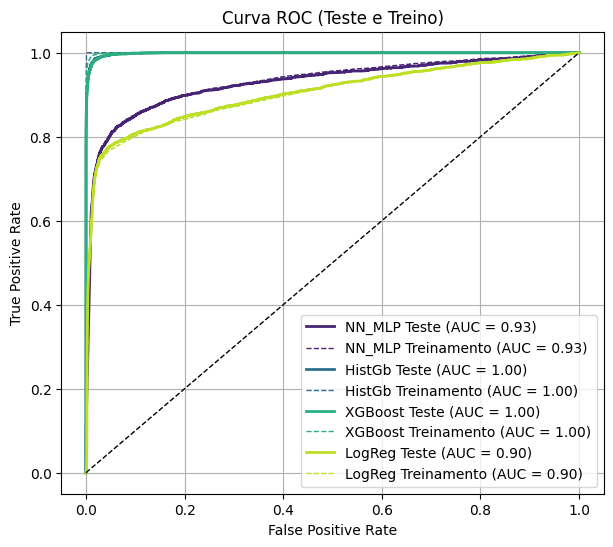

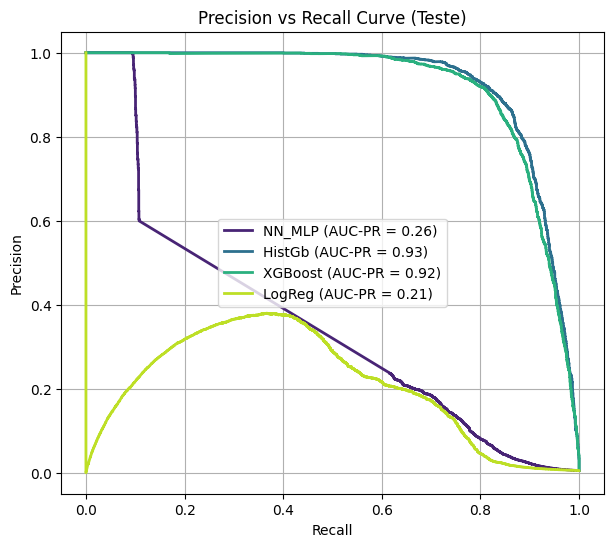

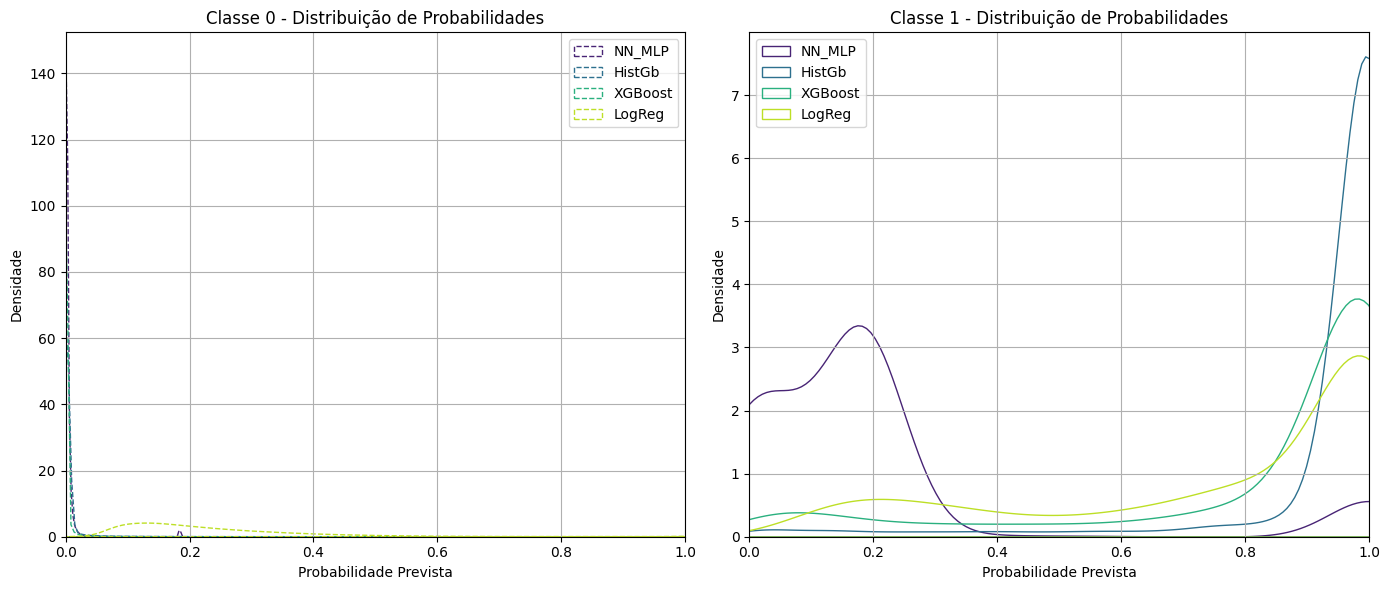

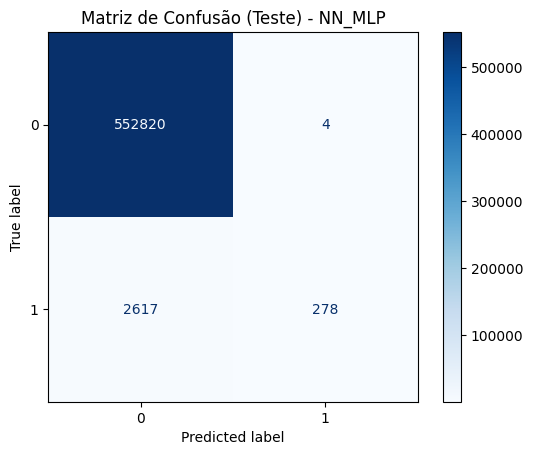


===== MÉTRICAS TESTE - NN_MLP =====
Acurácia:     0.9953
Precisão:     0.9858
Recall:       0.0960
F1-score:     0.1750
ROC AUC:      0.9294
AUC Precision-Recall: 0.2632


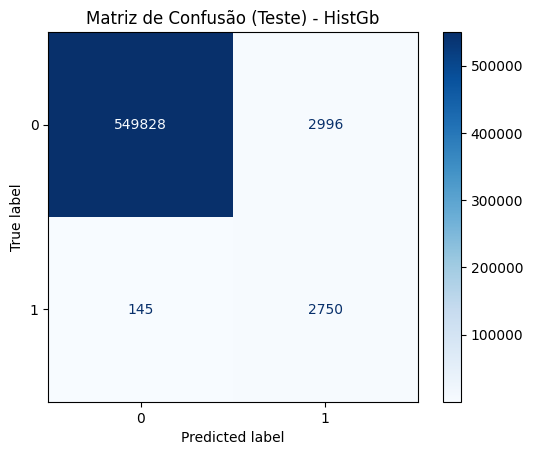


===== MÉTRICAS TESTE - HistGb =====
Acurácia:     0.9943
Precisão:     0.4786
Recall:       0.9499
F1-score:     0.6365
ROC AUC:      0.9987
AUC Precision-Recall: 0.9259


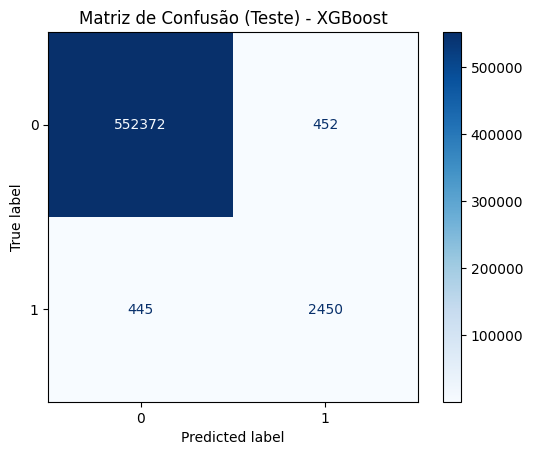


===== MÉTRICAS TESTE - XGBoost =====
Acurácia:     0.9984
Precisão:     0.8442
Recall:       0.8463
F1-score:     0.8453
ROC AUC:      0.9985
AUC Precision-Recall: 0.9167


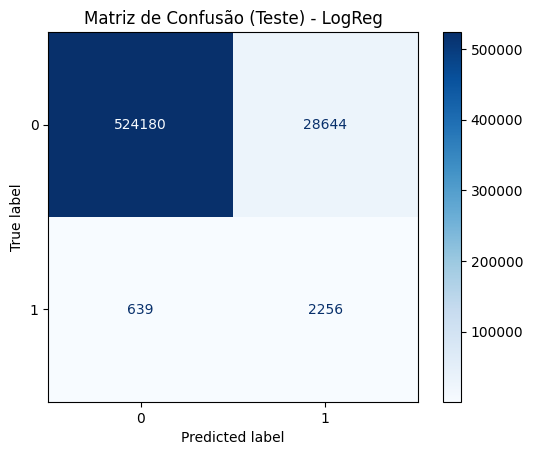


===== MÉTRICAS TESTE - LogReg =====
Acurácia:     0.9473
Precisão:     0.0730
Recall:       0.7793
F1-score:     0.1335
ROC AUC:      0.9042
AUC Precision-Recall: 0.2053


In [ ]:
def avaliar_modelos_multiplos(resultados_modelos, threshold=0.5):

    import matplotlib.cm as cm
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        roc_curve, roc_auc_score,
        precision_recall_curve, average_precision_score,
        confusion_matrix, ConfusionMatrixDisplay,
        accuracy_score, precision_score, recall_score, f1_score
    )



    """
    Avalia múltiplos modelos de classificação binária comparando curvas ROC, Precision-Recall e métricas.
    """


    metricas_dict = {}


    # Criar dicionário de cores único para os modelos, com espaçamento melhor na paleta viridis
    nomes_modelos = list(resultados_modelos.keys())
    cmap = cm.get_cmap("viridis")

    # Evita extremos (muito claro ou escuro) escolhendo valores entre 10% e 90%
    cores_viridis = [cmap(x) for x in np.linspace(0.1, 0.9, len(nomes_modelos))]
    cores_dict = dict(zip(nomes_modelos, cores_viridis))

    # ===== CURVA ROC =====
    plt.figure(figsize=(7, 6))
    for nome_modelo, dados in resultados_modelos.items():
        fpr_test, tpr_test, _ = roc_curve(dados["y_test_true"], dados["y_test_proba"])
        auc_test = roc_auc_score(dados["y_test_true"], dados["y_test_proba"])
        plt.plot(fpr_test, tpr_test, lw=2, label=f"{nome_modelo} Teste (AUC = {auc_test:.2f})", color=cores_dict[nome_modelo])

        fpr_train, tpr_train, _ = roc_curve(dados["y_train_true"], dados["y_train_proba"])
        auc_train = roc_auc_score(dados["y_train_true"], dados["y_train_proba"])
        plt.plot(fpr_train, tpr_train, lw=1, linestyle='--', label=f"{nome_modelo} Treinamento (AUC = {auc_train:.2f})", color=cores_dict[nome_modelo])

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.title("Curva ROC (Teste e Treino)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ===== PRECISION vs RECALL =====
    plt.figure(figsize=(7, 6))
    for nome_modelo, dados in resultados_modelos.items():
        precision, recall, _ = precision_recall_curve(dados["y_test_true"], dados["y_test_proba"])
        auc_pr = average_precision_score(dados["y_test_true"], dados["y_test_proba"])
        plt.plot(recall, precision, lw=2, label=f"{nome_modelo} (AUC-PR = {auc_pr:.2f})", color=cores_dict[nome_modelo])

    plt.title("Precision vs Recall Curve (Teste)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ===== KDE de Probabilidades =====
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

    for nome_modelo, dados in resultados_modelos.items():
        proba_negativo = dados["y_test_proba"][dados["y_test_true"] == 0]
        sns.kdeplot(
            proba_negativo,
            label=nome_modelo,
            linestyle="--",
            fill=True,
            color=cores_dict[nome_modelo],
            alpha=0,
            bw_adjust=1.2,
            ax=axes[0]
        )

    axes[0].set_title("Classe 0 - Distribuição de Probabilidades")
    axes[0].set_xlabel("Probabilidade Prevista")
    axes[0].set_ylabel("Densidade")
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(bottom=0)

    for nome_modelo, dados in resultados_modelos.items():
        proba_positivo = dados["y_test_proba"][dados["y_test_true"] == 1]
        sns.kdeplot(
            proba_positivo,
            label=nome_modelo,
            fill=True,
            color=cores_dict[nome_modelo],
            alpha=0,
            bw_adjust=1.2,
            ax=axes[1]
        )

    axes[1].set_title("Classe 1 - Distribuição de Probabilidades")
    axes[1].set_xlabel("Probabilidade Prevista")
    axes[1].set_ylabel("Densidade")
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

    # ===== MATRIZ DE CONFUSÃO E MÉTRICAS =====
    for nome_modelo, dados in resultados_modelos.items():
        y_test_pred = (dados["y_test_proba"] >= threshold).astype(int)

        cm = confusion_matrix(dados["y_test_true"], y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Matriz de Confusão (Teste) - {nome_modelo}")
        plt.show()

        accuracy = accuracy_score(dados["y_test_true"], y_test_pred)
        precision_val = precision_score(dados["y_test_true"], y_test_pred, zero_division=0)
        recall_val = recall_score(dados["y_test_true"], y_test_pred)
        f1 = f1_score(dados["y_test_true"], y_test_pred)
        auc_roc = roc_auc_score(dados["y_test_true"], dados["y_test_proba"])
        auc_pr = average_precision_score(dados["y_test_true"], dados["y_test_proba"])

        print(f"\n===== MÉTRICAS TESTE - {nome_modelo} =====")
        print(f"Acurácia:     {accuracy:.4f}")
        print(f"Precisão:     {precision_val:.4f}")
        print(f"Recall:       {recall_val:.4f}")
        print(f"F1-score:     {f1:.4f}")
        print(f"ROC AUC:      {auc_roc:.4f}")
        print(f"AUC Precision-Recall: {auc_pr:.4f}")

        metricas_dict[nome_modelo] = {
            "Acurácia": accuracy,
            "Precisão": precision_val,
            "Recall": recall_val,
            "F1-score": f1,
            "ROC AUC": auc_roc,
            "AUC Precision-Recall": auc_pr
        }

    return metricas_dict

        

metricas_finais = avaliar_modelos_multiplos(resultados_finais, threshold=threshold)



# 6 Selecinando e salvando para prod melhor modelo

* Aqui foram aplicados os criterios de selecao especificados no inicio do projeto

In [ ]:

def selecionar_e_salvar_best_model(metricas_finais, pasta_base):
    # Definir critérios mínimos de acordo com o determinado no projeto
    CRIT_RECALL = 0.70
    CRIT_AUCROC = 0.85
    CRIT_F1 = 0.74

    # Filtrar modelos que atendem aos critérios
    modelos_qualificados = {}
    for nome, m in metricas_finais.items():
        if (
            m['Recall'] >= CRIT_RECALL and
            m['ROC AUC'] >= CRIT_AUCROC and
            m['F1-score'] >= CRIT_F1
        ):
            media_metricas = (m['Recall'] + m['ROC AUC'] + m['F1-score']) / 3
            modelos_qualificados[nome] = media_metricas

    if not modelos_qualificados:
        print("⚠️ Nenhum modelo atendeu a todos os critérios definidos.")
        return

    # Seleciona o modelo com maior média entre as métricas
    melhor_modelo = max(modelos_qualificados, key=modelos_qualificados.get)
    print(f"🏆 Modelo selecionado como melhor: {melhor_modelo}")

    # Caminhos de origem e destino
    origem = os.path.join(pasta_base, melhor_modelo, "modelo.pkl")
    destino_pasta = os.path.join(pasta_base, "best_model")
    os.makedirs(destino_pasta, exist_ok=True)
    destino = os.path.join(destino_pasta, "modelo.pkl")

    # Copiar o modelo
    shutil.copy(origem, destino)
    print(f"📁 Modelo copiado para: {destino}")

    # Criar arquivo de métricas
    caminho_metricas = os.path.join(destino_pasta, "metricas.txt")
    with open(caminho_metricas, "w") as f:
        f.write(f"Métricas do melhor modelo: {melhor_modelo}\n\n")
        for metrica, valor in metricas_finais[melhor_modelo].items():
            f.write(f"{metrica}: {round(float(valor), 4)}\n")

    # Salva nome do modelo escolhido
    caminho_nome_modelo = os.path.join(destino_pasta, "modelo_escolhido.txt")
    with open(caminho_nome_modelo, "w") as f:
        f.write(melhor_modelo)

    print(f"📝 Métricas salvas em: {caminho_metricas}")
    print(f"📌 Nome do modelo salvo em: {caminho_nome_modelo}")


In [99]:
selecionar_e_salvar_best_model(metricas_finais=metricas_finais, pasta_base="modelos_treinados")


🏆 Modelo selecionado como melhor: XGBoost
📁 Modelo copiado para: modelos_treinados\best_model\modelo.pkl
📝 Métricas salvas em: modelos_treinados\best_model\metricas.txt
📌 Nome do modelo salvo em: modelos_treinados\best_model\modelo_escolhido.txt


# Explicabilidade e analise de Justica das decisoes do modelo

* nos dados de teste, usando melhor modelo salvo em .pkl

In [ ]:
#carregua o modelo
pipeline = joblib.load("modelos_treinados/best_model/modelo.pkl")


# Função para calcular e mostrar as métricas de performance
def calcular_metricas_performance(y_true, y_pred, y_prob):
    from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,average_precision_score)



    print("Métricas de performance do modelo:")
    print("Acurácia:", accuracy_score(y_true, y_pred))
    print("Precisão:", precision_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print("Precision-Recall AUC:", average_precision_score(y_true, y_prob))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Não Fraude", "Fraude"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.show()

    
# Função para calcular as métricas de viés por grupo de 'age' e 'gender'
def calcular_metricas_por_grupo(X_test, y_test, y_pred):


    # Calcular as métricas para o gênero
    metricas_gender = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "f1": f1_score,
            "recall": recall_score,
            "roc_auc": roc_auc_score
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=X_test['gender']
    )

    print("\nMétricas por grupo de Gênero:")
    print(metricas_gender.by_group)

    # Visualizar comparações de taxa de acerto, recall, F1-Score e ROC AUC por grupo de 'gender'
    metricas_gender.by_group[['accuracy', 'f1', 'recall', 'roc_auc']].plot(kind='bar', figsize=(12, 6))
    plt.title("Comparação de Métricas por Gênero")
    plt.ylabel("Métrica")
    plt.xlabel("Gênero")
    plt.xticks(rotation=0)
    plt.show()



    # Calcular as métricas para as faixas etárias


    def atribuir_faixa_etaria(age):
        if 0 <= age <= 18:
            return '0-18'
        elif 19 <= age <= 30:
            return '19-30'
        elif 31 <= age <= 45:
            return '31-45'
        elif 46 <= age <= 60:
            return '46-60'
        elif age > 60:
            return '61+'
        else:
            return 'Desconhecido'  # Em caso de valor inesperado, como NaN (não necessário se a coluna de idades não contiver NaN)

    # Aplicando a função ao DataFrame
    X_test['age_group'] = X_test['age'].apply(atribuir_faixa_etaria)

    # Converte a coluna 'age_group' para tipo categórico
    X_test['age_group'] = X_test['age_group'].astype('category')

    # Verificando as faixas criadas
    print(X_test['age_group'].unique())

    # Calcular as métricas para as faixas etárias
    metricas_age = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "f1": f1_score,
            "recall": recall_score,
            "roc_auc": roc_auc_score
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=X_test['age_group']
    )

    print("\nMétricas por faixa etária:")
    print(metricas_age.by_group)

    # Visualizar comparações de taxa de acerto, recall, F1-Score e ROC AUC por faixa etária
    metricas_age.by_group[['accuracy', 'f1', 'recall', 'roc_auc']].plot(kind='bar', figsize=(12, 6))
    plt.title("Comparação de Métricas por Faixa Etária")
    plt.ylabel("Métrica")
    plt.xlabel("Faixa Etária")
    plt.xticks(rotation=45)
    plt.show()






# Função para calcular e exibir a análise SHAP
def calcular_shap(X_test, pipeline):
    import shap
    import pandas as pd

    # Extrair pré-processador e modelo do pipeline
    preprocessador = pipeline.named_steps['preprocessing']
    modelo = pipeline.named_steps['model']

    # Aplicar apenas o pré-processamento nos dados de teste
    X_transformed = preprocessador.transform(X_test)

    # Obter os nomes das features após transformação
    try:
        feature_names = preprocessador.get_feature_names_out()
    except AttributeError:
        feature_names = [f'feature_{i}' for i in range(X_transformed.shape[1])]

    # Converter para DataFrame com nomes das features
    X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

    # Verificar se o modelo é baseado em árvore (como XGBoost ou CatBoost)
    if hasattr(modelo, 'apply'):
        explainer = shap.TreeExplainer(modelo)
    else:
        explainer = shap.KernelExplainer(modelo.predict_proba, X_transformed_df)

    # Calcular os valores SHAP
    shap_values = explainer.shap_values(X_transformed_df)

    # Exibi o gráfico global de SHAP 
    shap.summary_plot(shap_values, X_transformed_df)





def calcular_lime_com_fraude(X_test, y_test, pipeline, idx_observacoes=None):
    import lime
    import lime.lime_tabular
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt  

    # Extrair pré-processador e modelo do pipeline
    preprocessador = pipeline.named_steps['preprocessing']
    modelo = pipeline.named_steps['model']

    # Pré-processar os dados
    X_transformed = preprocessador.transform(X_test)

    # Obter nomes das variáveis após transformação
    try:
        feature_names = preprocessador.get_feature_names_out()
    except AttributeError:
        feature_names = [f'feature_{i}' for i in range(X_transformed.shape[1])]

    # Garantir array NumPy
    X_transformed = np.array(X_transformed)

    # Predição
    y_pred = modelo.predict(X_transformed)

    # Definir os índices a serem explicados
    if idx_observacoes is not None:
        # Validação dos índices fornecidos
        idx_observacoes = [idx for idx in idx_observacoes if 0 <= idx < len(X_transformed)]
        if not idx_observacoes:
            print("❌ Nenhuma observação válida fornecida.")
            return
        idx_selecionados = idx_observacoes
    else:
        # Identificar índices de fraude e não fraude
        idx_fraude = np.where(y_pred == 1)[0]
        idx_nao_fraude = np.where(y_pred == 0)[0]

        if len(idx_fraude) == 0:
            print("⚠️ Nenhuma observação foi classificada como fraude pelo modelo.")
            return

        # Selecionar 1 observação de fraude e 2 de não fraude (se disponíveis)
        np.random.seed(42)
        idx_selecionados = [np.random.choice(idx_fraude)]
        if len(idx_nao_fraude) >= 2:
            idx_selecionados += list(np.random.choice(idx_nao_fraude, size=2, replace=False))
        else:
            idx_selecionados += list(idx_nao_fraude)

    # Cria o explicador LIME
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_transformed,
        feature_names=feature_names,
        class_names=['Não Fraude', 'Fraude'],
        discretize_continuous=True,
        mode='classification'
    )

    # Mostrar explicações
    for idx in idx_selecionados:
        classe = "FRAUDE" if y_pred[idx] == 1 else "NÃO FRAUDE"
        print(f"\n🔎 Explicação para a observação {idx} classificada como {classe}")
        exp = explainer.explain_instance(
            X_transformed[idx],
            modelo.predict_proba,
            num_features=10
        )
        fig = exp.as_pyplot_figure()
        plt.show()



# Função para calcular e exibir métricas de justiça (Fairness) usando Fairlearn


# Função para calcular as métricas de justiça
def calcular_metrica_justica(X_test, y_test, y_pred):

    import pandas as pd
    from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

    # Função para atribuir faixa etária
    def atribuir_faixa_etaria(age):
        if 0 <= age <= 18:
            return '0-18'
        elif 19 <= age <= 30:
            return '19-30'
        elif 31 <= age <= 45:
            return '31-45'
        elif 46 <= age <= 60:
            return '46-60'
        elif age > 60:
            return '61+'
        else:
            return 'Desconhecido'  # Caso a idade seja inválida, como NaN

    # Aplicando a função de faixa etária ao DataFrame
    X_test['age_group'] = X_test['age'].apply(atribuir_faixa_etaria)

    # Convertendo a coluna 'age_group' para tipo categórico
    X_test['age_group'] = X_test['age_group'].astype('category')

    # Calculando as métricas de justiça para gênero e faixa etária
    dp_gender = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test['gender'])
    dp_age = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test['age_group'])

    eo_gender = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test['gender'])
    eo_age = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test['age_group'])

    # Exibindo as métricas de justiça
    print(f"\nDemographic Parity Difference (Gender): {dp_gender}")
    print(f"Demographic Parity Difference (Age): {dp_age}")
    print(f"Equalized Odds Difference (Gender): {eo_gender}")
    print(f"Equalized Odds Difference (Age): {eo_age}")


# Obtenção das previsões
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilidade para a classe positiva



Métricas de performance do modelo:
Acurácia: 0.9983858748756116
Precisão: 0.8442453480358374
F1-Score: 0.8452647921338623
Recall: 0.846286701208981
ROC AUC: 0.9985419886591659
Precision-Recall AUC: 0.9167052297742535


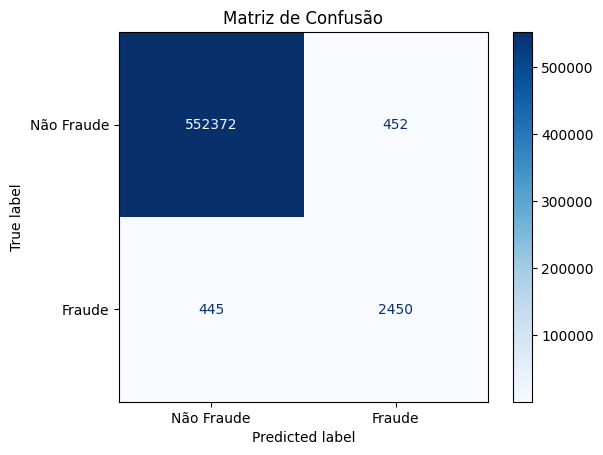

In [172]:
# Calcular e mostrar as métricas de performance

'''aqui so pra garantir que os resultadods sao os mesmos do teste aplicado antes de salvar o modelo, 
    vemos que o modelo e o pipeline funcionam pos salvamento

    OBS: aqui mesmo carregando o pkl do modelo e pipeline, precisa que sejam carrecados treino e teste nos dados 
    (rodar ate o split train test)'''


calcular_metricas_performance(y_test, y_pred, y_prob)




Métricas por grupo de Gênero:
        accuracy   f1  recall  roc_auc
gender                                
F           1.00 0.80    0.80     0.90
M           1.00 0.88    0.90     0.95


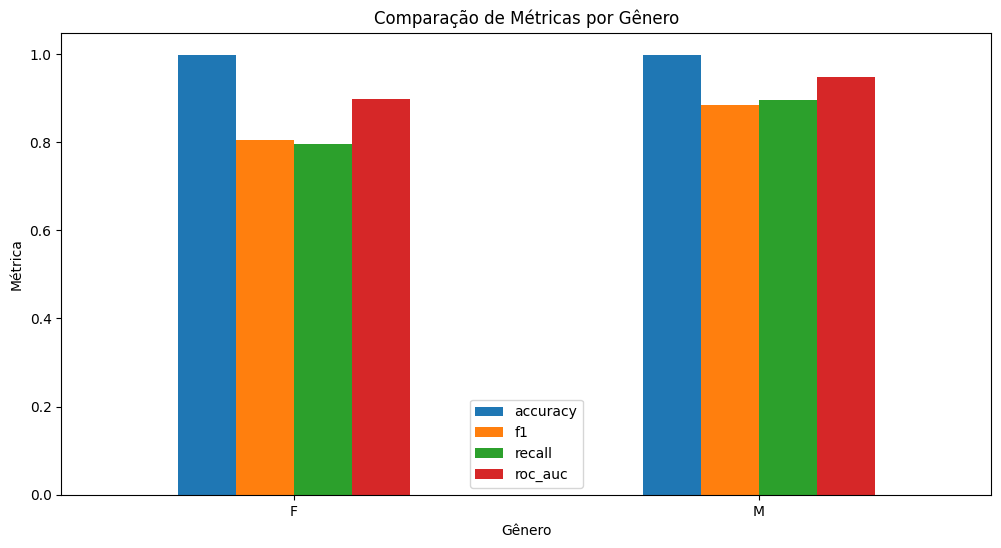

['31-45', '46-60', '19-30', '0-18', '61+']
Categories (5, object): ['0-18', '19-30', '31-45', '46-60', '61+']

Métricas por faixa etária:
           accuracy   f1  recall  roc_auc
age_group                                
0-18           1.00 0.92    0.93     0.97
19-30          1.00 0.82    0.83     0.92
31-45          1.00 0.77    0.78     0.89
46-60          1.00 0.86    0.86     0.93
61+            1.00 0.93    0.91     0.96


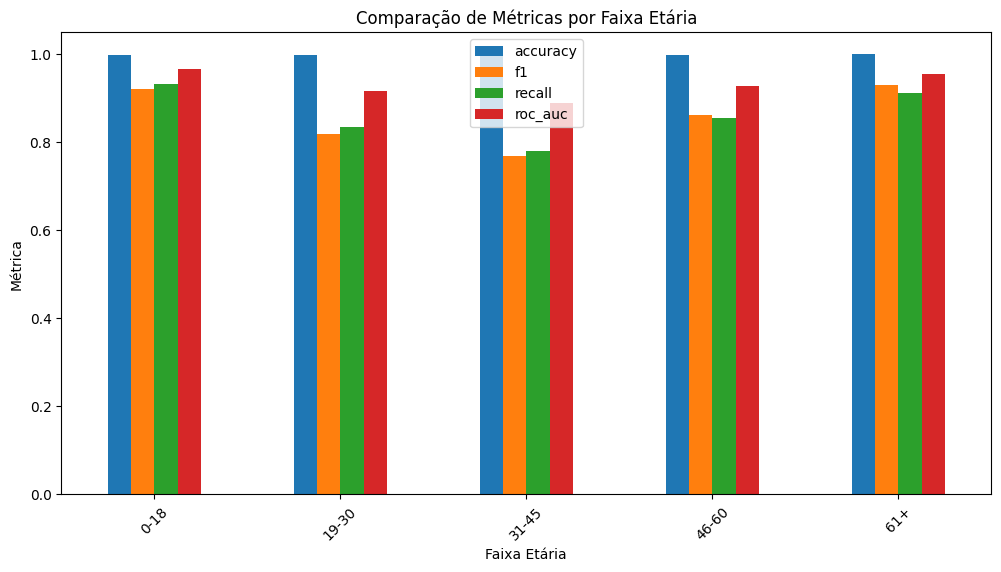

In [173]:
# Calcular e exibir as métricas de viés por grupo

'''aqui olhamos as metricas por genero pra ter uma ideia de discriminacao, como vemos aparentemente nao ha'''

''' Tambem dividmos a idade em faixas para testar se ha discriminacao pela idade de forma visual, 
    de 19 a 45 anos ha uma metricas mais baixas, mas nada discrepante tambem'''
calcular_metricas_por_grupo(X_test, y_test, y_pred)




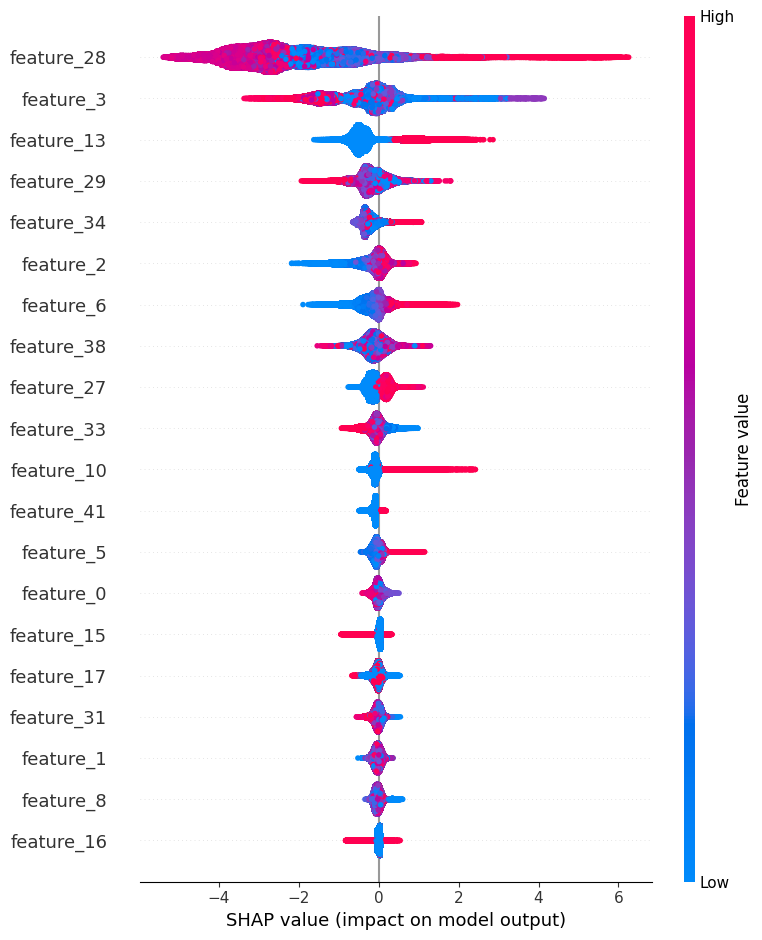

In [174]:
# Calcular e exibir a análise SHAP

''' aqui  vemos como as features influenciam na decisao de forma global com shap, e uma metrica de explicabilidade. 
    Tive problemas para voltar o nome das variaveis, nao consegui solucionar, mas podemos ver que nao ha nada muito preocupante, 
    fica a melhoria futura pra tentar '''
calcular_shap(X_test, pipeline)




🔎 Explicação para a observação 163526 classificada como FRAUDE


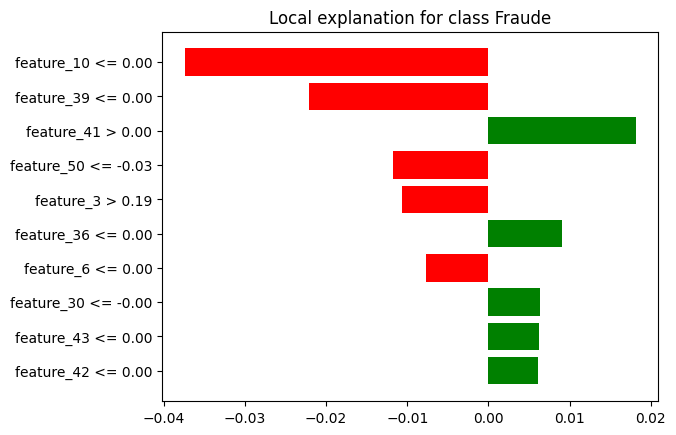


🔎 Explicação para a observação 12 classificada como NÃO FRAUDE


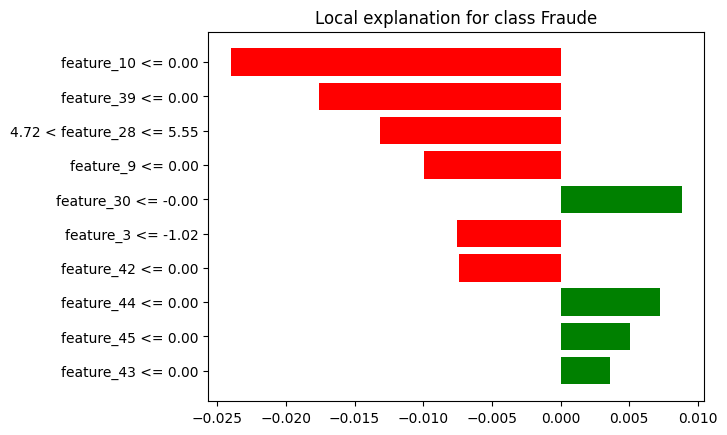


🔎 Explicação para a observação 33 classificada como NÃO FRAUDE


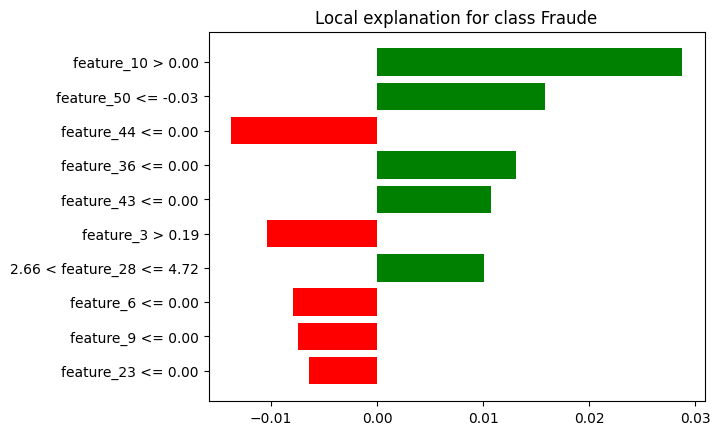

In [175]:
''' aqui vemos como as features influenciam na decisao de forma local com LIME em 3 observacoes, e uma metrica de explicabilidade. 
    Tive problemas para voltar o nome das variaveis, nao consegui solucionar, aqui tambem nada descrepante'''

# Passando uma lista específica de observações
calcular_lime_com_fraude(X_test, y_test, pipeline, idx_observacoes=[163526, 12, 33]) # lista com n linha das observacoes

#escolher automaticamente (sequencial)
#calcular_lime_com_fraude(X_test, y_test, pipeline)

In [ ]:
# Calculo de vies com Fairness 
''' 
As métricas de Demographic Parity Difference e Equalized Odds Difference são usadas para avaliar o viés do modelo em relação a características sensíveis, como gênero e idade.


* Demographic Parity Difference mede a diferença na taxa de resultados positivos (fraude detectada, neste caso) entre grupos com base em uma característica sensível. 
O ideal seria que a diferença fosse próxima de 0, indicando que a decisão do modelo não é influenciada por essa característica sensível (gênero ou idade).

* Equalized Odds Difference avalia a diferença nas taxas de falsos positivos e falsos negativos entre os grupos. Uma diferença maior que 0 sugere que o modelo comete 
mais erros de classificação em um grupo em comparação com outro, o que indica um possível viés no processo de decisão.



Aqui as diferenças pequenas em Demographic Parity (para gênero e idade) indicam que a distribuição das fraudes detectadas é relativamente equilibrada entre os grupos. 
No entanto, as diferenças mais altas em Equalized Odds, especialmente para a idade, mostram que o modelo pode estar cometendo mais erros em algumas faixas etárias, resultando em decisões menos precisas para esses grupos.


O ponto de melhoria seria ajustar o modelo para reduzir os erros de classificação nas faixas etárias específicas, buscando promover um tratamento mais justo para todos os grupos e minimizando o viés nas decisões erradas.


Ainda assim os resultados nao sao preocupantes, mas devem ser observados, principalemnte em Equalized Odds Difference (Age) para que nao aumente.

'''

calcular_metrica_justica(X_test, y_test, y_pred)


Demographic Parity Difference (Gender): 0.0012544818383971226
Demographic Parity Difference (Age): 0.0021471854642836543
Equalized Odds Difference (Gender): 0.098472547958386
Equalized Odds Difference (Age): 0.1515550239234449


# Explicabilidade dos Hiperparametros do modelo by Dashboard Optuna 

* Dashboard é um painel web em tempo real para o Optuna. Você pode verificar o histórico de otimização, a importância dos hiperparâmetros, etc. em gráficos e tabelas. Ele basicamente salva os resultados em um banco de dados, garantindo continuidade e armazenamento dos trials de forma acumulativa, proporcionando historico para analise de melhoria ao longo dos estudos. Consultar doc em https://optuna.org/

* acessar Dahsboard_Optuna_observacoes.md neste diretorio para entender a implementação atual.

* Aqui trarei algumas das metricas atraves de prints do melhor modelo: 



In [181]:
'''tambem e possivel alem do dahsboard acessar eles via codigo, mas nao fica legal de registrar, graficos nao ficam estaticos no notebook'''

# import optuna
# from optuna.visualization import plot_parallel_coordinate

# # Carregue seu estudo (ajuste o nome e o storage conforme seu caso)
# study = optuna.load_study(study_name="XGBoost_study", storage="sqlite:///Fraud_study_models_by_Optuna.db")

# # Gerar o gráfico de coordenadas paralelas
# fig = plot_parallel_coordinate(study)

# # Exibir o gráfico
# fig.show()



'tambem e possivel alem do dahsboard acessar eles via codigo, mas nao fica legal de registrar, graficos nao ficam estaticos no notebook'

![Print](prints/Captura%20de%20tela%202025-05-02%20020644.png)


![Print](prints/Captura%20de%20tela%202025-05-02%20020722.png)


![Print](prints/Captura%20de%20tela%202025-05-02%20010327.png)


![Print](prints/Captura%20de%20tela%202025-05-02%20010349.png)


![Print](prints/Captura%20de%20tela%202025-05-02%20010533.png)


# CONCLUSAO

O projeto foi concluído com sucesso, com todos os critérios e métricas atendidos. O modelo final demonstrou alto desempenho preditivo, com uma estrutura robusta implementada via pipeline, garantindo segurança e ausência de vazamento de dados entre treino e teste. A validação com K-Folds aumentou a confiabilidade dos resultados, e o processo de feature engineering teve papel fundamental, com melhorias notáveis na performance à medida que novas variáveis foram criadas.


Foram testados quatro modelos — XGBoost, HistGradientBoosting, MLPClassifier e Regressão Logística do scikit-learn —, otimizados com o Optuna. Os resultados foram analisados de forma visual e comparativa por meio do dashboard do Optuna e das métricas de desempenho definidas. O uso do framework CRISP-DM contribuiu para o planejamento e organização do projeto, e o modelo final está pronto para aplicação em produção, apresentando alta capacidade preditiva e segurança na detecção de fraudes.
  

  
**Métricas do melhor modelo: XGBoost**

Acurácia: 0.9984  
Precisão: 0.8442  
Recall: **0.8463 (significativamente maior que 0.70)**    
F1-score: **0.8453 (significativamente maior que 0.74)**    
ROC AUC: **0.9985 (significativamente maior que 0.85)**    
AUC Precision-Recall: 0.9167  

